In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision import datasets, transforms, models
import time
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.autograd import Variable


In [2]:
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    
])

In [3]:
test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    
])

In [4]:
validation_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    
])

In [5]:
root = 'C:/Users/ENES DORUK/Desktop/CNN_Harf/Dataset'

train_data = datasets.ImageFolder(os.path.join(root,'training_set'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root,'test_set'), transform=test_transform)
valid_data = datasets.ImageFolder(os.path.join(root,'validation_set'),  transform=validation_transform)

torch.manual_seed(42)

train_loader = DataLoader(train_data, batch_size=30, shuffle=True,pin_memory=True)
test_loader = DataLoader(test_data, batch_size=30,pin_memory=True)
valid_loader =  DataLoader(valid_data, batch_size=30,pin_memory=True)

dataset_sizes = len(train_data)

class_names = train_data.classes

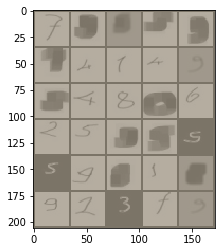

In [6]:
for images, labels in train_loader:
    break
im = make_grid(images,nrow=5)
inv_normalize = transforms.Normalize(
        mean= [-0.485/0.225,
              -0.456/0.224,
              -0.406/0.225],
        std= [1/0.225, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(),(1,2,0)))

In [15]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.4))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.Dropout2d(0.4),
            nn.MaxPool2d(2),
            nn.ReLU())
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.Dropout2d(0.4),
            nn.ReLU())    
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.Dropout2d(0.4),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.Dropout2d(0.4),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.Dropout2d(0.4),
            nn.MaxPool2d(2),
            nn.ReLU())
        
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = out.view(out.size(0), -1)
        out = F.softmax(self.fc1(out))
        out = F.softmax(self.fc2(out))
        out = F.softmax(self.fc3(out))
        return out
        

from torch.utils.tensorboard import SummaryWriter
tb = SummaryWriter()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cnn = CNN().to(device)


In [16]:
epochs = 1000
learning_rate = 0.01
momentum = 0.5

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [17]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)

In [22]:
import torchvision
train_loss = []
correct_graph = []

def train(cnn):
    start = time.time()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for epoch in range(epochs): 
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 50)
        train_loss.append(loss.item())
        
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            
            optimizer.zero_grad()
            
            outputs = cnn(inputs)
            total += labels.size(0)
            predicted = torch.max(outputs.data, 1)[1]
            loss = criterion(outputs, labels)
            correct += (predicted == labels).sum().item()
            correct_graph.append((predicted == labels).sum().item())
            running_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            
            if i % 100 == 99:   
                print("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")
                tb.add_scalar('training loss',
                                running_loss / 1000,
                                epoch * len(train_loader) + i)

               
                grid = torchvision.utils.make_grid(inputs)
                tb.add_image("images", grid)
                tb.add_graph(cnn, inputs)
                tb.add_scalar("Loss", running_loss, epoch)
                tb.add_scalar("Correct", correct,epoch)
                tb.add_scalar("Accuracy", correct/len(train_data), epoch)
                
                running_loss = 0.0
            print("Loss", loss.item())
            
            if epoch % 10 == 0:
                torch.save(cnn.state_dict(), 'C:/Users/ENES DORUK/Desktop/CNN_Harf/Save_model/vgg/model_{}.pth'.format(epoch))
                print("Correct", correct)
    end = time.time()
    

    print('Done Training')
    print('%0.2f minutes' %((end - start) / 60))
    
    return cnn
    
train(cnn)
tb.close()       

Epoch 0/999
--------------------------------------------------
Loss 2.2977609634399414
Correct 4
Loss 2.291179895401001
Correct 8
Loss 2.3035542964935303
Correct 12
Loss 2.2999348640441895
Correct 15
Loss 2.284426689147949
Correct 22
Loss 2.2891454696655273
Correct 29
Loss 2.294872522354126
Correct 33
Loss 2.2988407611846924
Correct 34
Loss 2.3085989952087402
Correct 36
Loss 2.31313157081604
Correct 37
Loss 2.3146677017211914
Correct 39
Loss 2.3028104305267334
Correct 42
Loss 2.3082149028778076
Correct 45
Loss 2.305694818496704
Correct 51
Loss 2.2958638668060303
Correct 56
Loss 2.3073267936706543
Correct 59
Loss 2.304702043533325
Correct 62
Loss 2.3133580684661865
Correct 63
Loss 2.3129684925079346
Correct 65
Loss 2.3151872158050537
Correct 67
Loss 2.3020238876342773
Correct 69
Loss 2.299569606781006
Correct 73
Loss 2.3026912212371826
Correct 75
Loss 2.3056516647338867
Correct 78
Loss 2.3069682121276855
Correct 81
Loss 2.300816774368286
Correct 86
Loss 2.310703992843628
Correct 89
Loss

Loss 2.3029375076293945
Correct 737
Loss 2.288790702819824
Correct 740
Loss 2.3163256645202637
Correct 743
Loss 2.3137619495391846
Correct 746
Loss 2.3154358863830566
Correct 747
Loss 2.295811891555786
Correct 749
Loss 2.3127496242523193
Correct 751
Loss 2.3054420948028564
Correct 753
Loss 2.3042006492614746
Correct 755
Loss 2.3249597549438477
Correct 756
Loss 2.3028221130371094
Correct 758
Loss 2.2991714477539062
Correct 764
Loss 2.2933053970336914
Correct 770
Loss 2.315751314163208
Correct 772
Loss 2.31581711769104
Correct 775
Loss 2.3211638927459717
Correct 777
Loss 2.303640127182007
Correct 781
Loss 2.312307119369507
Correct 782
Loss 2.3046040534973145
Correct 785
Loss 2.300797700881958
Correct 786
Loss 2.2911314964294434
Correct 791
Loss 2.313185453414917
Correct 794
Loss 2.321859836578369
Correct 795
Loss 2.3116726875305176
Correct 799
Loss 2.302440881729126
Correct 801
Loss 2.3133130073547363
Correct 803
Loss 2.3072550296783447
Correct 804
Loss 2.302155017852783
Correct 807
Loss

Correct 1382
Loss 2.307176351547241
Correct 1385
Loss 2.308790922164917
Correct 1391
Loss 2.296008348464966
Correct 1393
Loss 2.3002865314483643
Correct 1397
Loss 2.3171324729919434
Correct 1400
Loss 2.295879364013672
Correct 1403
Loss 2.2981979846954346
Correct 1404
Loss 2.2957561016082764
Correct 1408
Loss 2.3115720748901367
Correct 1413
Loss 2.302361011505127
Correct 1416
Loss 2.314134120941162
Correct 1417
Loss 2.3070566654205322
Correct 1418
Loss 2.2978034019470215
Correct 1421
Loss 2.3064982891082764
Correct 1425
Loss 2.3035085201263428
Correct 1428
Loss 2.300722360610962
Correct 1432
Loss 2.2910892963409424
Correct 1435
Loss 2.3042173385620117
Correct 1437
Loss 2.3057501316070557
Correct 1441
Loss 2.3066511154174805
Correct 1443
Loss 2.301568031311035
Correct 1447
Loss 2.3151559829711914
Correct 1449
Loss 2.3059914112091064
Correct 1450
Loss 2.3035926818847656
Correct 1452
Loss 2.297276496887207
Correct 1454
Loss 2.290816307067871
Correct 1457
Loss 2.302734136581421
Correct 1461

Loss 2.3009836673736572
Correct 2027
Loss 2.3074371814727783
Correct 2030
Loss 2.3093338012695312
Correct 2032
Loss 2.272675037384033
Correct 2039
Loss 2.308997631072998
Correct 2041
Loss 2.3134820461273193
Correct 2043
Loss 2.298848867416382
Correct 2047
Loss 2.317471742630005
Correct 2048
Loss 2.300994634628296
Correct 2052
Loss 2.317058563232422
Correct 2055
Loss 2.3010401725769043
Correct 2058
Loss 2.288130283355713
Correct 2065
Loss 2.315187931060791
Correct 2065
Loss 2.309828758239746
Correct 2070
Loss 2.298492193222046
Correct 2076
Loss 2.2979307174682617
Correct 2081
Loss 2.307939052581787
Correct 2083
Loss 2.297454357147217
Correct 2088
Loss 2.295152187347412
Correct 2092
Loss 2.31734561920166
Correct 2094
Loss 2.308143138885498
Correct 2096
Loss 2.2964465618133545
Correct 2100
Loss 2.2972400188446045
Correct 2103
Loss 2.305096387863159
Correct 2105
Loss 2.3126778602600098
Correct 2107
Loss 2.309199810028076
Correct 2109
Loss 2.3083367347717285
Correct 2110
Loss 2.308158874511

Loss 2.3143019676208496
Loss 2.301657199859619
Loss 2.306100606918335
Loss 2.302976369857788
Loss 2.2969677448272705
Loss 2.293659210205078
Loss 2.309644937515259
Loss 2.2945141792297363
Loss 2.3072633743286133
Loss 2.305044651031494
Loss 2.2942283153533936
Loss 2.2908408641815186
Loss 2.31502103805542
Loss 2.309974431991577
Loss 2.308953046798706
Loss 2.323225975036621
Loss 2.3112001419067383
Loss 2.2939751148223877
Loss 2.3041343688964844
Loss 2.3028335571289062
Loss 2.3089396953582764
Loss 2.3181254863739014
Loss 2.310870885848999
Loss 2.309209108352661
Loss 2.304210662841797
Loss 2.3119876384735107
Loss 2.2892239093780518
Loss 2.2971837520599365
Loss 2.2987635135650635
Loss 2.2990071773529053
Loss 2.302849054336548
Loss 2.30401611328125
Loss 2.2968618869781494
Loss 2.308429002761841
Loss 2.308558225631714
Loss 2.3001508712768555
Loss 2.302959442138672
Loss 2.300811290740967
Loss 2.2893826961517334
Loss 2.313624620437622
Loss 2.3001976013183594
Loss 2.3005058765411377
Loss 2.2909891

Loss 2.30545973777771
Loss 2.3146767616271973
Loss 2.308152198791504
Loss 2.2833616733551025
Loss 2.3058815002441406
Loss 2.2975480556488037
Loss 2.2983202934265137
Loss 2.2855803966522217
Loss 2.292323350906372
Loss 2.3110079765319824
Loss 2.3174118995666504
Loss 2.3121299743652344
Loss 2.3187177181243896
Loss 2.3085520267486572
Loss 2.3043227195739746
Loss 2.3020927906036377
Loss 2.3022754192352295
Loss 2.298187494277954
Loss 2.294189929962158
Loss 2.319122791290283
Loss 2.3016626834869385
Loss 2.3036277294158936
Loss 2.310436964035034
Loss 2.309257745742798
Loss 2.303532123565674
Loss 2.309955358505249
Loss 2.29689621925354
Loss 2.2958123683929443
Loss 2.3022758960723877
Loss 2.2964565753936768
Loss 2.3134877681732178
Loss 2.2977893352508545
Loss 2.314788579940796
Loss 2.289524793624878
Loss 2.303765296936035
Loss 2.31244158744812
Loss 2.3115389347076416
Loss 2.308648109436035
Loss 2.3139522075653076
Loss 2.301281213760376
Loss 2.2965574264526367
Loss 2.295487403869629
Loss 2.306769

Loss 2.3103861808776855
Loss 2.303243398666382
Loss 2.298354387283325
Loss 2.301677703857422
Loss 2.300964593887329
Loss 2.30830454826355
Loss 2.3067262172698975
Loss 2.292362928390503
Loss 2.30108904838562
Loss 2.3031272888183594
Loss 2.2836644649505615
Loss 2.3182475566864014
Loss 2.3030660152435303
Loss 2.2989542484283447
Loss 2.3087058067321777
Loss 2.3119194507598877
Loss 2.294264078140259
Loss 2.2922887802124023
Loss 2.289896249771118
Loss 2.3109724521636963
Loss 2.302778720855713
Loss 2.311866044998169
Loss 2.2963647842407227
Loss 2.315779209136963
Loss 2.299443244934082
Loss 2.3050971031188965
Loss 2.322300434112549
Loss 2.294140100479126
Loss 2.309248924255371
Loss 2.315491199493408
Loss 2.3121321201324463
Loss 2.3174424171447754
Loss 2.2984955310821533
Loss 2.319873809814453
Loss 2.299344301223755
Loss 2.305988311767578
Loss 2.293037176132202
Loss 2.2980172634124756
Loss 2.3082897663116455
Loss 2.3132622241973877
Loss 2.29459810256958
Loss 2.298128604888916
Loss 2.29057765007

Loss 2.2991440296173096
Loss 2.2970573902130127
Loss 2.3025155067443848
Loss 2.296189308166504
Loss 2.3119192123413086
Loss 2.3009085655212402
Loss 2.312546968460083
Loss 2.304513692855835
Loss 2.2995409965515137
Loss 2.2876107692718506
Loss 2.309415340423584
Loss 2.2899603843688965
Loss 2.3034985065460205
Loss 2.309695243835449
Loss 2.2938156127929688
Loss 2.3035166263580322
Loss 2.300034284591675
Loss 2.3059792518615723
Loss 2.3175270557403564
Loss 2.3030641078948975
Loss 2.2990643978118896
Loss 2.3055202960968018
Loss 2.2933785915374756
Loss 2.3115508556365967
Loss 2.30936336517334
Loss 2.3179819583892822
Loss 2.2851016521453857
Loss 2.2921273708343506
Loss 2.2884483337402344
Loss 2.2997381687164307
Loss 2.283262014389038
Loss 2.313408374786377
Loss 2.2983527183532715
Loss 2.314565420150757
Loss 2.293354034423828
Loss 2.3103113174438477
Loss 2.3288145065307617
Loss 2.296886444091797
Loss 2.302952766418457
Loss 2.313063383102417
Loss 2.309300184249878
Loss 2.304701328277588
Loss 2.29

Loss 2.318199872970581
Loss 2.304316997528076
Loss 2.3069331645965576
Loss 2.2944204807281494
Loss 2.3078949451446533
Loss 2.3003764152526855
Loss 2.316962242126465
Loss 2.312764883041382
Loss 2.3167076110839844
Loss 2.3085644245147705
Loss 2.3082845211029053
Loss 2.301625967025757
Loss 2.306190013885498
Loss 2.3078885078430176
Loss 2.3001315593719482
Loss 2.312364339828491
Loss 2.2987685203552246
Loss 2.310969114303589
Loss 2.3100457191467285
Loss 2.2932090759277344
Loss 2.3008570671081543
Loss 2.299452781677246
Loss 2.30792236328125
Loss 2.300661325454712
Loss 2.3023312091827393
Loss 2.3128576278686523
Loss 2.2997231483459473
Loss 2.308887481689453
Loss 2.297571897506714
Loss 2.3009705543518066
Loss 2.3071961402893066
Loss 2.3107492923736572
Loss 2.3168065547943115
Loss 2.3073694705963135
Loss 2.3110742568969727
Loss 2.298572301864624
Loss 2.3049306869506836
Loss 2.2989091873168945
Loss 2.3005340099334717
Loss 2.300037145614624
Loss 2.3097217082977295
Loss 2.2925984859466553
Loss 2.2

Loss 2.3090615272521973
Loss 2.3164420127868652
Loss 2.3147149085998535
Loss 2.301931142807007
Loss 2.296647787094116
Loss 2.297362804412842
Loss 2.302041530609131
Loss 2.312643527984619
Epoch 3/999
--------------------------------------------------
Loss 2.307814598083496
Loss 2.3101909160614014
Loss 2.3027005195617676
Loss 2.304521322250366
Loss 2.3080341815948486
Loss 2.299988031387329
Loss 2.29331111907959
Loss 2.3074145317077637
Loss 2.3058042526245117
Loss 2.3013381958007812
Loss 2.2967450618743896
Loss 2.3029637336730957
Loss 2.3127267360687256
Loss 2.301032066345215
Loss 2.3006913661956787
Loss 2.301654815673828
Loss 2.3106963634490967
Loss 2.3061983585357666
Loss 2.3004095554351807
Loss 2.29364013671875
Loss 2.30316424369812
Loss 2.305354118347168
Loss 2.3048808574676514
Loss 2.3109161853790283
Loss 2.309687614440918
Loss 2.301211357116699
Loss 2.3026609420776367
Loss 2.2958691120147705
Loss 2.294189453125
Loss 2.302454948425293
Loss 2.2973363399505615
Loss 2.30120587348938
Los

Loss 2.2971506118774414
Loss 2.3081459999084473
Loss 2.337597608566284
Loss 2.2943267822265625
Loss 2.306933879852295
Loss 2.320369005203247
Loss 2.287182331085205
Loss 2.317093849182129
Loss 2.300259828567505
Loss 2.2962968349456787
Loss 2.3160879611968994
Loss 2.3060078620910645
Loss 2.3033268451690674
Loss 2.287598133087158
Loss 2.2798080444335938
Loss 2.305351972579956
Loss 2.2919528484344482
Loss 2.306666851043701
Loss 2.290168285369873
Loss 2.2987165451049805
Loss 2.3049368858337402
Loss 2.2991349697113037
Loss 2.2879738807678223
Loss 2.308082342147827
Loss 2.3121912479400635
Loss 2.309542417526245
Loss 2.324094533920288
Loss 2.316394805908203
Loss 2.3175292015075684
Loss 2.3075027465820312
Loss 2.3061916828155518
Loss 2.312087297439575
Loss 2.3278677463531494
Loss 2.3058431148529053
Loss 2.3008077144622803
Loss 2.317666530609131
Loss 2.3108954429626465
Loss 2.3091700077056885
Loss 2.304696559906006
Loss 2.3029379844665527
Loss 2.3148889541625977
Loss 2.321566343307495
Loss 2.301

Loss 2.2927749156951904
Loss 2.2927770614624023
Loss 2.294560194015503
Loss 2.2966322898864746
Loss 2.3001370429992676
Loss 2.3053669929504395
Loss 2.2957675457000732
Loss 2.3017117977142334
Loss 2.3027162551879883
Loss 2.3029837608337402
Loss 2.298379421234131
Loss 2.3012654781341553
Loss 2.3104963302612305
Loss 2.314697265625
Loss 2.3127639293670654
Loss 2.2942354679107666
Loss 2.3111844062805176
Loss 2.2966835498809814
Loss 2.2995223999023438
Loss 2.3085970878601074
Loss 2.3026082515716553
Loss 2.2977185249328613
Loss 2.3053534030914307
Loss 2.302229881286621
Loss 2.308554172515869
Loss 2.3023838996887207
Loss 2.3167803287506104
Loss 2.317507266998291
Loss 2.291224718093872
Loss 2.3224096298217773
Loss 2.30574893951416
Loss 2.3057076930999756
Loss 2.303471803665161
Loss 2.3004417419433594
Loss 2.31012225151062
Loss 2.3056342601776123
Loss 2.3030691146850586
Loss 2.297133207321167
Loss 2.306751012802124
Loss 2.313666820526123
Loss 2.2992138862609863
Loss 2.2994515895843506
Loss 2.291

Loss 2.3099026679992676
Loss 2.3047947883605957
Loss 2.3044626712799072
Loss 2.306238889694214
Loss 2.2924840450286865
Loss 2.3128416538238525
Loss 2.30619215965271
Loss 2.2948358058929443
Loss 2.309089183807373
Loss 2.3003082275390625
Loss 2.302166700363159
Loss 2.2984282970428467
Loss 2.30769681930542
Loss 2.3005685806274414
Loss 2.297244071960449
Loss 2.298576831817627
Loss 2.3170225620269775
Loss 2.2937633991241455
Loss 2.3045248985290527
Loss 2.3066751956939697
Loss 2.3111367225646973
Loss 2.3075554370880127
Loss 2.289562225341797
Loss 2.307551622390747
Loss 2.3101038932800293
Loss 2.3049964904785156
Loss 2.3097498416900635
Loss 2.3054585456848145
Loss 2.3122174739837646
Loss 2.298819065093994
Loss 2.3035011291503906
Loss 2.3061301708221436
Loss 2.3090691566467285
Loss 2.3086745738983154
Loss 2.300995349884033
Loss 2.3110744953155518
Loss 2.3088107109069824
Loss 2.3007023334503174
Loss 2.3030753135681152
Loss 2.29911470413208
Loss 2.2993266582489014
Loss 2.309265613555908
Loss 2.2

Loss 2.2942769527435303
Loss 2.308633327484131
Loss 2.2909047603607178
Loss 2.3053059577941895
Loss 2.296544075012207
Loss 2.291949987411499
Loss 2.297330141067505
Loss 2.315138578414917
Loss 2.2948098182678223
Loss 2.31943678855896
Loss 2.303741931915283
Loss 2.309985637664795
Loss 2.296355724334717
Loss 2.308257818222046
Loss 2.309870719909668
Loss 2.2924108505249023
Loss 2.29107666015625
Loss 2.323979616165161
Loss 2.3013603687286377
Loss 2.306655168533325
Loss 2.2961740493774414
Loss 2.3109631538391113
Loss 2.308922529220581
Loss 2.3012654781341553
Loss 2.290384531021118
Loss 2.302377462387085
Loss 2.3020100593566895
Loss 2.289900302886963
Loss 2.3192601203918457
Loss 2.2893295288085938
Loss 2.327167510986328
Loss 2.3012115955352783
Loss 2.29935622215271
Loss 2.3254828453063965
Loss 2.3188698291778564
Loss 2.306525230407715
Loss 2.2908923625946045
Loss 2.3164291381835938
Loss 2.32023549079895
Loss 2.316826343536377
Loss 2.2983767986297607
Loss 2.3207314014434814
Loss 2.305240154266

Loss 2.3002305030822754
Loss 2.3075973987579346
Loss 2.308974027633667
Loss 2.301520347595215
Loss 2.3009657859802246
Loss 2.3019652366638184
Loss 2.300109386444092
Loss 2.305760145187378
Loss 2.30324125289917
Loss 2.29776930809021
Loss 2.3004136085510254
Loss 2.299732208251953
Loss 2.3049397468566895
Loss 2.296074151992798
Loss 2.3059284687042236
Loss 2.3006107807159424
Loss 2.3008244037628174
Loss 2.3205883502960205
Loss 2.3019602298736572
Loss 2.3080453872680664
Loss 2.3094334602355957
Loss 2.304292917251587
Loss 2.3055381774902344
Loss 2.3004560470581055
Loss 2.3011138439178467
Loss 2.300575017929077
Loss 2.311913251876831
Loss 2.301730155944824
Loss 2.299579381942749
Loss 2.307779550552368
Loss 2.290226459503174
Loss 2.3067800998687744
Loss 2.311415195465088
Loss 2.30241322517395
Loss 2.2957866191864014
Loss 2.2903709411621094
Loss 2.3006460666656494
Loss 2.296313762664795
Loss 2.3059275150299072
Loss 2.3120691776275635
Loss 2.2907185554504395
Loss 2.3168654441833496
Loss 2.321930

Loss 2.300361156463623
Loss 2.291881561279297
Loss 2.3022496700286865
Loss 2.2996208667755127
Loss 2.2973296642303467
Loss 2.3059730529785156
Loss 2.301560640335083
Loss 2.315255641937256
Loss 2.3184521198272705
Loss 2.3200058937072754
Loss 2.307532787322998
Loss 2.309190511703491
Loss 2.3015968799591064
Loss 2.302250862121582
Loss 2.3120815753936768
Loss 2.309616804122925
Loss 2.3041625022888184
Loss 2.310255527496338
Loss 2.28827166557312
Loss 2.2984609603881836
Loss 2.3106565475463867
Loss 2.2917871475219727
Loss 2.300614833831787
Loss 2.307359218597412
Loss 2.3078646659851074
Loss 2.301016330718994
Loss 2.2974069118499756
Loss 2.3080174922943115
Loss 2.2980918884277344
Loss 2.298203468322754
Loss 2.312206268310547
Loss 2.2907354831695557
Loss 2.308610200881958
Loss 2.3059792518615723
Loss 2.3004889488220215
Loss 2.3042795658111572
Loss 2.3073079586029053
Loss 2.3012664318084717
Loss 2.308238983154297
Loss 2.2910120487213135
Loss 2.306408405303955
Loss 2.2995665073394775
Loss 2.3150

Loss 2.3014333248138428
Loss 2.3149635791778564
Loss 2.30629563331604
Loss 2.315582275390625
Loss 2.329821825027466
Loss 2.2975144386291504
Loss 2.3050990104675293
Loss 2.3052287101745605
Loss 2.2990705966949463
Loss 2.31630277633667
Loss 2.2927627563476562
Loss 2.2904510498046875
Loss 2.291889190673828
Loss 2.2957987785339355
Loss 2.3095786571502686
Loss 2.2979466915130615
Loss 2.3243744373321533
Loss 2.3144378662109375
Loss 2.2901692390441895
Loss 2.2945072650909424
Loss 2.302445650100708
Loss 2.2977473735809326
Loss 2.3070616722106934
Loss 2.3004324436187744
Loss 2.317016124725342
Loss 2.3070178031921387
Loss 2.307487726211548
Loss 2.302358388900757
Loss 2.291170597076416
Loss 2.2845563888549805
Loss 2.3015217781066895
Loss 2.3090696334838867
Loss 2.2886111736297607
Loss 2.299325466156006
Loss 2.3178551197052
Loss 2.2998242378234863
Loss 2.3164055347442627
Loss 2.326068878173828
Loss 2.298842668533325
Loss 2.306708335876465
Loss 2.305877685546875
Loss 2.3183088302612305
Loss 2.29549

Loss 2.3068137168884277
Loss 2.3101537227630615
Loss 2.3046813011169434
Loss 2.2965927124023438
Loss 2.2928783893585205
Loss 2.3093087673187256
Loss 2.3014237880706787
Loss 2.2927653789520264
Loss 2.2882912158966064
Loss 2.3133511543273926
Loss 2.311171054840088
Loss 2.3053481578826904
Loss 2.3148398399353027
Loss 2.303736448287964
Loss 2.31048321723938
Loss 2.3221309185028076
Loss 2.3066534996032715
Loss 2.316850423812866
Loss 2.3106279373168945
Loss 2.2953732013702393
Loss 2.297759532928467
Loss 2.2915878295898438
Loss 2.305443525314331
Loss 2.301435708999634
Loss 2.302104949951172
Loss 2.3017632961273193
Loss 2.298491954803467
Loss 2.297924757003784
Loss 2.3095619678497314
Loss 2.297311305999756
Loss 2.294569492340088
Loss 2.296929359436035
Loss 2.2971301078796387
Loss 2.302574872970581
Loss 2.294978141784668
Loss 2.3132927417755127
Loss 2.3109781742095947
Loss 2.315493583679199
Loss 2.3033204078674316
Loss 2.30334734916687
Loss 2.2993004322052
Loss 2.298240900039673
Loss 2.30389475

Loss 2.3102941513061523
Loss 2.2955610752105713
Loss 2.2945477962493896
Loss 2.308525800704956
Loss 2.2985000610351562
Loss 2.3037140369415283
Loss 2.2929916381835938
Loss 2.3052778244018555
Loss 2.2967302799224854
Loss 2.295954942703247
Loss 2.3127708435058594
Loss 2.310713052749634
Loss 2.3033297061920166
Loss 2.31823992729187
Loss 2.3089473247528076
Loss 2.318321943283081
Loss 2.3054935932159424
Loss 2.3009538650512695
Loss 2.2997870445251465
Loss 2.3097221851348877
Loss 2.296217203140259
Loss 2.3016560077667236
Loss 2.304673910140991
Loss 2.298496723175049
Loss 2.294703960418701
Loss 2.3060553073883057
Loss 2.3120696544647217
Loss 2.3032681941986084
Loss 2.297238826751709
Loss 2.303894281387329
Loss 2.3055148124694824
Loss 2.3045871257781982
Loss 2.3139824867248535
Loss 2.2927749156951904
Loss 2.3118932247161865
Loss 2.305222272872925
Loss 2.300210475921631
Loss 2.298217296600342
Loss 2.3089985847473145
Loss 2.3084685802459717
Loss 2.301828622817993
Loss 2.2961196899414062
Loss 2.2

Loss 2.2951879501342773
Loss 2.2967822551727295
Loss 2.3145391941070557
Loss 2.3077588081359863
Loss 2.304271936416626
Loss 2.303874969482422
Loss 2.307799816131592
Loss 2.2979233264923096
Loss 2.304570436477661
Loss 2.300483465194702
Loss 2.318739414215088
Loss 2.3040406703948975
Loss 2.3045663833618164
Loss 2.291757345199585
Loss 2.2968647480010986
Loss 2.2991702556610107
Loss 2.299156427383423
Loss 2.3026418685913086
Loss 2.309577703475952
Loss 2.316026210784912
Loss 2.2970035076141357
Loss 2.291067361831665
Loss 2.3158888816833496
Loss 2.295238971710205
Loss 2.30220103263855
Loss 2.308063507080078
Loss 2.3053932189941406
Loss 2.3153622150421143
Loss 2.3132550716400146
Loss 2.3135602474212646
Loss 2.3023905754089355
Loss 2.300633192062378
Loss 2.310349941253662
Loss 2.3059685230255127
Loss 2.30507493019104
Loss 2.310882568359375
Loss 2.303192615509033
Loss 2.3045105934143066
Loss 2.297769784927368
Loss 2.3093621730804443
Loss 2.314837694168091
Loss 2.2985470294952393
Loss 2.30799198

Loss 2.3012659549713135
Loss 2.3007688522338867
Loss 2.2950823307037354
Loss 2.3167357444763184
Loss 2.291896104812622
Loss 2.3034982681274414
Loss 2.3040831089019775
Loss 2.306411027908325
Loss 2.2984578609466553
Loss 2.303541898727417
Loss 2.29426646232605
Loss 2.310183048248291
Loss 2.290004253387451
Loss 2.3134727478027344
Loss 2.2988929748535156
Loss 2.3086063861846924
Loss 2.2868216037750244
Loss 2.31400203704834
Loss 2.2943732738494873
Loss 2.3131816387176514
Loss 2.301529884338379
Loss 2.3020403385162354
Loss 2.3148818016052246
Loss 2.299288511276245
Loss 2.31467342376709
Loss 2.298117160797119
Loss 2.29744815826416
Loss 2.309950113296509
Loss 2.300652503967285
Loss 2.312464952468872
Loss 2.285358428955078
Loss 2.3067681789398193
Loss 2.31061053276062
Loss 2.3040146827697754
Loss 2.307898998260498
Loss 2.291914701461792
Loss 2.3048834800720215
Loss 2.3129026889801025
Loss 2.280777931213379
Loss 2.2983767986297607
Loss 2.300952434539795
Loss 2.2983710765838623
Loss 2.29581499099

Loss 2.3176658153533936
Loss 2.3215105533599854
Loss 2.28997802734375
Loss 2.300283670425415
Loss 2.305917263031006
Loss 2.2911593914031982
Loss 2.312455177307129
Loss 2.299644947052002
Loss 2.3061094284057617
Loss 2.3078088760375977
Loss 2.308649778366089
Loss 2.306401014328003
Loss 2.2999954223632812
Loss 2.3044750690460205
Loss 2.3018298149108887
Loss 2.3064968585968018
Loss 2.306892156600952
Loss 2.2950494289398193
Loss 2.296658515930176
Loss 2.313675880432129
Loss 2.2998154163360596
Loss 2.308051347732544
Loss 2.308605670928955
Loss 2.3079895973205566
Loss 2.300610065460205
Loss 2.3047845363616943
Loss 2.3068363666534424
Loss 2.2958083152770996
Loss 2.3032493591308594
Loss 2.30120587348938
Loss 2.3060877323150635
Loss 2.303614616394043
Loss 2.2996509075164795
Loss 2.3040051460266113
Loss 2.302192211151123
Loss 2.3021390438079834
Loss 2.3003971576690674
Loss 2.3088128566741943
Loss 2.3119077682495117
Loss 2.299967050552368
Loss 2.3124914169311523
Loss 2.313642978668213
Loss 2.29259

Loss 2.295698404312134
Loss 2.2944321632385254
Loss 2.306641101837158
Loss 2.3042407035827637
Loss 2.295525312423706
Loss 2.2984442710876465
Loss 2.3098039627075195
Loss 2.298401355743408
Loss 2.283726453781128
Loss 2.2775468826293945
Loss 2.2982168197631836
Loss 2.2859253883361816
Loss 2.3019826412200928
Loss 2.300884962081909
Loss 2.323754072189331
Loss 2.3225793838500977
Loss 2.301976203918457
Loss 2.3178138732910156
Loss 2.294032573699951
Loss 2.300194501876831
Loss 2.307270050048828
Loss 2.29358172416687
Loss 2.299806833267212
Loss 2.298978567123413
Loss 2.307311773300171
Loss 2.3285088539123535
Loss 2.2938153743743896
Loss 2.2939486503601074
Loss 2.3176820278167725
Loss 2.2731378078460693
Loss 2.30037260055542
Loss 2.2894134521484375
Loss 2.3133440017700195
Loss 2.2876393795013428
Loss 2.28493070602417
Loss 2.2712504863739014
Loss 2.308917999267578
Loss 2.289910078048706
Loss 2.3346831798553467
Loss 2.3338944911956787
Loss 2.306379795074463
Loss 2.306555986404419
Loss 2.294208526

Loss 2.295238971710205
Loss 2.3036201000213623
Loss 2.317904233932495
Loss 2.3001558780670166
Loss 2.292738914489746
Loss 2.311440944671631
Loss 2.294334888458252
Loss 2.303952217102051
Loss 2.2987396717071533
Loss 2.3104097843170166
Loss 2.303980588912964
Loss 2.3013672828674316
Loss 2.3035213947296143
Loss 2.301191806793213
Loss 2.3094308376312256
Loss 2.303629159927368
Loss 2.3047714233398438
Loss 2.2987184524536133
Loss 2.3132708072662354
Loss 2.3020198345184326
Loss 2.310429334640503
Loss 2.2904868125915527
Loss 2.3104283809661865
Loss 2.2946369647979736
Loss 2.3012006282806396
Loss 2.3098175525665283
Loss 2.2889933586120605
Loss 2.3013722896575928
Loss 2.3155839443206787
Loss 2.2988805770874023
Loss 2.3157947063446045
Loss 2.3031437397003174
Loss 2.3091883659362793
Loss 2.3052494525909424
Loss 2.302877902984619
Loss 2.291618824005127
Loss 2.308161497116089
Loss 2.2890260219573975
Loss 2.2953290939331055
Loss 2.303830623626709
Loss 2.288818359375
Loss 2.3115041255950928
Loss 2.295

Loss 2.2903950214385986
Loss 2.283578634262085
Loss 2.3001601696014404
Loss 2.300914764404297
Loss 2.292548894882202
Loss 2.3086297512054443
Loss 2.315293788909912
Loss 2.300772190093994
Loss 2.309699773788452
Loss 2.3041350841522217
Loss 2.3120694160461426
Loss 2.2881920337677
Loss 2.302194118499756
Loss 2.308983564376831
Loss 2.311239004135132
Loss 2.2908565998077393
Loss 2.3082633018493652
Loss 2.3003950119018555
Loss 2.296142578125
Loss 2.324429750442505
Loss 2.312922954559326
Loss 2.3092188835144043
Loss 2.3023931980133057
Loss 2.3082308769226074
Loss 2.304348945617676
Loss 2.316121816635132
Loss 2.3013076782226562
Loss 2.3194220066070557
Loss 2.3073906898498535
Loss 2.295292854309082
Loss 2.2965738773345947
Loss 2.3053107261657715
Loss 2.2981321811676025
Loss 2.302534341812134
Loss 2.3065414428710938
Loss 2.2939884662628174
Loss 2.3018295764923096
Loss 2.31369948387146
Loss 2.3045642375946045
Loss 2.301769256591797
Loss 2.294041633605957
Loss 2.309943675994873
Loss 2.288986444473

Loss 2.302973985671997
Loss 2.299964189529419
Loss 2.3017351627349854
Loss 2.308114767074585
Loss 2.2974233627319336
Loss 2.2962069511413574
Loss 2.2951576709747314
Loss 2.3147614002227783
Loss 2.3079724311828613
Loss 2.2893691062927246
Loss 2.302459955215454
Loss 2.3028905391693115
Loss 2.3059115409851074
Loss 2.298703193664551
Loss 2.295710563659668
Loss 2.3009183406829834
Loss 2.314412832260132
Loss 2.3153486251831055
Loss 2.3086435794830322
Loss 2.3091018199920654
Loss 2.290313959121704
Loss 2.307870388031006
Loss 2.2920126914978027
Loss 2.298593044281006
Loss 2.311765432357788
Loss 2.306748390197754
Loss 2.3054656982421875
Loss 2.301177501678467
Loss 2.3005316257476807
Loss 2.298252582550049
Loss 2.304151773452759
Loss 2.307201623916626
Loss 2.2970895767211914
Loss 2.310887098312378
Loss 2.2915608882904053
Loss 2.3083102703094482
Loss 2.287102222442627
Loss 2.2834205627441406
Loss 2.3127076625823975
Loss 2.3075242042541504
Loss 2.313058614730835
Loss 2.293841600418091
Loss 2.31573

Loss 2.296205997467041
Loss 2.3188226222991943
Loss 2.2996156215667725
Loss 2.3060543537139893
Loss 2.3135933876037598
Loss 2.28056001663208
Loss 2.3068411350250244
Loss 2.300431251525879
Loss 2.3000118732452393
Loss 2.289358377456665
Loss 2.2977347373962402
Loss 2.2998838424682617
Loss 2.284205675125122
Loss 2.305750608444214
Loss 2.2951064109802246
Loss 2.312741756439209
Loss 2.3285930156707764
Loss 2.3004324436187744
Loss 2.30810809135437
Loss 2.3059751987457275
Loss 2.308519124984741
Loss 2.2983624935150146
Loss 2.290424346923828
Loss 2.285142183303833
Loss 2.3264527320861816
Loss 2.3086233139038086
Loss 2.311615228652954
Loss 2.2869644165039062
Loss 2.3083746433258057
Loss 2.2890076637268066
Loss 2.311854124069214
Loss 2.3121697902679443
Loss 2.288121461868286
Loss 2.292107582092285
Loss 2.299913167953491
Loss 2.3122591972351074
Loss 2.309072971343994
Loss 2.3062832355499268
Loss 2.3024117946624756
Loss 2.3117659091949463
Loss 2.3076837062835693
Loss 2.3110432624816895
Loss 2.3111

Loss 2.2978742122650146
Correct 26668
Loss 2.3234846591949463
Correct 26670
Loss 2.301454782485962
Correct 26673
Loss 2.3141579627990723
Correct 26675
Loss 2.3134825229644775
Correct 26680
Loss 2.292384147644043
Correct 26685
Loss 2.3063623905181885
Correct 26689
Loss 2.305027484893799
Correct 26691
Loss 2.285552978515625
Correct 26697
Loss 2.299741506576538
Correct 26701
Loss 2.3114445209503174
Correct 26703
Loss 2.295456647872925
Correct 26706
Loss 2.3039815425872803
Correct 26709
Loss 2.2961196899414062
Correct 26713
Loss 2.302696466445923
Correct 26716
Loss 2.310141086578369
Correct 26718
Loss 2.2976508140563965
Correct 26723
Loss 2.2925565242767334
Correct 26727
Loss 2.3093066215515137
Correct 26730
Loss 2.3167665004730225
Correct 26733
Loss 2.296192169189453
Correct 26738
Loss 2.303513526916504
Correct 26739
Loss 2.3082797527313232
Correct 26741
Loss 2.3092963695526123
Correct 26741
Loss 2.3204171657562256
Correct 26745
Loss 2.311243772506714
Correct 26749
Loss 2.320112466812134


Correct 27323
Loss 2.305947780609131
Correct 27324
Loss 2.3130176067352295
Correct 27329
Loss 2.308505058288574
Correct 27331
Loss 2.2983131408691406
Correct 27333
Loss 2.3084044456481934
Correct 27336
Loss 2.3224668502807617
Correct 27337
Loss 2.299440860748291
Correct 27340
Loss 2.301262855529785
Correct 27342
Loss 2.302168130874634
Correct 27346
Loss 2.3137154579162598
Correct 27348
Loss 2.311131477355957
Correct 27350
Loss 2.315518379211426
Correct 27353
Loss 2.29451584815979
Correct 27359
Loss 2.285797119140625
Correct 27365
Loss 2.3092873096466064
Correct 27367
Loss 2.309800863265991
Correct 27370
Loss 2.289149761199951
Correct 27373
Loss 2.2945005893707275
Correct 27376
Loss 2.3020589351654053
Correct 27378
Loss 2.309821128845215
Correct 27379
Loss 2.297067880630493
Correct 27382
Loss 2.3037824630737305
Correct 27388
Loss 2.3035504817962646
Correct 27392
Loss 2.279677629470825
Correct 27398
Loss 2.3038108348846436
Correct 27401
Loss 2.302959442138672
Correct 27404
Loss 2.3034589

Loss 2.3103747367858887
Correct 27997
Loss 2.295506715774536
Correct 28000
Loss 2.304610252380371
Correct 28004
Loss 2.321378469467163
Correct 28004
Loss 2.2850289344787598
Correct 28009
Loss 2.3122832775115967
Correct 28011
Loss 2.3104209899902344
Correct 28013
Loss 2.3089206218719482
Correct 28014
Loss 2.3082432746887207
Correct 28017
Loss 2.308011054992676
Correct 28021
Loss 2.3105170726776123
Correct 28021
Loss 2.3007802963256836
Correct 28024
Loss 2.308406352996826
Correct 28025
Loss 2.2846293449401855
Correct 28030
Loss 2.300112724304199
Correct 28034
Loss 2.3040969371795654
Correct 28034
Loss 2.324719190597534
Correct 28035
Loss 2.309976816177368
Correct 28039
Loss 2.2970025539398193
Correct 28044
Loss 2.314483404159546
Correct 28045
Loss 2.2933950424194336
Correct 28049
Loss 2.3158507347106934
Correct 28050
Loss 2.3157050609588623
Correct 28053
Loss 2.310487985610962
Correct 28057
Loss 2.3039093017578125
Correct 28061
Loss 2.300518035888672
Correct 28063
Loss 2.3114302158355713

Loss 2.315537214279175
Correct 28651
Loss 2.3145334720611572
Correct 28652
Loss 2.2876505851745605
Correct 28657
Loss 2.296612024307251
Correct 28660
Loss 2.298698902130127
Correct 28662
Loss 2.310042142868042
Correct 28663
Loss 2.3117425441741943
Correct 28665
Loss 2.3111531734466553
Correct 28667
Loss 2.31626296043396
Correct 28667
Loss 2.2883729934692383
Correct 28674
Loss 2.30867075920105
Correct 28678
Loss 2.3049328327178955
Correct 28680
Loss 2.3123655319213867
Correct 28684
Loss 2.2998270988464355
Correct 28687
Loss 2.313337564468384
Correct 28687
Loss 2.306687116622925
Correct 28690
Loss 2.300978422164917
Correct 28692
Loss 2.295717716217041
Correct 28695
Loss 2.311072587966919
Correct 28696
Loss 2.3093690872192383
Correct 28699
Loss 2.311880350112915
Correct 28700
Loss 2.3045709133148193
Correct 28703
Loss 2.3049895763397217
Correct 28705
Loss 2.307473659515381
Correct 28709
Loss 2.3068795204162598
Correct 28713
Loss 2.3035802841186523
Correct 28715
Loss 2.304168939590454
Corr

Loss 2.292339563369751
Loss 2.3181204795837402
Loss 2.3063926696777344
Loss 2.3184263706207275
Loss 2.3171908855438232
Loss 2.299647569656372
Loss 2.2931549549102783
Loss 2.30611515045166
Loss 2.313889980316162
Loss 2.290022373199463
Loss 2.298933506011963
Loss 2.306586503982544
Loss 2.3084514141082764
Loss 2.3030471801757812
Loss 2.301605224609375
Loss 2.307866334915161
Loss 2.318732261657715
Loss 2.3080251216888428
Loss 2.3118391036987305
Loss 2.2871525287628174
Loss 2.291699171066284
Loss 2.2946715354919434
Loss 2.2963383197784424
Loss 2.316092014312744
Loss 2.29502534866333
Loss 2.2990124225616455
Loss 2.2954952716827393
Loss 2.314985513687134
Loss 2.324314832687378
Loss 2.292043447494507
Loss 2.3022913932800293
Loss 2.3110830783843994
Loss 2.3039093017578125
Loss 2.301706552505493
Loss 2.2992396354675293
Loss 2.3024544715881348
Loss 2.3199050426483154
Loss 2.318037748336792
Loss 2.3122947216033936
Loss 2.304847002029419
Loss 2.303208112716675
Loss 2.29213547706604
Loss 2.307145595

Loss 2.306908369064331
Loss 2.299443006515503
Loss 2.311067819595337
Loss 2.310188055038452
Loss 2.303131580352783
Loss 2.2883405685424805
Loss 2.2975237369537354
Loss 2.296886920928955
Loss 2.297848701477051
Loss 2.307302951812744
Loss 2.310142993927002
Loss 2.319185972213745
Loss 2.2897706031799316
Loss 2.3172600269317627
Loss 2.306666374206543
Loss 2.2936031818389893
Loss 2.299452543258667
Loss 2.311069965362549
Loss 2.307800054550171
Loss 2.315356731414795
Loss 2.2922136783599854
Loss 2.3094217777252197
Loss 2.294804334640503
Loss 2.2997679710388184
Loss 2.3046791553497314
Loss 2.307194948196411
Loss 2.302471876144409
Loss 2.2890048027038574
Loss 2.313828945159912
Loss 2.304354429244995
Loss 2.3040366172790527
Loss 2.315793752670288
Loss 2.2992920875549316
Loss 2.3095197677612305
Loss 2.3102264404296875
Loss 2.307223081588745
Loss 2.3065779209136963
Loss 2.2858095169067383
Loss 2.3028290271759033
Loss 2.3008534908294678
Loss 2.2952287197113037
Loss 2.308511257171631
Loss 2.31092357

Loss 2.3017780780792236
Loss 2.3075051307678223
Loss 2.2993435859680176
Loss 2.302111864089966
Loss 2.308640480041504
Loss 2.3183813095092773
Loss 2.3024370670318604
Loss 2.314195394515991
Loss 2.3094818592071533
Loss 2.3064186573028564
Loss 2.3007633686065674
Loss 2.301090717315674
Loss 2.3074300289154053
Loss 2.306140899658203
Loss 2.302297353744507
Loss 2.301436424255371
Loss 2.3012678623199463
Loss 2.2961995601654053
Loss 2.3038880825042725
Loss 2.3100807666778564
Loss 2.2971906661987305
Loss 2.294539451599121
Loss 2.3031973838806152
Loss 2.3053901195526123
Loss 2.3122122287750244
Loss 2.3069305419921875
Loss 2.3070569038391113
Loss 2.3037238121032715
Loss 2.3009355068206787
Loss 2.30267071723938
Loss 2.3052704334259033
Loss 2.3029565811157227
Loss 2.29840350151062
Loss 2.3013803958892822
Loss 2.3038628101348877
Loss 2.307373285293579
Loss 2.30326247215271
Loss 2.308016777038574
Loss 2.3006341457366943
Loss 2.298755407333374
Loss 2.307478904724121
Loss 2.302664041519165
Loss 2.3001

Loss 2.3104805946350098
Loss 2.3045642375946045
Loss 2.296011447906494
Loss 2.3025124073028564
Loss 2.2891459465026855
Loss 2.296647071838379
Loss 2.3167638778686523
Loss 2.290778636932373
Loss 2.3007524013519287
Loss 2.2959039211273193
Loss 2.301771879196167
Loss 2.309490203857422
Loss 2.2959933280944824
Loss 2.2896783351898193
Loss 2.2979912757873535
Loss 2.3087007999420166
Loss 2.2973265647888184
Loss 2.3098177909851074
Loss 2.3074326515197754
Loss 2.312912940979004
Loss 2.299473524093628
Loss 2.2980237007141113
Loss 2.2788727283477783
Loss 2.2938530445098877
Loss 2.306502342224121
Loss 2.30829119682312
Loss 2.2960989475250244
Loss 2.298081874847412
Loss 2.3357768058776855
Loss 2.316100597381592
Loss 2.3078219890594482
Loss 2.3003628253936768
Loss 2.312115430831909
Loss 2.297013521194458
Loss 2.31606125831604
Loss 2.317945957183838
Loss 2.3267221450805664
Loss 2.3189470767974854
Loss 2.313021659851074
Loss 2.2985806465148926
Loss 2.310882806777954
Loss 2.315171718597412
Loss 2.31032

Loss 2.3101742267608643
Loss 2.304386854171753
Loss 2.307826042175293
Loss 2.3044400215148926
Loss 2.300204277038574
Loss 2.3064301013946533
Loss 2.2920782566070557
Loss 2.307957172393799
Loss 2.306499719619751
Loss 2.303860664367676
Loss 2.292499303817749
Loss 2.311267852783203
Loss 2.3041512966156006
Loss 2.3080525398254395
Loss 2.3109166622161865
Loss 2.30914306640625
Loss 2.3175361156463623
Loss 2.2961928844451904
Loss 2.3035495281219482
Loss 2.309638023376465
Loss 2.310175657272339
Loss 2.303150177001953
Loss 2.3150739669799805
Loss 2.3068020343780518
Loss 2.299004077911377
Loss 2.3087193965911865
Loss 2.3019607067108154
Loss 2.306729793548584
Loss 2.2976973056793213
Loss 2.2921552658081055
Loss 2.3034584522247314
Loss 2.317375659942627
Loss 2.3123204708099365
Loss 2.293240785598755
Loss 2.303534507751465
Loss 2.2987701892852783
Loss 2.3043973445892334
Loss 2.3056650161743164
Loss 2.302154064178467
Loss 2.296363353729248
Loss 2.293708324432373
Loss 2.306795597076416
Loss 2.2885019

Loss 2.291834592819214
Loss 2.319505214691162
Loss 2.3083865642547607
Loss 2.298171281814575
Loss 2.30511736869812
Loss 2.304966926574707
Loss 2.3023464679718018
Loss 2.30389666557312
Loss 2.2895114421844482
Loss 2.3061187267303467
Loss 2.30472469329834
Loss 2.309887647628784
Loss 2.307325839996338
Loss 2.30912184715271
Loss 2.3102493286132812
Loss 2.3057806491851807
Loss 2.303697109222412
Loss 2.299811601638794
Loss 2.3077244758605957
Loss 2.306732177734375
Loss 2.3064229488372803
Loss 2.300568103790283
Loss 2.297665596008301
Loss 2.313234806060791
Loss 2.305285930633545
Loss 2.293666362762451
Loss 2.308560848236084
Loss 2.3109326362609863
Loss 2.3204309940338135
Loss 2.317394971847534
Loss 2.3026835918426514
Loss 2.2957770824432373
Loss 2.303818702697754
Loss 2.3094661235809326
Loss 2.296977996826172
Loss 2.2990264892578125
Loss 2.309387683868408
Loss 2.3157124519348145
Loss 2.303570032119751
Loss 2.301218271255493
Loss 2.3067431449890137
Loss 2.304659128189087
Loss 2.311158180236816

Loss 2.3077683448791504
Loss 2.313244581222534
Loss 2.3059113025665283
Loss 2.3013267517089844
Loss 2.3050215244293213
Loss 2.3056368827819824
Loss 2.317551851272583
Loss 2.289534091949463
Loss 2.316993236541748
Loss 2.304072141647339
Loss 2.3123693466186523
Loss 2.305058479309082
Loss 2.3008008003234863
Loss 2.3134818077087402
Loss 2.2998576164245605
Loss 2.3021249771118164
Loss 2.3115928173065186
Loss 2.3109726905822754
Loss 2.3047194480895996
Loss 2.3047614097595215
Loss 2.3027873039245605
Loss 2.298962354660034
Loss 2.305504322052002
Loss 2.314896821975708
Loss 2.3026528358459473
Loss 2.309483051300049
Loss 2.2948009967803955
Loss 2.2997915744781494
Loss 2.308584451675415
Loss 2.3128628730773926
Loss 2.3055455684661865
Loss 2.301687002182007
Loss 2.3055174350738525
Loss 2.3055965900421143
Loss 2.3032896518707275
Loss 2.303677797317505
Loss 2.3101189136505127
Loss 2.298353433609009
Loss 2.291372776031494
Loss 2.296809673309326
Loss 2.3051259517669678
Loss 2.3059678077697754
Loss 2.3

Loss 2.308750867843628
Loss 2.3012583255767822
Loss 2.303997278213501
Loss 2.3049213886260986
Loss 2.2886102199554443
Loss 2.2886664867401123
Loss 2.2932231426239014
Loss 2.304398536682129
Loss 2.290032386779785
Loss 2.3019368648529053
Loss 2.302485942840576
Loss 2.3078064918518066
Loss 2.307309150695801
Loss 2.3006129264831543
Loss 2.3091816902160645
Loss 2.3070969581604004
Loss 2.30035138130188
Loss 2.30180287361145
Loss 2.2945375442504883
Loss 2.2940330505371094
Loss 2.3159523010253906
Loss 2.319755792617798
Loss 2.3147315979003906
Loss 2.321633815765381
Loss 2.304440498352051
Loss 2.2943954467773438
Loss 2.3070013523101807
Loss 2.3069918155670166
Loss 2.301424264907837
Loss 2.3086090087890625
Loss 2.307704448699951
Loss 2.3157527446746826
Loss 2.302116870880127
Loss 2.302382230758667
Loss 2.305067777633667
Loss 2.307396650314331
Loss 2.299539804458618
Loss 2.298192262649536
Loss 2.3105216026306152
Loss 2.3188445568084717
Loss 2.294318437576294
Loss 2.3177285194396973
Loss 2.2965879

Loss 2.2959580421447754
Loss 2.3043606281280518
Loss 2.305825710296631
Loss 2.2819244861602783
Loss 2.288036823272705
Loss 2.318065881729126
Loss 2.3076016902923584
Loss 2.278984308242798
Loss 2.298382043838501
Loss 2.3101906776428223
Loss 2.3085649013519287
Loss 2.3166048526763916
Loss 2.318389654159546
Loss 2.305793285369873
Loss 2.3165385723114014
Loss 2.3056423664093018
Loss 2.3089842796325684
Loss 2.3038179874420166
Loss 2.3045079708099365
Loss 2.3078227043151855
Loss 2.306856870651245
Loss 2.3024086952209473
Loss 2.304114818572998
Loss 2.3053057193756104
Loss 2.297267436981201
Loss 2.2964704036712646
Loss 2.2978708744049072
Loss 2.304704427719116
Loss 2.329591989517212
Loss 2.309467077255249
Loss 2.3018438816070557
Loss 2.3139588832855225
Loss 2.3006157875061035
Loss 2.3075921535491943
Loss 2.319594144821167
Loss 2.291612386703491
Loss 2.3135757446289062
Loss 2.308551549911499
Loss 2.2938156127929688
Loss 2.3144888877868652
Loss 2.3104779720306396
Loss 2.304511308670044
Loss 2.31

Loss 2.307986259460449
Loss 2.312270164489746
Loss 2.341557741165161
Loss 2.317380428314209
Loss 2.2951431274414062
Loss 2.3209407329559326
Loss 2.304001569747925
Loss 2.303612470626831
Loss 2.311601161956787
Loss 2.3069794178009033
Loss 2.295222282409668
Loss 2.305310010910034
Loss 2.297710418701172
Loss 2.3039376735687256
Loss 2.303269863128662
Loss 2.302839994430542
Loss 2.298085927963257
Loss 2.304739236831665
Loss 2.3021082878112793
Loss 2.3000214099884033
Loss 2.3087501525878906
Loss 2.2984602451324463
Loss 2.309349775314331
Loss 2.2979841232299805
Loss 2.3057701587677
Loss 2.300520658493042
Loss 2.2987053394317627
Loss 2.299767017364502
Loss 2.3097751140594482
Loss 2.3139994144439697
Loss 2.300165891647339
Loss 2.2899129390716553
Loss 2.30167555809021
Loss 2.3016908168792725
Loss 2.3034322261810303
Loss 2.297267436981201
Loss 2.3114848136901855
Loss 2.2937376499176025
Loss 2.3026247024536133
Loss 2.2888388633728027
Loss 2.2959494590759277
Loss 2.320343017578125
Loss 2.3251104354

Loss 2.302415609359741
Loss 2.3266685009002686
Loss 2.2989327907562256
Loss 2.3143627643585205
Loss 2.3024089336395264
Loss 2.2937376499176025
Loss 2.306583881378174
Loss 2.3132855892181396
Loss 2.301654577255249
Loss 2.3049020767211914
Loss 2.299461841583252
Loss 2.308171272277832
Loss 2.2816267013549805
Loss 2.3044819831848145
Loss 2.2972259521484375
Loss 2.2973525524139404
Loss 2.3194572925567627
Loss 2.318772792816162
Loss 2.315392255783081
Loss 2.314281702041626
Loss 2.29893159866333
Loss 2.312958002090454
Loss 2.3093483448028564
Loss 2.3043696880340576
Loss 2.316208600997925
Loss 2.3027029037475586
Loss 2.30523943901062
Loss 2.2927563190460205
Epoch 15/999
--------------------------------------------------
Loss 2.305205821990967
Loss 2.3002915382385254
Loss 2.296604633331299
Loss 2.3078463077545166
Loss 2.3020215034484863
Loss 2.304241895675659
Loss 2.2929635047912598
Loss 2.296583652496338
Loss 2.295037031173706
Loss 2.306609869003296
Loss 2.287977457046509
Loss 2.30512166023254

Loss 2.310586452484131
Loss 2.3172404766082764
Loss 2.2853848934173584
Loss 2.2918503284454346
Loss 2.3165977001190186
Loss 2.3034515380859375
Loss 2.296501636505127
Loss 2.3161461353302
Loss 2.300823926925659
Loss 2.3128409385681152
Loss 2.3062565326690674
Loss 2.311375856399536
Loss 2.294933795928955
Loss 2.3123621940612793
Loss 2.300112247467041
Loss 2.305110454559326
Loss 2.3079581260681152
Loss 2.302675724029541
Loss 2.2979416847229004
Loss 2.3038628101348877
Loss 2.3032071590423584
Loss 2.303449869155884
Loss 2.3102622032165527
Loss 2.3097500801086426
Loss 2.320739507675171
Loss 2.291860342025757
Loss 2.295100450515747
Loss 2.3108646869659424
Loss 2.3016157150268555
Loss 2.306631326675415
Loss 2.3016228675842285
Loss 2.2982583045959473
Loss 2.306359052658081
Loss 2.3039472103118896
Loss 2.3018081188201904
Loss 2.304791212081909
Loss 2.306701898574829
Loss 2.302372694015503
Loss 2.315169095993042
Loss 2.3069255352020264
Loss 2.301793336868286
Loss 2.3030786514282227
Loss 2.2940676

Loss 2.3011703491210938
Loss 2.2810206413269043
Loss 2.3166587352752686
Loss 2.3085381984710693
Loss 2.3078131675720215
Loss 2.325958728790283
Loss 2.312035083770752
Loss 2.3295915126800537
Loss 2.301909923553467
Loss 2.3079850673675537
Loss 2.295863151550293
Loss 2.3057212829589844
Loss 2.3123016357421875
Loss 2.308880567550659
Loss 2.2981834411621094
Loss 2.3123691082000732
Loss 2.3155932426452637
Loss 2.3223066329956055
Loss 2.302253484725952
Loss 2.3036959171295166
Loss 2.2996034622192383
Loss 2.3077244758605957
Loss 2.3086788654327393
Loss 2.3003320693969727
Loss 2.3118033409118652
Loss 2.3000807762145996
Loss 2.3134608268737793
Loss 2.300476312637329
Loss 2.3093972206115723
Loss 2.316551685333252
Loss 2.314098596572876
Loss 2.2877795696258545
Loss 2.303351640701294
Loss 2.296938180923462
Loss 2.300123453140259
Loss 2.293990135192871
Loss 2.3031039237976074
Loss 2.299999713897705
Loss 2.30207896232605
Loss 2.3119232654571533
Loss 2.3182730674743652
Loss 2.2989463806152344
Loss 2.3

Loss 2.2890212535858154
Loss 2.315035820007324
Loss 2.2959916591644287
Loss 2.299114227294922
Loss 2.3045289516448975
Loss 2.294624090194702
Loss 2.304187774658203
Loss 2.289442777633667
Loss 2.311324119567871
Loss 2.298222064971924
Loss 2.3033132553100586
Loss 2.306471824645996
Loss 2.3004612922668457
Loss 2.308394193649292
Loss 2.298236608505249
Loss 2.313690423965454
Loss 2.3120760917663574
Loss 2.31575870513916
Loss 2.3037843704223633
Loss 2.306598663330078
Loss 2.308107614517212
Loss 2.306346893310547
Loss 2.2892935276031494
Loss 2.3042027950286865
Loss 2.3062384128570557
Loss 2.2973508834838867
Loss 2.3045854568481445
Loss 2.3049964904785156
Loss 2.305236577987671
Loss 2.3159265518188477
Loss 2.29974627494812
Loss 2.298661708831787
Loss 2.3099114894866943
Loss 2.3005712032318115
Loss 2.3239171504974365
Loss 2.3195395469665527
Loss 2.3006441593170166
Loss 2.2905097007751465
Loss 2.2963762283325195
Loss 2.3115572929382324
Loss 2.3048720359802246
Loss 2.3109610080718994
Loss 2.29719

Loss 2.2960641384124756
Loss 2.3148910999298096
Loss 2.307730197906494
Loss 2.305694580078125
Loss 2.303400993347168
Loss 2.299353837966919
Loss 2.306420087814331
Loss 2.2994112968444824
Loss 2.304447889328003
Loss 2.300766706466675
Loss 2.298896312713623
Loss 2.2982747554779053
Loss 2.3009707927703857
Loss 2.313115119934082
Loss 2.2944693565368652
Loss 2.304424524307251
Loss 2.3091628551483154
Loss 2.3024706840515137
Loss 2.299694061279297
Loss 2.297698736190796
Loss 2.2993316650390625
Loss 2.2965199947357178
Loss 2.297750234603882
Loss 2.308323860168457
Loss 2.301018476486206
Loss 2.3135910034179688
Loss 2.303680896759033
Loss 2.3004848957061768
Loss 2.2854678630828857
Loss 2.3087613582611084
Loss 2.3016676902770996
Loss 2.3022525310516357
Loss 2.311187744140625
Loss 2.3249824047088623
Loss 2.302152395248413
Loss 2.303431987762451
Loss 2.306197166442871
Loss 2.2990593910217285
Loss 2.3215746879577637
Loss 2.296281576156616
Loss 2.300363063812256
Loss 2.3065195083618164
Loss 2.3081920

Loss 2.2809207439422607
Loss 2.3014047145843506
Loss 2.3015947341918945
Loss 2.3381128311157227
Loss 2.2760980129241943
Loss 2.3077635765075684
Loss 2.3098416328430176
Loss 2.3124687671661377
Loss 2.3075814247131348
Loss 2.311836004257202
Loss 2.2998223304748535
Loss 2.295670747756958
Loss 2.300164222717285
Loss 2.2930095195770264
Loss 2.301133632659912
Loss 2.302581310272217
Loss 2.3147010803222656
Loss 2.3030049800872803
Loss 2.3367362022399902
Loss 2.3058061599731445
Loss 2.3020286560058594
Loss 2.308742046356201
Loss 2.3148698806762695
Loss 2.2992372512817383
Loss 2.3140039443969727
Loss 2.2992501258850098
Loss 2.325289249420166
Loss 2.3048202991485596
Loss 2.3176276683807373
Loss 2.2928037643432617
Loss 2.3148353099823
Loss 2.297157049179077
Loss 2.2959399223327637
Loss 2.3177056312561035
Loss 2.301334857940674
Loss 2.3109490871429443
Loss 2.311819553375244
Loss 2.3091249465942383
Loss 2.291449546813965
Loss 2.291747570037842
Loss 2.3154001235961914
Loss 2.3049731254577637
Loss 2.

Loss 2.313326358795166
Loss 2.301440477371216
Loss 2.2982420921325684
Loss 2.307542085647583
Loss 2.306586265563965
Loss 2.3109209537506104
Loss 2.30743670463562
Loss 2.2997171878814697
Loss 2.3055508136749268
Loss 2.3019349575042725
Loss 2.2996320724487305
Loss 2.303097724914551
Loss 2.302642583847046
Loss 2.3027496337890625
Loss 2.308485984802246
Loss 2.304271936416626
Loss 2.300473690032959
Loss 2.3010976314544678
Loss 2.311265707015991
Loss 2.297955274581909
Loss 2.30301833152771
Loss 2.306095838546753
Loss 2.2959187030792236
Loss 2.3003408908843994
Loss 2.303084373474121
Loss 2.300977945327759
Loss 2.304957866668701
Loss 2.31081485748291
Loss 2.3044657707214355
Loss 2.3006980419158936
Loss 2.310429811477661
Loss 2.3119590282440186
Loss 2.2981059551239014
Loss 2.3039979934692383
Loss 2.2997162342071533
Loss 2.305586099624634
Loss 2.3029608726501465
Loss 2.3011460304260254
Loss 2.3071327209472656
Loss 2.303269624710083
Loss 2.2973849773406982
Loss 2.3016135692596436
Loss 2.303172349

Loss 2.3112573623657227
Loss 2.3090250492095947
Loss 2.3088128566741943
Loss 2.308946371078491
Loss 2.310426950454712
Loss 2.298269033432007
Loss 2.3153645992279053
Loss 2.3028311729431152
Loss 2.326856851577759
Loss 2.286377429962158
Loss 2.317715644836426
Loss 2.3022878170013428
Loss 2.306872606277466
Loss 2.305903911590576
Loss 2.309429407119751
Loss 2.294691324234009
Loss 2.3058900833129883
Loss 2.300572633743286
Loss 2.2993087768554688
Loss 2.3029279708862305
Loss 2.284398078918457
Loss 2.2723567485809326
Loss 2.307095766067505
Loss 2.3035032749176025
Loss 2.329578399658203
Loss 2.298380136489868
Loss 2.289761781692505
Loss 2.295527458190918
Loss 2.303009510040283
Loss 2.303483009338379
Loss 2.301835536956787
Loss 2.305415630340576
Loss 2.3018367290496826
Loss 2.286900758743286
Loss 2.307155132293701
Loss 2.3195853233337402
Loss 2.308375597000122
Loss 2.303086042404175
Loss 2.2950103282928467
Loss 2.3038389682769775
Loss 2.3301782608032227
Loss 2.3022375106811523
Loss 2.3182377815

Loss 2.307624578475952
Loss 2.3076694011688232
Loss 2.313063383102417
Loss 2.2892446517944336
Loss 2.308042049407959
Loss 2.3049826622009277
Loss 2.3174734115600586
Loss 2.296112298965454
Loss 2.302337884902954
Loss 2.3115649223327637
Loss 2.314419746398926
Loss 2.306694507598877
Loss 2.307586193084717
Loss 2.302262306213379
Loss 2.305687665939331
Loss 2.31026291847229
Loss 2.304042339324951
Loss 2.29768705368042
Loss 2.3164963722229004
Loss 2.304952383041382
Loss 2.298008441925049
Loss 2.2946250438690186
Loss 2.304130792617798
Loss 2.3035624027252197
Loss 2.3082220554351807
Loss 2.3055684566497803
Loss 2.2996585369110107
Loss 2.302994966506958
Loss 2.308396339416504
Loss 2.3092641830444336
Loss 2.3035738468170166
Loss 2.3021864891052246
Loss 2.3036298751831055
Loss 2.306607246398926
Loss 2.301342725753784
Loss 2.3082401752471924
Loss 2.305149793624878
Loss 2.310342311859131
Loss 2.312019109725952
Loss 2.297313690185547
Loss 2.308274030685425
Loss 2.302875518798828
Loss 2.3085091114044

Loss 2.307522773742676
Loss 2.3012187480926514
Loss 2.3042657375335693
Loss 2.3093981742858887
Loss 2.2992568016052246
Loss 2.3085875511169434
Loss 2.302443742752075
Loss 2.2959465980529785
Loss 2.295029878616333
Loss 2.296553373336792
Loss 2.2988879680633545
Loss 2.307230234146118
Loss 2.3000218868255615
Loss 2.3016726970672607
Loss 2.3037965297698975
Loss 2.312567710876465
Loss 2.3057138919830322
Loss 2.299917459487915
Loss 2.3132033348083496
Loss 2.2945046424865723
Loss 2.2941830158233643
Loss 2.300750732421875
Loss 2.303417682647705
Loss 2.3093478679656982
Loss 2.3032288551330566
Loss 2.298079490661621
Loss 2.292537212371826
Loss 2.294957399368286
Loss 2.3158884048461914
Loss 2.3025851249694824
Loss 2.296506404876709
Loss 2.3240997791290283
Loss 2.2915852069854736
Loss 2.305082082748413
Loss 2.3157618045806885
Loss 2.2999563217163086
Loss 2.2996647357940674
Loss 2.2926740646362305
Loss 2.289778232574463
Loss 2.2987611293792725
Loss 2.327728509902954
Loss 2.3073718547821045
Loss 2.2

Loss 2.3000693321228027
Loss 2.3069050312042236
Loss 2.306837558746338
Loss 2.2914154529571533
Loss 2.3038597106933594
Loss 2.3061938285827637
Loss 2.2829432487487793
Loss 2.308253526687622
Loss 2.325329065322876
Loss 2.3090853691101074
Loss 2.306610107421875
Loss 2.2893636226654053
Loss 2.310182809829712
Loss 2.313492774963379
Loss 2.305248975753784
Loss 2.2870192527770996
Loss 2.2886102199554443
Loss 2.3014254570007324
Loss 2.291288137435913
Loss 2.2995073795318604
Loss 2.2874953746795654
Loss 2.2904105186462402
Loss 2.278925657272339
Loss 2.3060178756713867
Loss 2.310931444168091
Loss 2.3028552532196045
Loss 2.290459632873535
Loss 2.300605058670044
Loss 2.2924280166625977
Loss 2.298748016357422
Loss 2.3063604831695557
Loss 2.306466817855835
Loss 2.3094661235809326
Loss 2.2919046878814697
Loss 2.3233180046081543
Loss 2.3200950622558594
Loss 2.2949624061584473
Loss 2.2999038696289062
Loss 2.310192584991455
Loss 2.2959108352661133
Loss 2.2974555492401123
Loss 2.299591064453125
Loss 2.3

Loss 2.3170382976531982
Loss 2.3027920722961426
Loss 2.2985284328460693
Loss 2.296163320541382
Loss 2.3072712421417236
Loss 2.300588369369507
Loss 2.301971435546875
Loss 2.2843000888824463
Loss 2.2951061725616455
Loss 2.3184878826141357
Loss 2.2831618785858154
Loss 2.316683053970337
Loss 2.3182966709136963
Loss 2.301403045654297
Loss 2.3140463829040527
Loss 2.3299317359924316
Loss 2.309206962585449
Loss 2.305922031402588
Loss 2.3070733547210693
Loss 2.2998416423797607
Loss 2.3091375827789307
Loss 2.2945311069488525
Loss 2.3060553073883057
Loss 2.287813425064087
Loss 2.307009696960449
Loss 2.2925822734832764
Loss 2.3023931980133057
Loss 2.3119118213653564
Loss 2.3115923404693604
Loss 2.329089403152466
Loss 2.3279433250427246
Loss 2.2987565994262695
Loss 2.305868625640869
Loss 2.306307554244995
Loss 2.2866904735565186
Loss 2.3071508407592773
Loss 2.2947638034820557
Loss 2.3176310062408447
Loss 2.3021059036254883
Loss 2.3245551586151123
Loss 2.3085427284240723
Loss 2.310730457305908
Loss 

Loss 2.30916428565979
Loss 2.3087518215179443
Loss 2.3092410564422607
Loss 2.302631139755249
Loss 2.307978868484497
Loss 2.310988187789917
Loss 2.3026716709136963
Loss 2.2985074520111084
Loss 2.3032000064849854
Loss 2.3018081188201904
Loss 2.30232834815979
Loss 2.3033344745635986
Loss 2.307631731033325
Loss 2.3075602054595947
Loss 2.3106155395507812
Loss 2.30279803276062
Loss 2.311650276184082
Loss 2.3033089637756348
Loss 2.303743600845337
Loss 2.2989327907562256
Loss 2.2958388328552246
Loss 2.303994655609131
Loss 2.3019392490386963
Loss 2.2994794845581055
Loss 2.3011879920959473
Loss 2.300532817840576
Loss 2.30680513381958
Loss 2.3022687435150146
Loss 2.2980148792266846
Loss 2.2975356578826904
Loss 2.304912805557251
Loss 2.3090133666992188
Loss 2.3056936264038086
Loss 2.3116705417633057
Loss 2.309805154800415
Loss 2.3017666339874268
Loss 2.30696702003479
Loss 2.3059325218200684
Loss 2.313617706298828
Loss 2.292438268661499
Loss 2.3006677627563477
Loss 2.2878212928771973
Loss 2.3091788

Loss 2.3099024295806885
Correct 53345
Loss 2.298832416534424
Correct 53349
Loss 2.302264928817749
Correct 53350
Loss 2.309042453765869
Correct 53354
Loss 2.2899599075317383
Correct 53358
Loss 2.306735038757324
Correct 53360
Loss 2.3036537170410156
Correct 53363
Loss 2.3029861450195312
Correct 53366
Loss 2.3131020069122314
Correct 53369
Loss 2.2983510494232178
Correct 53371
Loss 2.3025176525115967
Correct 53374
Loss 2.29683780670166
Correct 53378
Loss 2.3039658069610596
Correct 53382
Loss 2.3123791217803955
Correct 53383
Loss 2.3024861812591553
Correct 53386
Loss 2.3325722217559814
Correct 53387
Loss 2.2989885807037354
Correct 53389
Loss 2.3044233322143555
Correct 53391
Loss 2.3170738220214844
Correct 53393
Loss 2.3198957443237305
Correct 53395
Loss 2.303903818130493
Correct 53395
Loss 2.308140516281128
Correct 53396
Loss 2.2955143451690674
Correct 53398
Loss 2.2905702590942383
Correct 53405
Loss 2.295504093170166
Correct 53408
Loss 2.2949721813201904
Correct 53411
Loss 2.30462932586669

Loss 2.305915355682373
Correct 54035
Loss 2.302611827850342
Correct 54039
Loss 2.3032946586608887
Correct 54043
Loss 2.2949299812316895
Correct 54047
Loss 2.3160622119903564
Correct 54048
Loss 2.317981004714966
Correct 54050
Loss 2.293287754058838
Correct 54057
Loss 2.3028624057769775
Correct 54059
Loss 2.3068106174468994
Correct 54062
Loss 2.3183884620666504
Correct 54063
Loss 2.306806802749634
Correct 54065
Loss 2.303004026412964
Correct 54066
Loss 2.323798894882202
Correct 54068
Loss 2.3008615970611572
Correct 54073
Loss 2.308170795440674
Correct 54075
Loss 2.293487071990967
Correct 54078
Loss 2.299166202545166
Correct 54080
Loss 2.2967453002929688
Correct 54085
Loss 2.3162424564361572
Correct 54089
Loss 2.288400173187256
Correct 54092
Loss 2.3027772903442383
Correct 54099
Loss 2.298478126525879
Correct 54105
Loss 2.29036808013916
Correct 54108
Loss 2.320833683013916
Correct 54110
Loss 2.313802480697632
Correct 54110
Loss 2.2797770500183105
Correct 54117
Loss 2.2804110050201416
Corr

Loss 2.2935171127319336
Correct 54729
Loss 2.3073887825012207
Correct 54734
Loss 2.303076982498169
Correct 54737
Loss 2.3010871410369873
Correct 54740
Loss 2.3014984130859375
Correct 54746
Loss 2.3067471981048584
Correct 54750
Loss 2.304232358932495
Correct 54753
Loss 2.305415391921997
Correct 54757
Loss 2.2919421195983887
Correct 54764
Loss 2.3065927028656006
Correct 54765
Loss 2.295191526412964
Correct 54771
Loss 2.3080334663391113
Correct 54773
Loss 2.3075015544891357
Correct 54777
Loss 2.3042027950286865
Correct 54780
Loss 2.2999260425567627
Correct 54782
Loss 2.302945852279663
Correct 54786
Loss 2.303755521774292
Correct 54787
Loss 2.2988007068634033
Correct 54791
Loss 2.2982065677642822
Correct 54795
Loss 2.302243947982788
Correct 54796
Loss 2.305575370788574
Correct 54799
Loss 2.308690071105957
Correct 54800
Loss 2.30741548538208
Correct 54801
Loss 2.300717353820801
Correct 54802
Loss 2.2979140281677246
Correct 54805
Loss 2.293887138366699
Correct 54807
Loss 2.3122315406799316
C

Correct 55395
Loss 2.300243616104126
Correct 55399
Loss 2.3161022663116455
Correct 55402
Loss 2.297435760498047
Correct 55403
Loss 2.3186347484588623
Correct 55406
Loss 2.296761989593506
Correct 55412
Loss 2.3094613552093506
Correct 55413
Loss 2.3000481128692627
Correct 55418
Loss 2.2898240089416504
Correct 55423
Loss 2.3148181438446045
Correct 55425
Loss 2.3071951866149902
Correct 55427
Loss 2.2865004539489746
Correct 55428
Loss 2.2934892177581787
Correct 55433
Loss 2.3177311420440674
Correct 55435
Loss 2.3192038536071777
Correct 55435
Loss 2.3233065605163574
Correct 55435
Loss 2.3172342777252197
Correct 55436
Loss 2.3139703273773193
Correct 55438
Loss 2.2998554706573486
Correct 55442
Loss 2.317105531692505
Correct 55444
Loss 2.305339813232422
Correct 55446
Loss 2.2961456775665283
Correct 55451
Loss 2.2968950271606445
Correct 55455
Loss 2.3028807640075684
Correct 55458
Loss 2.312674045562744
Correct 55461
Loss 2.314300537109375
Correct 55462
Loss 2.3132143020629883
Correct 55464
Loss 

Loss 2.307544708251953
Loss 2.309330463409424
Loss 2.29403018951416
Loss 2.309391736984253
Loss 2.310870409011841
Loss 2.3021035194396973
Loss 2.302669048309326
Loss 2.296412467956543
Loss 2.2992608547210693
Loss 2.304730176925659
Loss 2.3106067180633545
Loss 2.3011012077331543
Loss 2.306877613067627
Loss 2.3278253078460693
Loss 2.308926582336426
Loss 2.300074338912964
Loss 2.3136212825775146
Loss 2.2958273887634277
Loss 2.297435998916626
Loss 2.297069787979126
Loss 2.3027150630950928
Loss 2.307324171066284
Loss 2.296414852142334
Loss 2.3064472675323486
Loss 2.303584337234497
Loss 2.2986185550689697
Loss 2.2965738773345947
Loss 2.295760154724121
Loss 2.3121354579925537
Loss 2.2957406044006348
Loss 2.3013956546783447
Loss 2.3014252185821533
Loss 2.299191951751709
Loss 2.3104183673858643
Loss 2.2916789054870605
Loss 2.3095943927764893
Loss 2.294508695602417
Loss 2.2870688438415527
Loss 2.297525644302368
Loss 2.307551145553589
Loss 2.297135591506958
Loss 2.291445255279541
Loss 2.295960664

Loss 2.309802532196045
Loss 2.30950927734375
Loss 2.2997636795043945
Loss 2.3034563064575195
Loss 2.3050901889801025
Loss 2.298586130142212
Loss 2.2951231002807617
Loss 2.306671380996704
Loss 2.3002395629882812
Loss 2.2967381477355957
Loss 2.3016133308410645
Loss 2.2945826053619385
Loss 2.299769878387451
Loss 2.297800302505493
Loss 2.3005423545837402
Loss 2.2962095737457275
Loss 2.3011467456817627
Loss 2.3156988620758057
Loss 2.3021414279937744
Loss 2.309795618057251
Loss 2.3081958293914795
Loss 2.3171303272247314
Loss 2.318474054336548
Loss 2.3025972843170166
Loss 2.294729471206665
Loss 2.3036389350891113
Loss 2.293031930923462
Loss 2.3037924766540527
Loss 2.3015291690826416
Loss 2.3090384006500244
Loss 2.310250759124756
Loss 2.2979280948638916
Loss 2.2964046001434326
Loss 2.29819655418396
Loss 2.2921149730682373
Loss 2.3125767707824707
Loss 2.3015849590301514
Loss 2.3075613975524902
Loss 2.2882673740386963
Loss 2.3001513481140137
Loss 2.3201544284820557
Loss 2.3173255920410156
Loss 2

Loss 2.317021131515503
Loss 2.307359218597412
Loss 2.3068552017211914
Loss 2.307194471359253
Loss 2.3057713508605957
Loss 2.300971269607544
Loss 2.304507255554199
Loss 2.2982020378112793
Loss 2.3119685649871826
Loss 2.31072998046875
Loss 2.2975165843963623
Loss 2.3052852153778076
Loss 2.313206195831299
Loss 2.297351837158203
Loss 2.2925665378570557
Loss 2.309932231903076
Loss 2.301842212677002
Loss 2.300854444503784
Loss 2.297767400741577
Loss 2.3058409690856934
Loss 2.3124327659606934
Loss 2.3063247203826904
Loss 2.2892608642578125
Loss 2.293349266052246
Loss 2.3172576427459717
Loss 2.301530599594116
Loss 2.30800461769104
Loss 2.2873494625091553
Loss 2.3013837337493896
Loss 2.292166233062744
Loss 2.3091578483581543
Loss 2.3099887371063232
Loss 2.3105432987213135
Loss 2.2966012954711914
Loss 2.3175997734069824
Loss 2.2936055660247803
Loss 2.303419589996338
Loss 2.3059518337249756
Loss 2.3037405014038086
Loss 2.296116828918457
Loss 2.308018445968628
Loss 2.3037405014038086
Loss 2.309443

Loss 2.309532642364502
Loss 2.301326274871826
Loss 2.2954370975494385
Loss 2.308018445968628
Loss 2.323184013366699
Loss 2.3319408893585205
Loss 2.297787666320801
Loss 2.3135910034179688
Loss 2.3055570125579834
Loss 2.2962303161621094
Loss 2.2935914993286133
Loss 2.301928758621216
Loss 2.3018152713775635
Loss 2.3144454956054688
Loss 2.31209135055542
Loss 2.294687032699585
Loss 2.3050806522369385
Loss 2.2960448265075684
Loss 2.2932963371276855
Loss 2.2909655570983887
Loss 2.305518388748169
Loss 2.3019628524780273
Loss 2.3066816329956055
Loss 2.304075002670288
Loss 2.299765110015869
Loss 2.325587272644043
Loss 2.3050689697265625
Loss 2.2783045768737793
Loss 2.323364019393921
Loss 2.2962679862976074
Loss 2.311366319656372
Loss 2.3178482055664062
Loss 2.2925801277160645
Loss 2.2981536388397217
Loss 2.303459405899048
Loss 2.295034885406494
Loss 2.3158373832702637
Loss 2.319046974182129
Loss 2.289581060409546
Loss 2.3122522830963135
Loss 2.289405345916748
Loss 2.3228936195373535
Loss 2.31498

Loss 2.311218738555908
Loss 2.3001036643981934
Loss 2.3043036460876465
Loss 2.301079750061035
Loss 2.299623727798462
Loss 2.295377492904663
Loss 2.2992665767669678
Loss 2.2970659732818604
Loss 2.2907891273498535
Loss 2.3001770973205566
Loss 2.3052289485931396
Loss 2.2954742908477783
Loss 2.3015389442443848
Loss 2.296959400177002
Loss 2.2909750938415527
Loss 2.303217649459839
Loss 2.3110008239746094
Loss 2.3186826705932617
Loss 2.298063039779663
Loss 2.302471399307251
Loss 2.304110527038574
Loss 2.298078775405884
Loss 2.3073716163635254
Loss 2.309974193572998
Loss 2.3030731678009033
Loss 2.3066508769989014
Loss 2.3005716800689697
Loss 2.303321123123169
Loss 2.3166723251342773
Loss 2.320765495300293
Loss 2.301424264907837
Loss 2.3026740550994873
Loss 2.283780336380005
Loss 2.3047780990600586
Loss 2.304255485534668
Loss 2.3041815757751465
Loss 2.3106844425201416
Loss 2.3061630725860596
Loss 2.309685468673706
Loss 2.2956061363220215
Loss 2.309670925140381
Loss 2.3154799938201904
Loss 2.296

Loss 2.2999775409698486
Loss 2.3055970668792725
Loss 2.3076393604278564
Loss 2.3100202083587646
Loss 2.288520097732544
Loss 2.300854444503784
Loss 2.3082029819488525
Loss 2.302717447280884
Loss 2.319059133529663
Loss 2.314216136932373
Loss 2.3031914234161377
Loss 2.305396795272827
Loss 2.3186306953430176
Loss 2.302147150039673
Loss 2.299381971359253
Loss 2.305047035217285
Loss 2.3087027072906494
Loss 2.2875545024871826
Loss 2.3078179359436035
Loss 2.291254997253418
Loss 2.30642032623291
Loss 2.3063390254974365
Loss 2.2952141761779785
Loss 2.2903265953063965
Loss 2.3039016723632812
Loss 2.3004281520843506
Loss 2.2980542182922363
Loss 2.310269355773926
Loss 2.3091671466827393
Loss 2.305518388748169
Loss 2.3041436672210693
Loss 2.3134286403656006
Loss 2.3091282844543457
Loss 2.3114137649536133
Loss 2.2936055660247803
Loss 2.292661190032959
Loss 2.3221046924591064
Loss 2.3216536045074463
Loss 2.2918777465820312
Loss 2.299452543258667
Loss 2.30700945854187
Loss 2.296444892883301
Loss 2.2903

Loss 2.3038573265075684
Loss 2.297569990158081
Loss 2.3155364990234375
Loss 2.286677837371826
Loss 2.2962300777435303
Loss 2.326690196990967
Loss 2.313626527786255
Loss 2.310788154602051
Loss 2.2963361740112305
Loss 2.2881410121917725
Loss 2.2995638847351074
Loss 2.3162872791290283
Loss 2.3128011226654053
Loss 2.300001382827759
Loss 2.3272180557250977
Loss 2.3127875328063965
Loss 2.299906015396118
Loss 2.3267579078674316
Loss 2.2919671535491943
Loss 2.2830417156219482
Loss 2.313133955001831
Loss 2.300494909286499
Loss 2.2932465076446533
Loss 2.303088665008545
Loss 2.2990615367889404
Loss 2.2962610721588135
Loss 2.321218967437744
Loss 2.320171594619751
Loss 2.3117945194244385
Loss 2.2962257862091064
Loss 2.3139419555664062
Loss 2.3043370246887207
Loss 2.3154335021972656
Loss 2.302549123764038
Loss 2.3228907585144043
Loss 2.2995941638946533
Loss 2.3161203861236572
Loss 2.2992775440216064
Loss 2.3101298809051514
Loss 2.3074071407318115
Loss 2.300567865371704
Loss 2.3098795413970947
Loss 2

Loss 2.2943246364593506
Loss 2.3251121044158936
Loss 2.3028509616851807
Loss 2.2918171882629395
Loss 2.319981098175049
Loss 2.3104214668273926
Loss 2.2968342304229736
Loss 2.2958717346191406
Loss 2.3008522987365723
Loss 2.310743570327759
Loss 2.312633752822876
Loss 2.2834019660949707
Loss 2.3064780235290527
Loss 2.3029072284698486
Loss 2.30026912689209
Loss 2.285393714904785
Loss 2.310356855392456
Loss 2.2975051403045654
Loss 2.3063814640045166
Loss 2.318676710128784
Loss 2.299816131591797
Loss 2.2938780784606934
Loss 2.3180460929870605
Loss 2.2981767654418945
Loss 2.2901461124420166
Loss 2.2992920875549316
Loss 2.304525136947632
Loss 2.2988171577453613
Loss 2.305086612701416
Loss 2.3092336654663086
Loss 2.3038716316223145
Loss 2.290031671524048
Loss 2.29691481590271
Loss 2.3050713539123535
Loss 2.3002705574035645
Loss 2.307499885559082
Loss 2.3024072647094727
Loss 2.3052265644073486
Loss 2.302021026611328
Loss 2.3122572898864746
Loss 2.3046226501464844
Loss 2.3234822750091553
Loss 2.3

Loss 2.3070075511932373
Loss 2.3092732429504395
Loss 2.294358253479004
Loss 2.3262672424316406
Loss 2.3196167945861816
Loss 2.3066437244415283
Loss 2.2842373847961426
Loss 2.29251766204834
Loss 2.28872013092041
Loss 2.292954683303833
Loss 2.3029401302337646
Loss 2.296398878097534
Loss 2.296358585357666
Loss 2.3145196437835693
Loss 2.31437087059021
Loss 2.324700117111206
Loss 2.3044118881225586
Loss 2.292280673980713
Loss 2.305358648300171
Loss 2.299211025238037
Loss 2.3147637844085693
Loss 2.28902268409729
Loss 2.3244922161102295
Loss 2.2954649925231934
Loss 2.312018871307373
Loss 2.3039193153381348
Loss 2.309455633163452
Loss 2.3091320991516113
Loss 2.314812183380127
Loss 2.2952663898468018
Loss 2.3084757328033447
Loss 2.3017361164093018
Loss 2.30230975151062
Loss 2.297785520553589
Loss 2.304022789001465
Loss 2.3068740367889404
Loss 2.3002731800079346
Loss 2.3103535175323486
Loss 2.3174784183502197
Loss 2.308208465576172
Loss 2.300218343734741
Loss 2.3078668117523193
Loss 2.3019547462

Loss 2.306877851486206
Loss 2.312659978866577
Loss 2.2983365058898926
Loss 2.2956058979034424
Loss 2.3046071529388428
Loss 2.3047637939453125
Loss 2.3104405403137207
Loss 2.3053832054138184
Loss 2.305701971054077
Loss 2.3146884441375732
Loss 2.3035802841186523
Loss 2.305316686630249
Loss 2.3024919033050537
Loss 2.3071553707122803
Loss 2.297907829284668
Loss 2.299337148666382
Loss 2.3073887825012207
Loss 2.3126754760742188
Loss 2.3042588233947754
Loss 2.296020984649658
Loss 2.2999465465545654
Loss 2.2988009452819824
Loss 2.304560422897339
Loss 2.2959485054016113
Loss 2.2983338832855225
Loss 2.3008627891540527
Loss 2.289562225341797
Loss 2.3090016841888428
Loss 2.293548583984375
Loss 2.3004493713378906
Loss 2.3076460361480713
Loss 2.3125383853912354
Loss 2.30816650390625
Loss 2.3004651069641113
Loss 2.299744129180908
Loss 2.2865538597106934
Loss 2.3130722045898438
Loss 2.289785146713257
Loss 2.285806179046631
Loss 2.3085458278656006
Loss 2.3025217056274414
Loss 2.2990565299987793
Loss 2.

Loss 2.314802408218384
Loss 2.3103880882263184
Loss 2.3125507831573486
Loss 2.31121826171875
Loss 2.307377338409424
Loss 2.3233485221862793
Loss 2.3132874965667725
Loss 2.31502103805542
Loss 2.298614501953125
Loss 2.3018951416015625
Loss 2.300264835357666
Loss 2.3003878593444824
Loss 2.301541328430176
Loss 2.2999818325042725
Loss 2.2950937747955322
Loss 2.296657085418701
Loss 2.298187017440796
Loss 2.2988333702087402
Loss 2.302372694015503
Loss 2.299267053604126
Loss 2.300034523010254
Loss 2.3060619831085205
Loss 2.3010151386260986
Loss 2.3108677864074707
Loss 2.29889178276062
Loss 2.300309419631958
Loss 2.3085665702819824
Epoch 25/999
--------------------------------------------------
Loss 2.3088529109954834
Loss 2.313873529434204
Loss 2.299283027648926
Loss 2.3008453845977783
Loss 2.304104804992676
Loss 2.2990012168884277
Loss 2.2890703678131104
Loss 2.313873291015625
Loss 2.3268487453460693
Loss 2.3035032749176025
Loss 2.2991397380828857
Loss 2.2922799587249756
Loss 2.30873990058898

Loss 2.303285837173462
Loss 2.292034387588501
Loss 2.3110029697418213
Loss 2.3079888820648193
Loss 2.2985851764678955
Loss 2.3090710639953613
Loss 2.2926361560821533
Loss 2.3086507320404053
Loss 2.314892292022705
Loss 2.3095669746398926
Loss 2.3051910400390625
Loss 2.3120675086975098
Loss 2.2945268154144287
Loss 2.3159635066986084
Loss 2.300337314605713
Loss 2.298312187194824
Loss 2.313122272491455
Loss 2.3103444576263428
Loss 2.314000368118286
Loss 2.313591241836548
Loss 2.299604654312134
Loss 2.3032009601593018
Loss 2.3165812492370605
Loss 2.318794012069702
Loss 2.3052871227264404
Loss 2.3067827224731445
Loss 2.3026340007781982
Loss 2.312873601913452
Loss 2.2950925827026367
Loss 2.3207786083221436
Loss 2.301602840423584
Loss 2.309969186782837
Loss 2.2911834716796875
Loss 2.3097593784332275
Loss 2.308143377304077
Loss 2.3050835132598877
Loss 2.302757501602173
Loss 2.291311740875244
Loss 2.296675682067871
Loss 2.3086564540863037
Loss 2.3014214038848877
Loss 2.2984228134155273
Loss 2.30

Loss 2.30907940864563
Loss 2.3070285320281982
Loss 2.3148345947265625
Loss 2.305872917175293
Loss 2.299243927001953
Loss 2.2971527576446533
Loss 2.298414468765259
Loss 2.314788579940796
Loss 2.305589437484741
Loss 2.314685583114624
Loss 2.3070790767669678
Loss 2.3027822971343994
Loss 2.31335711479187
Loss 2.304727792739868
Loss 2.3004374504089355
Loss 2.309269905090332
Loss 2.3100647926330566
Loss 2.311208963394165
Loss 2.3083081245422363
Loss 2.3120198249816895
Loss 2.294557809829712
Loss 2.3089640140533447
Loss 2.29638409614563
Loss 2.3083910942077637
Loss 2.3196308612823486
Loss 2.3055601119995117
Loss 2.3066506385803223
Loss 2.301713466644287
Loss 2.3045639991760254
Loss 2.3019816875457764
Loss 2.2989883422851562
Loss 2.297649383544922
Loss 2.3022072315216064
Loss 2.3057351112365723
Loss 2.303607225418091
Loss 2.30470871925354
Loss 2.295840263366699
Loss 2.3079640865325928
Loss 2.302119016647339
Loss 2.3030755519866943
Loss 2.306178092956543
Loss 2.3076045513153076
Loss 2.298910617

Loss 2.280313014984131
Loss 2.2918264865875244
Loss 2.2976930141448975
Loss 2.3133392333984375
Loss 2.299211263656616
Loss 2.286801815032959
Loss 2.297067403793335
Loss 2.3136396408081055
Loss 2.303760528564453
Loss 2.2990353107452393
Loss 2.3239991664886475
Loss 2.2959115505218506
Loss 2.2934772968292236
Loss 2.3050618171691895
Loss 2.3203113079071045
Loss 2.2902944087982178
Loss 2.2929272651672363
Loss 2.3089988231658936
Loss 2.3206048011779785
Loss 2.31955885887146
Loss 2.3217175006866455
Loss 2.2962887287139893
Loss 2.313930034637451
Loss 2.315453290939331
Loss 2.3203251361846924
Loss 2.3155980110168457
Loss 2.316887140274048
Loss 2.3150618076324463
Loss 2.2981173992156982
Loss 2.3197083473205566
Loss 2.31473970413208
Loss 2.3058366775512695
Loss 2.312117338180542
Loss 2.297114849090576
Loss 2.310305595397949
Loss 2.29087233543396
Loss 2.3058583736419678
Loss 2.3018088340759277
Loss 2.30104660987854
Loss 2.315216064453125
Loss 2.307870626449585
Loss 2.307119846343994
Loss 2.3023455

Loss 2.2931442260742188
Loss 2.2939093112945557
Loss 2.301384687423706
Loss 2.2907285690307617
Loss 2.3054304122924805
Loss 2.2993505001068115
Loss 2.289902925491333
Loss 2.301288366317749
Loss 2.2976953983306885
Loss 2.310032844543457
Loss 2.295905113220215
Loss 2.308584690093994
Loss 2.3149688243865967
Loss 2.3044962882995605
Loss 2.3174848556518555
Loss 2.306476593017578
Loss 2.3173558712005615
Loss 2.3131120204925537
Loss 2.3329861164093018
Loss 2.315089702606201
Loss 2.306422233581543
Loss 2.3056435585021973
Loss 2.3031322956085205
Loss 2.310861110687256
Loss 2.30769944190979
Loss 2.2911174297332764
Loss 2.310457468032837
Loss 2.3036949634552
Loss 2.2873213291168213
Loss 2.2862696647644043
Loss 2.2957582473754883
Loss 2.2789254188537598
Loss 2.2943925857543945
Loss 2.2952992916107178
Loss 2.308513879776001
Loss 2.3182473182678223
Loss 2.325596570968628
Loss 2.317288398742676
Loss 2.3049728870391846
Loss 2.3200864791870117
Loss 2.3045289516448975
Loss 2.3011350631713867
Loss 2.2905

Loss 2.302746295928955
Loss 2.3140602111816406
Loss 2.2960116863250732
Loss 2.310112237930298
Loss 2.3001747131347656
Loss 2.3071095943450928
Loss 2.315556764602661
Loss 2.3052546977996826
Loss 2.320340394973755
Loss 2.315376043319702
Loss 2.322152853012085
Loss 2.3065731525421143
Loss 2.2967355251312256
Loss 2.302765130996704
Loss 2.302274227142334
Loss 2.3099851608276367
Loss 2.3105900287628174
Loss 2.2893824577331543
Loss 2.308246612548828
Loss 2.320479393005371
Loss 2.294003963470459
Loss 2.292694568634033
Loss 2.291186571121216
Loss 2.2894084453582764
Loss 2.3029441833496094
Loss 2.3217227458953857
Loss 2.2963249683380127
Loss 2.3026957511901855
Loss 2.316878318786621
Loss 2.2905681133270264
Loss 2.295670986175537
Loss 2.3083786964416504
Loss 2.3046040534973145
Loss 2.2924447059631348
Loss 2.3009588718414307
Loss 2.303837537765503
Loss 2.3143582344055176
Loss 2.3151142597198486
Loss 2.3044183254241943
Loss 2.3114969730377197
Loss 2.3086390495300293
Loss 2.2813379764556885
Loss 2.3

Loss 2.299339771270752
Loss 2.2950682640075684
Loss 2.3132638931274414
Loss 2.2865304946899414
Loss 2.3137543201446533
Loss 2.3145487308502197
Loss 2.303657293319702
Loss 2.3037707805633545
Loss 2.3261301517486572
Loss 2.2998788356781006
Loss 2.3081212043762207
Loss 2.2905783653259277
Loss 2.3022308349609375
Loss 2.327913999557495
Loss 2.304725408554077
Loss 2.318049907684326
Loss 2.3024203777313232
Loss 2.3109145164489746
Loss 2.3108294010162354
Loss 2.2937653064727783
Loss 2.303466796875
Loss 2.317678689956665
Loss 2.3218531608581543
Loss 2.3101627826690674
Loss 2.308431386947632
Loss 2.3001203536987305
Loss 2.310748815536499
Loss 2.308478593826294
Loss 2.2971105575561523
Loss 2.311095952987671
Loss 2.3122971057891846
Loss 2.307544231414795
Loss 2.2988481521606445
Loss 2.308765411376953
Loss 2.308098793029785
Loss 2.304734706878662
Loss 2.3074638843536377
Loss 2.2964866161346436
Loss 2.305298089981079
Loss 2.298095703125
Loss 2.3019115924835205
Loss 2.3054845333099365
Loss 2.29180526

Loss 2.309924364089966
Loss 2.3017759323120117
Loss 2.309577703475952
Loss 2.3074347972869873
Loss 2.3118298053741455
Loss 2.3037803173065186
Loss 2.302076578140259
Loss 2.3063464164733887
Loss 2.2916688919067383
Loss 2.3170080184936523
Loss 2.2943711280822754
Loss 2.3056485652923584
Loss 2.3047091960906982
Loss 2.30041766166687
Loss 2.3145573139190674
Loss 2.3143081665039062
Loss 2.3009514808654785
Loss 2.2979576587677
Loss 2.2980964183807373
Loss 2.3140223026275635
Loss 2.3018124103546143
Loss 2.297084331512451
Loss 2.3075594902038574
Loss 2.301135301589966
Loss 2.305415153503418
Loss 2.2935025691986084
Loss 2.3026912212371826
Loss 2.2897591590881348
Loss 2.298447608947754
Loss 2.306412935256958
Loss 2.305227756500244
Loss 2.298954725265503
Loss 2.30403208732605
Loss 2.318314552307129
Loss 2.3122363090515137
Loss 2.294186592102051
Loss 2.3035149574279785
Loss 2.3240370750427246
Loss 2.3044333457946777
Loss 2.2846052646636963
Loss 2.314260959625244
Loss 2.3069958686828613
Loss 2.31442

Loss 2.301095485687256
Loss 2.311208486557007
Loss 2.2890334129333496
Loss 2.3009486198425293
Loss 2.2931888103485107
Loss 2.3065080642700195
Loss 2.289097309112549
Loss 2.299893856048584
Loss 2.302201747894287
Loss 2.290351629257202
Loss 2.296315908432007
Loss 2.298837423324585
Loss 2.299830436706543
Loss 2.3163936138153076
Loss 2.3051910400390625
Loss 2.2962608337402344
Loss 2.286407709121704
Loss 2.3022444248199463
Loss 2.286295175552368
Loss 2.300279378890991
Loss 2.3022422790527344
Loss 2.2924864292144775
Loss 2.3025059700012207
Loss 2.3198511600494385
Loss 2.2966995239257812
Loss 2.2865076065063477
Loss 2.3072941303253174
Loss 2.3249504566192627
Loss 2.2741072177886963
Loss 2.295372724533081
Loss 2.2960705757141113
Loss 2.3179588317871094
Loss 2.3094396591186523
Loss 2.3161706924438477
Loss 2.296602725982666
Loss 2.302820920944214
Loss 2.3012726306915283
Loss 2.314873456954956
Loss 2.2933547496795654
Loss 2.310549736022949
Loss 2.3074841499328613
Loss 2.318809747695923
Loss 2.318

Loss 2.2975738048553467
Loss 2.3078114986419678
Loss 2.3039028644561768
Loss 2.3128392696380615
Loss 2.300694227218628
Loss 2.303074836730957
Loss 2.2940492630004883
Loss 2.3015213012695312
Loss 2.310807943344116
Loss 2.300978660583496
Loss 2.313962697982788
Loss 2.2922091484069824
Loss 2.3082761764526367
Loss 2.324362277984619
Loss 2.3029792308807373
Loss 2.3071770668029785
Loss 2.306997537612915
Loss 2.305640935897827
Loss 2.3131699562072754
Loss 2.292602062225342
Loss 2.3036985397338867
Loss 2.2904629707336426
Loss 2.3012702465057373
Loss 2.305903911590576
Loss 2.2959859371185303
Loss 2.2995665073394775
Loss 2.303109884262085
Loss 2.3108937740325928
Loss 2.3102850914001465
Loss 2.3013930320739746
Loss 2.308493137359619
Loss 2.311289072036743
Loss 2.3072359561920166
Loss 2.2970082759857178
Loss 2.3035941123962402
Loss 2.301774263381958
Loss 2.2916204929351807
Loss 2.305729389190674
Loss 2.3013405799865723
Loss 2.3044590950012207
Loss 2.307865619659424
Loss 2.3075661659240723
Loss 2.3

Loss 2.3092918395996094
Loss 2.2991645336151123
Loss 2.3241631984710693
Loss 2.3154609203338623
Loss 2.292353391647339
Loss 2.2979562282562256
Loss 2.3027889728546143
Loss 2.3047916889190674
Loss 2.3077685832977295
Loss 2.3149654865264893
Loss 2.304306983947754
Loss 2.298757314682007
Loss 2.3108766078948975
Loss 2.3073298931121826
Loss 2.30854868888855
Loss 2.305739641189575
Loss 2.296365976333618
Loss 2.3015968799591064
Loss 2.3004884719848633
Loss 2.3170714378356934
Loss 2.298682451248169
Loss 2.302699565887451
Loss 2.301326274871826
Loss 2.290430784225464
Loss 2.314876079559326
Loss 2.2947375774383545
Loss 2.3136792182922363
Loss 2.2899389266967773
Loss 2.313004732131958
Loss 2.3093976974487305
Loss 2.2950453758239746
Loss 2.299194812774658
Loss 2.291240930557251
Loss 2.311955213546753
Loss 2.308349847793579
Loss 2.3042101860046387
Loss 2.287675380706787
Loss 2.291426181793213
Loss 2.2933242321014404
Loss 2.287430763244629
Loss 2.3041601181030273
Loss 2.2863504886627197
Loss 2.30374

Loss 2.3113863468170166
Loss 2.2909743785858154
Loss 2.3030309677124023
Loss 2.310196876525879
Loss 2.3011279106140137
Loss 2.3085455894470215
Loss 2.2977869510650635
Loss 2.3105521202087402
Loss 2.302456855773926
Loss 2.3016533851623535
Loss 2.310270071029663
Loss 2.3039236068725586
Loss 2.2996580600738525
Loss 2.2962465286254883
Loss 2.3046133518218994
Loss 2.3154654502868652
Loss 2.2986905574798584
Loss 2.2922937870025635
Loss 2.2894814014434814
Loss 2.3006515502929688
Loss 2.287534236907959
Loss 2.291834592819214
Loss 2.3090498447418213
Loss 2.3068878650665283
Loss 2.2967464923858643
Loss 2.281128406524658
Loss 2.3005404472351074
Loss 2.2863168716430664
Loss 2.308936595916748
Loss 2.315485715866089
Loss 2.298474073410034
Loss 2.3015034198760986
Loss 2.2851312160491943
Loss 2.3119394779205322
Loss 2.30208683013916
Loss 2.3118042945861816
Loss 2.3083579540252686
Loss 2.3207595348358154
Loss 2.300753593444824
Loss 2.3103060722351074
Loss 2.2989258766174316
Loss 2.321302652359009
Loss 

Loss 2.296952962875366
Loss 2.2906763553619385
Loss 2.2921228408813477
Loss 2.3035061359405518
Loss 2.296715021133423
Loss 2.296032190322876
Loss 2.3090121746063232
Loss 2.3059184551239014
Loss 2.31040358543396
Loss 2.298884153366089
Loss 2.3077237606048584
Loss 2.2981576919555664
Loss 2.303162097930908
Loss 2.3154184818267822
Loss 2.2974812984466553
Loss 2.304920196533203
Loss 2.313929796218872
Loss 2.323993682861328
Loss 2.31245756149292
Loss 2.3126771450042725
Loss 2.30541729927063
Loss 2.300302267074585
Loss 2.3135573863983154
Loss 2.3141987323760986
Loss 2.3074727058410645
Loss 2.3158490657806396
Loss 2.3097407817840576
Loss 2.312861442565918
Loss 2.3114686012268066
Loss 2.300663471221924
Loss 2.3089704513549805
Loss 2.2968106269836426
Loss 2.301440954208374
Loss 2.3062074184417725
Loss 2.3027520179748535
Loss 2.2957699298858643
Loss 2.312476396560669
Loss 2.298807382583618
Loss 2.3001866340637207
Loss 2.312243700027466
Loss 2.3051955699920654
Loss 2.3019278049468994
Loss 2.304122

Loss 2.2938625812530518
Correct 79959
Loss 2.2927207946777344
Correct 79965
Loss 2.29284930229187
Correct 79973
Loss 2.3009748458862305
Correct 79977
Loss 2.3099637031555176
Correct 79980
Loss 2.2998099327087402
Correct 79981
Loss 2.3030292987823486
Correct 79985
Loss 2.304962396621704
Correct 79986
Loss 2.293830394744873
Correct 79990
Loss 2.3082194328308105
Correct 79991
Loss 2.297724723815918
Correct 79995
Loss 2.2927818298339844
Correct 79999
Loss 2.300379514694214
Correct 80002
Loss 2.2998952865600586
Correct 80007
Loss 2.3137266635894775
Correct 80009
Loss 2.3007655143737793
Correct 80011
Loss 2.304007053375244
Correct 80016
Loss 2.2974209785461426
Correct 80019
Loss 2.3064844608306885
Correct 80024
Loss 2.296740770339966
Correct 80031
Loss 2.2916367053985596
Correct 80034
Loss 2.3050453662872314
Correct 80038
Loss 2.3166346549987793
Correct 80040
Loss 2.298624277114868
Correct 80045
Loss 2.2995924949645996
Correct 80049
Loss 2.3071835041046143
Correct 80050
Loss 2.29529070854187

Correct 80633
Loss 2.305325746536255
Correct 80636
Loss 2.304835319519043
Correct 80638
Loss 2.306518793106079
Correct 80640
Loss 2.303168296813965
Correct 80644
Loss 2.3014321327209473
Correct 80648
Loss 2.3044791221618652
Correct 80652
Loss 2.302292585372925
Correct 80658
Loss 2.3007967472076416
Correct 80662
Loss 2.31025767326355
Correct 80664
Loss 2.298670530319214
Correct 80665
Loss 2.306959390640259
Correct 80665
Loss 2.3125107288360596
Correct 80665
Loss 2.298623561859131
Correct 80668
Loss 2.3036701679229736
Correct 80669
Loss 2.3047595024108887
Correct 80670
Loss 2.2991621494293213
Correct 80674
Loss 2.302182674407959
Correct 80678
Loss 2.3050029277801514
Correct 80681
Loss 2.3112149238586426
Correct 80683
Loss 2.304788827896118
Correct 80684
Loss 2.3036346435546875
Correct 80686
Loss 2.304077386856079
Correct 80686
Loss 2.300703287124634
Correct 80689
Loss 2.3074676990509033
Correct 80691
Loss 2.2966599464416504
Correct 80694
Loss 2.3080029487609863
Correct 80696
Loss 2.29799

Loss 2.308694362640381
Correct 81271
Loss 2.304013729095459
Correct 81274
Loss 2.315584421157837
Correct 81278
Loss 2.2979683876037598
Correct 81281
Loss 2.3078315258026123
Correct 81283
Loss 2.290178060531616
Correct 81289
Loss 2.309303045272827
Correct 81290
Loss 2.315272808074951
Correct 81291
Loss 2.3010377883911133
Correct 81292
Loss 2.3091816902160645
Correct 81294
Loss 2.313255548477173
Correct 81294
Loss 2.2927589416503906
Correct 81297
Loss 2.315646171569824
Correct 81298
Loss 2.3046960830688477
Correct 81301
Loss 2.3095388412475586
Correct 81302
Loss 2.3001105785369873
Correct 81304
Loss 2.299381971359253
Correct 81305
Loss 2.3068368434906006
Correct 81307
Loss 2.320833683013916
Correct 81308
Loss 2.304924249649048
Correct 81312
Loss 2.2946457862854004
Correct 81315
Loss 2.296834707260132
Correct 81320
Loss 2.302602529525757
Correct 81324
Loss 2.305311441421509
Correct 81328
Loss 2.302302598953247
Correct 81332
Loss 2.299088478088379
Correct 81336
Loss 2.296401262283325
Corre

Correct 81929
Loss 2.3146018981933594
Correct 81931
Loss 2.3059160709381104
Correct 81936
Loss 2.3052573204040527
Correct 81939
Loss 2.309558391571045
Correct 81940
Loss 2.3090920448303223
Correct 81944
Loss 2.3075108528137207
Correct 81946
Loss 2.3007380962371826
Correct 81948
Loss 2.301581621170044
Correct 81951
Loss 2.3016576766967773
Correct 81956
Loss 2.3078954219818115
Correct 81959
Loss 2.308422565460205
Correct 81964
Loss 2.3116164207458496
Correct 81967
Loss 2.305191993713379
Correct 81969
Loss 2.299213409423828
Correct 81974
Loss 2.3172717094421387
Correct 81976
Loss 2.300332546234131
Correct 81978
Loss 2.307631492614746
Correct 81980
Loss 2.2940430641174316
Correct 81981
Loss 2.3130557537078857
Correct 81983
Loss 2.3006668090820312
Correct 81986
Loss 2.314358711242676
Correct 81988
Loss 2.317012310028076
Correct 81991
Loss 2.3070790767669678
Correct 81993
Loss 2.305039167404175
Correct 81996
Loss 2.3083465099334717
Correct 81997
Loss 2.289546489715576
Correct 82004
Loss 2.30

Loss 2.2981057167053223
Loss 2.3059933185577393
Loss 2.3046531677246094
Loss 2.2914888858795166
Loss 2.318464517593384
Loss 2.307511568069458
Loss 2.3041574954986572
Loss 2.3004140853881836
Loss 2.3115837574005127
Loss 2.290513277053833
Loss 2.3168838024139404
Loss 2.313004493713379
Loss 2.3046183586120605
Loss 2.2876696586608887
Loss 2.2931907176971436
Loss 2.3011648654937744
Loss 2.309417486190796
Loss 2.304204225540161
Loss 2.2937307357788086
Loss 2.294276714324951
Loss 2.3047902584075928
Loss 2.284804105758667
Loss 2.2924704551696777
Loss 2.318965435028076
Loss 2.297584056854248
Loss 2.323523998260498
Loss 2.2866060733795166
Loss 2.288649559020996
Loss 2.3023793697357178
Loss 2.2843449115753174
Loss 2.3056304454803467
Loss 2.316943407058716
Loss 2.301828145980835
Loss 2.291436195373535
Loss 2.3232359886169434
Loss 2.289604425430298
Loss 2.2886433601379395
Loss 2.3034706115722656
Loss 2.3110244274139404
Loss 2.2999794483184814
Loss 2.2889785766601562
Loss 2.3135390281677246
Loss 2.3

Loss 2.3006880283355713
Loss 2.3108103275299072
Loss 2.3146069049835205
Loss 2.3098413944244385
Loss 2.3149163722991943
Loss 2.303410768508911
Loss 2.312836170196533
Loss 2.3111815452575684
Loss 2.2838871479034424
Loss 2.3105387687683105
Loss 2.3060572147369385
Loss 2.305398464202881
Loss 2.3095736503601074
Loss 2.3061764240264893
Loss 2.3018605709075928
Loss 2.315901756286621
Loss 2.302931308746338
Loss 2.309044599533081
Loss 2.3003976345062256
Loss 2.31416916847229
Loss 2.3065176010131836
Loss 2.302377223968506
Loss 2.29872727394104
Loss 2.2958548069000244
Loss 2.2965636253356934
Loss 2.307955026626587
Loss 2.3072798252105713
Loss 2.299581289291382
Loss 2.30513858795166
Loss 2.3084096908569336
Loss 2.296104669570923
Loss 2.292034864425659
Loss 2.3002054691314697
Loss 2.2958784103393555
Loss 2.3134005069732666
Loss 2.298330068588257
Loss 2.294318199157715
Loss 2.294703483581543
Loss 2.3148810863494873
Loss 2.303208589553833
Loss 2.3083291053771973
Loss 2.315718650817871
Loss 2.3128623

Loss 2.295626163482666
Loss 2.3189966678619385
Loss 2.327242851257324
Loss 2.301929473876953
Loss 2.316415548324585
Loss 2.308439016342163
Loss 2.302696466445923
Loss 2.2968952655792236
Loss 2.3066787719726562
Loss 2.2989470958709717
Loss 2.3155102729797363
Loss 2.3090097904205322
Loss 2.3072595596313477
Loss 2.293370485305786
Loss 2.2970824241638184
Loss 2.295452117919922
Loss 2.3111114501953125
Loss 2.3111660480499268
Loss 2.314641237258911
Loss 2.2968454360961914
Loss 2.321986198425293
Loss 2.2985332012176514
Loss 2.298215389251709
Loss 2.309880495071411
Loss 2.3202319145202637
Loss 2.299499034881592
Loss 2.2928988933563232
Loss 2.3201801776885986
Loss 2.3108129501342773
Loss 2.295321464538574
Loss 2.306148052215576
Loss 2.305149793624878
Loss 2.311835527420044
Loss 2.3024075031280518
Loss 2.3010101318359375
Loss 2.3006672859191895
Loss 2.3037467002868652
Loss 2.2982091903686523
Loss 2.3048744201660156
Loss 2.2997701168060303
Loss 2.294464349746704
Loss 2.308544158935547
Loss 2.3101

Loss 2.3025779724121094
Loss 2.314979314804077
Loss 2.301440954208374
Loss 2.310612201690674
Loss 2.296117067337036
Loss 2.294389486312866
Loss 2.2959752082824707
Loss 2.3042938709259033
Loss 2.3021469116210938
Loss 2.299185276031494
Loss 2.3050501346588135
Loss 2.2951693534851074
Loss 2.2982497215270996
Loss 2.3238954544067383
Loss 2.299635410308838
Loss 2.3114516735076904
Loss 2.294522285461426
Loss 2.2975993156433105
Loss 2.3073112964630127
Loss 2.2983288764953613
Loss 2.3059639930725098
Loss 2.3087081909179688
Loss 2.3004403114318848
Loss 2.296233892440796
Loss 2.314856767654419
Loss 2.2891321182250977
Loss 2.315807342529297
Loss 2.3116202354431152
Loss 2.310633420944214
Loss 2.315309762954712
Loss 2.310123920440674
Loss 2.299252510070801
Loss 2.31784725189209
Loss 2.3088247776031494
Loss 2.306929588317871
Loss 2.3005001544952393
Loss 2.2956690788269043
Loss 2.298595905303955
Loss 2.3039567470550537
Loss 2.3218469619750977
Loss 2.3073599338531494
Loss 2.297268867492676
Loss 2.30948

Loss 2.288386583328247
Loss 2.3083317279815674
Loss 2.3079168796539307
Loss 2.3167710304260254
Loss 2.29805064201355
Loss 2.318279266357422
Loss 2.303086757659912
Loss 2.295675039291382
Loss 2.302675724029541
Loss 2.3099992275238037
Loss 2.3176279067993164
Loss 2.2844700813293457
Loss 2.2993037700653076
Loss 2.307466983795166
Loss 2.2958245277404785
Loss 2.3123393058776855
Loss 2.3003203868865967
Loss 2.297814130783081
Loss 2.3085238933563232
Loss 2.316187858581543
Loss 2.3037869930267334
Loss 2.304879903793335
Loss 2.3059990406036377
Loss 2.319124460220337
Loss 2.3196589946746826
Loss 2.305833578109741
Loss 2.3002405166625977
Loss 2.304133415222168
Loss 2.305253744125366
Loss 2.309147596359253
Loss 2.310338258743286
Loss 2.3122122287750244
Loss 2.2976107597351074
Loss 2.296210765838623
Loss 2.3127822875976562
Loss 2.298872947692871
Loss 2.3027267456054688
Loss 2.3005168437957764
Loss 2.2984728813171387
Loss 2.314427375793457
Loss 2.3031015396118164
Loss 2.2938072681427
Loss 2.31027579

Loss 2.3155534267425537
Loss 2.2924563884735107
Loss 2.309990167617798
Loss 2.3061230182647705
Loss 2.303074359893799
Loss 2.3029372692108154
Loss 2.312944173812866
Loss 2.3025615215301514
Loss 2.306326389312744
Loss 2.3091928958892822
Loss 2.2951157093048096
Loss 2.2975640296936035
Loss 2.3129584789276123
Loss 2.2993345260620117
Loss 2.310523271560669
Loss 2.302441120147705
Loss 2.3011467456817627
Loss 2.3042211532592773
Loss 2.294938325881958
Loss 2.3051421642303467
Loss 2.3016245365142822
Loss 2.306227922439575
Loss 2.30954647064209
Loss 2.3026888370513916
Loss 2.315035343170166
Loss 2.310208320617676
Loss 2.3028509616851807
Loss 2.294121265411377
Loss 2.2956292629241943
Loss 2.3102407455444336
Loss 2.299272298812866
Loss 2.2917325496673584
Loss 2.310690402984619
Loss 2.3034486770629883
Loss 2.3000690937042236
Loss 2.3148703575134277
Loss 2.308458089828491
Loss 2.3068623542785645
Loss 2.3149895668029785
Loss 2.308598279953003
Loss 2.2898287773132324
Loss 2.300143241882324
Loss 2.306

Loss 2.2957608699798584
Loss 2.303208589553833
Loss 2.3051304817199707
Loss 2.3022992610931396
Loss 2.3014791011810303
Loss 2.307131052017212
Loss 2.2956690788269043
Loss 2.3087668418884277
Loss 2.3101766109466553
Loss 2.3027267456054688
Loss 2.312774419784546
Loss 2.3091139793395996
Loss 2.3020694255828857
Loss 2.309114933013916
Loss 2.297715902328491
Loss 2.309134006500244
Loss 2.305560350418091
Loss 2.3088648319244385
Loss 2.3018128871917725
Loss 2.3024380207061768
Loss 2.3070192337036133
Loss 2.3084805011749268
Loss 2.296870708465576
Loss 2.300389289855957
Loss 2.3056609630584717
Loss 2.312753915786743
Loss 2.305603504180908
Loss 2.3010356426239014
Loss 2.295691728591919
Loss 2.2988972663879395
Loss 2.299452543258667
Loss 2.2970921993255615
Loss 2.3074159622192383
Loss 2.307730197906494
Loss 2.3003897666931152
Loss 2.3010566234588623
Loss 2.309321403503418
Loss 2.308624744415283
Loss 2.294158935546875
Loss 2.3056325912475586
Loss 2.301630973815918
Loss 2.3032217025756836
Loss 2.308

Loss 2.324428081512451
Loss 2.323779821395874
Loss 2.2922959327697754
Loss 2.3029215335845947
Loss 2.3025424480438232
Loss 2.2877931594848633
Loss 2.3023719787597656
Loss 2.286163091659546
Loss 2.285006523132324
Loss 2.2899985313415527
Loss 2.3120498657226562
Loss 2.3067750930786133
Loss 2.3182005882263184
Loss 2.3051462173461914
Loss 2.32045316696167
Loss 2.301891803741455
Loss 2.325655698776245
Loss 2.3065664768218994
Loss 2.3124337196350098
Loss 2.3052053451538086
Loss 2.2974815368652344
Loss 2.316725254058838
Loss 2.297410249710083
Loss 2.2995569705963135
Loss 2.293673038482666
Loss 2.295714855194092
Loss 2.3070566654205322
Loss 2.300877809524536
Loss 2.315089225769043
Loss 2.3029940128326416
Loss 2.290266513824463
Loss 2.2928550243377686
Loss 2.324599266052246
Loss 2.30629563331604
Loss 2.3164048194885254
Loss 2.3196516036987305
Loss 2.2946181297302246
Loss 2.2948226928710938
Loss 2.3071863651275635
Loss 2.304847240447998
Loss 2.298112392425537
Loss 2.301900625228882
Loss 2.303270

Loss 2.2986862659454346
Loss 2.31101393699646
Loss 2.304701328277588
Loss 2.317443609237671
Loss 2.306730031967163
Loss 2.31354022026062
Loss 2.3121352195739746
Loss 2.3055098056793213
Loss 2.295058012008667
Loss 2.2958226203918457
Loss 2.303325891494751
Loss 2.301483631134033
Loss 2.3073196411132812
Loss 2.2944302558898926
Loss 2.306891441345215
Loss 2.3191685676574707
Loss 2.3041069507598877
Loss 2.31185245513916
Loss 2.2995474338531494
Loss 2.305694580078125
Loss 2.3188858032226562
Loss 2.313650608062744
Loss 2.3018646240234375
Loss 2.314936399459839
Loss 2.3052620887756348
Loss 2.2962448596954346
Loss 2.2936105728149414
Loss 2.3024113178253174
Loss 2.315032720565796
Loss 2.309682607650757
Loss 2.3106143474578857
Loss 2.2940361499786377
Loss 2.3086225986480713
Loss 2.3077352046966553
Loss 2.304762601852417
Loss 2.3007099628448486
Loss 2.3052029609680176
Loss 2.2997710704803467
Loss 2.2959673404693604
Loss 2.3026320934295654
Loss 2.2991180419921875
Loss 2.3054962158203125
Loss 2.3047

Loss 2.3038361072540283
Loss 2.300276517868042
Loss 2.3008038997650146
Loss 2.313654661178589
Loss 2.3170125484466553
Loss 2.3062961101531982
Loss 2.3109195232391357
Loss 2.302175760269165
Loss 2.3078629970550537
Loss 2.3045010566711426
Loss 2.2974913120269775
Loss 2.296708106994629
Loss 2.3173558712005615
Loss 2.2941648960113525
Loss 2.2931673526763916
Loss 2.2997868061065674
Loss 2.308868885040283
Loss 2.305368185043335
Loss 2.291257381439209
Loss 2.3007497787475586
Loss 2.2911529541015625
Loss 2.307302951812744
Loss 2.3107619285583496
Loss 2.3080482482910156
Loss 2.307638645172119
Loss 2.294685125350952
Loss 2.316019296646118
Loss 2.3033266067504883
Loss 2.29062819480896
Loss 2.292207956314087
Loss 2.297112464904785
Loss 2.297959089279175
Loss 2.315502405166626
Loss 2.306751251220703
Loss 2.3075320720672607
Loss 2.302457332611084
Loss 2.294978141784668
Loss 2.314957857131958
Loss 2.3046963214874268
Loss 2.31626033782959
Loss 2.310410737991333
Loss 2.320302724838257
Loss 2.3053972721

Loss 2.3078951835632324
Loss 2.311793327331543
Loss 2.3082778453826904
Loss 2.3255834579467773
Loss 2.314399242401123
Loss 2.3038442134857178
Loss 2.298489809036255
Loss 2.307427167892456
Loss 2.3020341396331787
Loss 2.299074411392212
Loss 2.3066928386688232
Loss 2.3024001121520996
Loss 2.3071794509887695
Loss 2.306666374206543
Loss 2.3129594326019287
Loss 2.290062427520752
Loss 2.294904947280884
Loss 2.3125925064086914
Loss 2.303297519683838
Loss 2.3075714111328125
Loss 2.2968759536743164
Loss 2.300692081451416
Loss 2.3058407306671143
Loss 2.324657678604126
Loss 2.3099281787872314
Loss 2.305572271347046
Loss 2.305955171585083
Epoch 35/999
--------------------------------------------------
Loss 2.2966806888580322
Loss 2.2975194454193115
Loss 2.2968742847442627
Loss 2.2928097248077393
Loss 2.301445722579956
Loss 2.3051750659942627
Loss 2.301971673965454
Loss 2.314560651779175
Loss 2.306381940841675
Loss 2.3096697330474854
Loss 2.2984750270843506
Loss 2.32855486869812
Loss 2.313039541244

Loss 2.3076555728912354
Loss 2.2834651470184326
Loss 2.3018345832824707
Loss 2.3124096393585205
Loss 2.3036108016967773
Loss 2.3076579570770264
Loss 2.295933961868286
Loss 2.3022611141204834
Loss 2.312443256378174
Loss 2.3140830993652344
Loss 2.30334734916687
Loss 2.319448947906494
Loss 2.30253267288208
Loss 2.3151652812957764
Loss 2.308784246444702
Loss 2.2908926010131836
Loss 2.307593584060669
Loss 2.304089307785034
Loss 2.313519239425659
Loss 2.3049020767211914
Loss 2.3076744079589844
Loss 2.2911741733551025
Loss 2.304922580718994
Loss 2.292719602584839
Loss 2.304368019104004
Loss 2.2964370250701904
Loss 2.2923502922058105
Loss 2.2999155521392822
Loss 2.2958338260650635
Loss 2.311321973800659
Loss 2.309436798095703
Loss 2.288243532180786
Loss 2.2941863536834717
Loss 2.296260356903076
Loss 2.3089401721954346
Loss 2.2940449714660645
Loss 2.3260724544525146
Loss 2.33085298538208
Loss 2.3148043155670166
Loss 2.3095576763153076
Loss 2.310121774673462
Loss 2.30698299407959
Loss 2.31327891

Loss 2.3248066902160645
Loss 2.2868707180023193
Loss 2.3178718090057373
Loss 2.3104958534240723
Loss 2.307532548904419
Loss 2.301023244857788
Loss 2.3080039024353027
Loss 2.3102030754089355
Loss 2.284285068511963
Loss 2.304415702819824
Loss 2.3028500080108643
Loss 2.293970823287964
Loss 2.316857099533081
Loss 2.2943503856658936
Loss 2.3158609867095947
Loss 2.3020293712615967
Loss 2.293121337890625
Loss 2.294529438018799
Loss 2.303774356842041
Loss 2.2943060398101807
Loss 2.3097217082977295
Loss 2.29946231842041
Loss 2.311530590057373
Loss 2.307131290435791
Loss 2.3016340732574463
Loss 2.3019590377807617
Loss 2.301692247390747
Loss 2.308255672454834
Loss 2.295851707458496
Loss 2.3261423110961914
Loss 2.325538396835327
Loss 2.2967939376831055
Loss 2.326822519302368
Loss 2.305931568145752
Loss 2.3061115741729736
Loss 2.316769599914551
Loss 2.3014540672302246
Loss 2.3026819229125977
Loss 2.2989284992218018
Loss 2.3150851726531982
Loss 2.29831600189209
Loss 2.296936273574829
Loss 2.29733729

Loss 2.299503803253174
Loss 2.2965087890625
Loss 2.3179514408111572
Loss 2.3201382160186768
Loss 2.3114075660705566
Loss 2.3061938285827637
Loss 2.29872989654541
Loss 2.2992618083953857
Loss 2.2972772121429443
Loss 2.3144333362579346
Loss 2.30046010017395
Loss 2.3132197856903076
Loss 2.305283546447754
Loss 2.2998850345611572
Loss 2.29640531539917
Loss 2.2989399433135986
Loss 2.2926619052886963
Loss 2.301466703414917
Loss 2.315063953399658
Loss 2.3184475898742676
Loss 2.2978224754333496
Loss 2.3081016540527344
Loss 2.306521415710449
Loss 2.305915117263794
Loss 2.312908411026001
Loss 2.3165879249572754
Loss 2.3129420280456543
Loss 2.304534435272217
Loss 2.3111534118652344
Loss 2.2983438968658447
Loss 2.2951457500457764
Loss 2.3030362129211426
Loss 2.3010833263397217
Loss 2.300807476043701
Loss 2.307647943496704
Loss 2.303633213043213
Loss 2.303438425064087
Loss 2.294100284576416
Loss 2.300724506378174
Loss 2.301133871078491
Loss 2.3033649921417236
Loss 2.3051788806915283
Loss 2.295498371

Loss 2.3211419582366943
Loss 2.3025858402252197
Loss 2.3103373050689697
Loss 2.3107573986053467
Loss 2.303614616394043
Loss 2.2969810962677
Loss 2.3078184127807617
Loss 2.304436683654785
Loss 2.3093810081481934
Loss 2.2942872047424316
Loss 2.2980964183807373
Loss 2.2894961833953857
Loss 2.2933220863342285
Loss 2.2992050647735596
Loss 2.3103318214416504
Loss 2.298470973968506
Loss 2.2992043495178223
Loss 2.302567481994629
Loss 2.3142683506011963
Loss 2.3036539554595947
Loss 2.3010764122009277
Loss 2.292248249053955
Loss 2.3091135025024414
Loss 2.2931723594665527
Loss 2.29817533493042
Loss 2.3067078590393066
Loss 2.295863151550293
Loss 2.302678108215332
Loss 2.2966415882110596
Loss 2.3099827766418457
Loss 2.30622935295105
Loss 2.30824613571167
Loss 2.313018560409546
Loss 2.2876577377319336
Loss 2.329371929168701
Loss 2.302311420440674
Loss 2.3091137409210205
Loss 2.313387155532837
Loss 2.3152685165405273
Loss 2.3114285469055176
Loss 2.2982797622680664
Loss 2.305097818374634
Loss 2.302264

Loss 2.3006277084350586
Loss 2.3114891052246094
Loss 2.3015377521514893
Loss 2.307441473007202
Loss 2.2907116413116455
Loss 2.3041579723358154
Loss 2.3072094917297363
Loss 2.307112216949463
Loss 2.3099684715270996
Loss 2.3024046421051025
Loss 2.3024446964263916
Loss 2.2972331047058105
Loss 2.2995049953460693
Loss 2.3044180870056152
Loss 2.312685489654541
Loss 2.302280902862549
Loss 2.3134214878082275
Loss 2.3074774742126465
Loss 2.2923269271850586
Loss 2.297992706298828
Loss 2.296546459197998
Loss 2.3079614639282227
Loss 2.309807777404785
Loss 2.3053970336914062
Loss 2.2997336387634277
Loss 2.299344301223755
Loss 2.3052127361297607
Loss 2.3172810077667236
Loss 2.304800271987915
Loss 2.3137259483337402
Loss 2.304497241973877
Loss 2.306178569793701
Loss 2.317016363143921
Loss 2.309704303741455
Loss 2.3144097328186035
Loss 2.3001902103424072
Loss 2.3065237998962402
Loss 2.301590919494629
Loss 2.302748441696167
Loss 2.303943634033203
Loss 2.3055872917175293
Loss 2.301920175552368
Loss 2.30

Loss 2.309093713760376
Loss 2.301530122756958
Loss 2.2991249561309814
Loss 2.2998740673065186
Loss 2.299086093902588
Loss 2.296265125274658
Loss 2.3065249919891357
Loss 2.3097240924835205
Loss 2.29579758644104
Loss 2.2975142002105713
Loss 2.3201138973236084
Loss 2.28668475151062
Loss 2.3096323013305664
Loss 2.320479154586792
Loss 2.2932653427124023
Loss 2.315732479095459
Loss 2.3067595958709717
Loss 2.312736749649048
Loss 2.3037984371185303
Loss 2.2999954223632812
Loss 2.312059164047241
Loss 2.3096706867218018
Loss 2.289853811264038
Loss 2.309692621231079
Loss 2.3142898082733154
Loss 2.3082098960876465
Loss 2.2979419231414795
Loss 2.3267924785614014
Loss 2.3074214458465576
Loss 2.303401231765747
Loss 2.307716131210327
Loss 2.3130810260772705
Loss 2.3109700679779053
Loss 2.3028130531311035
Loss 2.2956161499023438
Loss 2.3009226322174072
Loss 2.305778741836548
Loss 2.3072304725646973
Loss 2.3051955699920654
Loss 2.29536771774292
Loss 2.294374704360962
Loss 2.304319143295288
Loss 2.299654

Loss 2.3056023120880127
Loss 2.3256771564483643
Loss 2.3054754734039307
Loss 2.302527666091919
Loss 2.3096747398376465
Loss 2.303241491317749
Loss 2.3033130168914795
Loss 2.2984235286712646
Loss 2.314326524734497
Loss 2.3041622638702393
Loss 2.2956552505493164
Loss 2.299567937850952
Loss 2.3054709434509277
Loss 2.315554618835449
Loss 2.3043344020843506
Loss 2.2931320667266846
Loss 2.2926979064941406
Loss 2.309264659881592
Loss 2.3028945922851562
Loss 2.302252769470215
Loss 2.3008182048797607
Loss 2.313249111175537
Loss 2.291046142578125
Loss 2.3059277534484863
Loss 2.299090623855591
Loss 2.31164813041687
Loss 2.299952745437622
Loss 2.309107780456543
Loss 2.299971103668213
Loss 2.3062350749969482
Loss 2.3003883361816406
Loss 2.302269458770752
Loss 2.298279285430908
Loss 2.3163325786590576
Loss 2.289581537246704
Loss 2.3051185607910156
Loss 2.302658796310425
Loss 2.3016772270202637
Loss 2.306016445159912
Loss 2.300616979598999
Loss 2.296699047088623
Loss 2.2964465618133545
Loss 2.3038296

Loss 2.2984631061553955
Loss 2.3008906841278076
Loss 2.304973602294922
Loss 2.304765224456787
Loss 2.3060691356658936
Loss 2.2880754470825195
Loss 2.312831163406372
Loss 2.3082127571105957
Loss 2.3011229038238525
Loss 2.3127474784851074
Loss 2.294740915298462
Loss 2.2973310947418213
Loss 2.30863356590271
Loss 2.3115813732147217
Loss 2.3116674423217773
Loss 2.3220162391662598
Loss 2.3123810291290283
Loss 2.3174118995666504
Loss 2.304116725921631
Loss 2.3042144775390625
Loss 2.2987773418426514
Loss 2.294153928756714
Loss 2.2957799434661865
Loss 2.3123772144317627
Loss 2.3146286010742188
Loss 2.3040833473205566
Loss 2.2978873252868652
Loss 2.2943127155303955
Loss 2.3012499809265137
Loss 2.3263423442840576
Loss 2.2930634021759033
Loss 2.3113019466400146
Loss 2.2952721118927
Loss 2.3083503246307373
Loss 2.2968294620513916
Loss 2.2938523292541504
Loss 2.323636054992676
Loss 2.2683186531066895
Loss 2.3017005920410156
Loss 2.316439390182495
Loss 2.2887308597564697
Loss 2.3072621822357178
Loss 

Loss 2.3030953407287598
Loss 2.294050693511963
Loss 2.3019421100616455
Loss 2.2895689010620117
Loss 2.304166078567505
Loss 2.3022966384887695
Loss 2.298168182373047
Loss 2.3173909187316895
Loss 2.290327787399292
Loss 2.2962329387664795
Loss 2.32112979888916
Loss 2.2987239360809326
Loss 2.298069953918457
Loss 2.2973058223724365
Loss 2.307389736175537
Loss 2.3055014610290527
Loss 2.3020811080932617
Loss 2.313373327255249
Loss 2.3014864921569824
Loss 2.29634428024292
Loss 2.302302122116089
Loss 2.305903911590576
Loss 2.3205418586730957
Loss 2.311077356338501
Loss 2.2971901893615723
Loss 2.312142848968506
Loss 2.326218605041504
Loss 2.3041489124298096
Loss 2.305344581604004
Loss 2.2970330715179443
Loss 2.3036012649536133
Loss 2.2889649868011475
Loss 2.318657159805298
Loss 2.2963247299194336
Loss 2.2937421798706055
Loss 2.3044092655181885
Loss 2.305771827697754
Loss 2.312084436416626
Loss 2.2945759296417236
Loss 2.303006649017334
Loss 2.299802541732788
Loss 2.2948601245880127
Loss 2.2912156

Loss 2.2930922508239746
Loss 2.306159019470215
Loss 2.3118155002593994
Loss 2.295809745788574
Loss 2.3028111457824707
Loss 2.3000521659851074
Loss 2.318840503692627
Loss 2.3011107444763184
Loss 2.3009564876556396
Loss 2.2986624240875244
Loss 2.30999755859375
Loss 2.311021089553833
Loss 2.305657386779785
Loss 2.3094327449798584
Loss 2.3083107471466064
Loss 2.293494701385498
Loss 2.307490587234497
Loss 2.299041986465454
Loss 2.307636260986328
Loss 2.3039028644561768
Loss 2.3009653091430664
Loss 2.303663969039917
Loss 2.3037734031677246
Loss 2.2921416759490967
Loss 2.3052444458007812
Loss 2.302823543548584
Loss 2.2958648204803467
Loss 2.3096818923950195
Loss 2.301464557647705
Loss 2.3085148334503174
Loss 2.292794704437256
Loss 2.3220012187957764
Loss 2.301959276199341
Loss 2.3118042945861816
Loss 2.304699182510376
Loss 2.3087892532348633
Loss 2.293783664703369
Loss 2.2863001823425293
Loss 2.309314489364624
Loss 2.289090394973755
Loss 2.3032851219177246
Loss 2.300429105758667
Loss 2.301030

Loss 2.3025712966918945
Loss 2.305229425430298
Loss 2.30488657951355
Loss 2.3172125816345215
Loss 2.2958831787109375
Loss 2.3098864555358887
Loss 2.296048879623413
Loss 2.2984631061553955
Loss 2.297776460647583
Loss 2.3000752925872803
Loss 2.3074839115142822
Loss 2.305537700653076
Loss 2.3119735717773438
Loss 2.3191354274749756
Loss 2.2973105907440186
Loss 2.2938778400421143
Loss 2.3114771842956543
Loss 2.308631420135498
Loss 2.300318717956543
Loss 2.31333589553833
Loss 2.3166301250457764
Loss 2.303417682647705
Loss 2.30460786819458
Loss 2.312847852706909
Loss 2.286526918411255
Loss 2.295560598373413
Loss 2.3185813426971436
Loss 2.296755075454712
Loss 2.2943339347839355
Loss 2.2935569286346436
Loss 2.2976841926574707
Loss 2.2996742725372314
Loss 2.2967538833618164
Loss 2.306561231613159
Loss 2.3028695583343506
Loss 2.292131185531616
Loss 2.3085649013519287
Loss 2.3120641708374023
Loss 2.304842233657837
Loss 2.3068761825561523
Loss 2.3006691932678223
Loss 2.305306911468506
Loss 2.304739

Loss 2.304157257080078
Loss 2.304858446121216
Loss 2.303431272506714
Loss 2.3000919818878174
Loss 2.2989184856414795
Loss 2.2917654514312744
Loss 2.328742265701294
Loss 2.3151814937591553
Loss 2.299440622329712
Loss 2.3059544563293457
Loss 2.3052680492401123
Loss 2.307990789413452
Loss 2.3116793632507324
Loss 2.298654794692993
Loss 2.3018648624420166
Loss 2.300424098968506
Loss 2.3041834831237793
Loss 2.3143043518066406
Loss 2.304487943649292
Loss 2.306619167327881
Loss 2.311868906021118
Loss 2.3107612133026123
Loss 2.3110060691833496
Loss 2.2975103855133057
Loss 2.295166254043579
Loss 2.3016347885131836
Loss 2.2969048023223877
Loss 2.316033363342285
Loss 2.302560329437256
Loss 2.2938568592071533
Loss 2.2969446182250977
Loss 2.3075642585754395
Loss 2.3069803714752197
Loss 2.2983176708221436
Loss 2.320986270904541
Loss 2.3083677291870117
Loss 2.3030078411102295
Loss 2.3189241886138916
Loss 2.299428701400757
Loss 2.3049347400665283
Loss 2.302107572555542
Loss 2.297832727432251
Loss 2.290

Loss 2.2953693866729736
Correct 106280
Loss 2.3073859214782715
Correct 106282
Loss 2.307208299636841
Correct 106285
Loss 2.307483434677124
Correct 106289
Loss 2.3007826805114746
Correct 106291
Loss 2.306309223175049
Correct 106293
Loss 2.2991693019866943
Correct 106298
Loss 2.2927310466766357
Correct 106302
Loss 2.3115038871765137
Correct 106302
Loss 2.311781406402588
Correct 106303
Loss 2.3087074756622314
Correct 106306
Loss 2.307025194168091
Correct 106308
Loss 2.307626247406006
Correct 106310
Loss 2.3077943325042725
Correct 106312
Loss 2.304084062576294
Correct 106314
Loss 2.2986700534820557
Correct 106317
Loss 2.295475721359253
Correct 106321
Loss 2.324307918548584
Correct 106323
Loss 2.2948007583618164
Correct 106328
Loss 2.301578998565674
Correct 106333
Loss 2.297710418701172
Correct 106334
Loss 2.315380096435547
Correct 106339
Loss 2.29934024810791
Correct 106342
Loss 2.305647850036621
Correct 106343
Loss 2.2895357608795166
Correct 106351
Loss 2.3078768253326416
Correct 106353
L

Correct 106941
Loss 2.309918165206909
Correct 106943
Loss 2.298518657684326
Correct 106947
Loss 2.3075318336486816
Correct 106949
Loss 2.28879714012146
Correct 106952
Loss 2.2951152324676514
Correct 106957
Loss 2.3115906715393066
Correct 106959
Loss 2.2930643558502197
Correct 106965
Loss 2.300403594970703
Correct 106969
Loss 2.314362049102783
Correct 106969
Loss 2.30351185798645
Correct 106974
Loss 2.319784641265869
Correct 106974
Loss 2.3234612941741943
Correct 106975
Loss 2.315258741378784
Correct 106978
Loss 2.3049662113189697
Correct 106980
Loss 2.2969017028808594
Correct 106983
Loss 2.3261795043945312
Correct 106983
Loss 2.295300006866455
Correct 106986
Loss 2.301081657409668
Correct 106991
Loss 2.31913161277771
Correct 106992
Loss 2.3055245876312256
Correct 106992
Loss 2.2811429500579834
Correct 106995
Loss 2.3094260692596436
Correct 106998
Loss 2.301358938217163
Correct 107001
Loss 2.292893648147583
Correct 107001
Loss 2.3027944564819336
Correct 107005
Loss 2.3049795627593994
Co

Correct 107555
Loss 2.305633783340454
Correct 107558
Loss 2.2840325832366943
Correct 107565
Loss 2.303237199783325
Correct 107569
Loss 2.2990410327911377
Correct 107575
Loss 2.310405731201172
Correct 107576
Loss 2.3084452152252197
Correct 107579
Loss 2.3104937076568604
Correct 107581
Loss 2.288693904876709
Correct 107587
Loss 2.3004939556121826
Correct 107589
Loss 2.31661319732666
Correct 107593
Loss 2.30655574798584
Correct 107599
Loss 2.298093557357788
Correct 107602
Loss 2.303196907043457
Correct 107604
Loss 2.284348964691162
Correct 107610
Loss 2.315068244934082
Correct 107612
Loss 2.2958438396453857
Correct 107616
Loss 2.2988507747650146
Correct 107618
Loss 2.297063112258911
Correct 107621
Loss 2.30039644241333
Correct 107624
Loss 2.294875144958496
Correct 107626
Loss 2.290555715560913
Correct 107632
Loss 2.29119610786438
Correct 107635
Loss 2.309262275695801
Correct 107637
Loss 2.276350259780884
Correct 107641
Loss 2.304313898086548
Correct 107643
Loss 2.3041062355041504
Correct 

Correct 108179
Loss 2.304678440093994
Correct 108182
Loss 2.325758457183838
Correct 108182
Loss 2.3085367679595947
Correct 108183
Loss 2.312286376953125
Correct 108185
Loss 2.308145046234131
Correct 108188
Loss 2.300626039505005
Correct 108191
Loss 2.291804075241089
Correct 108195
Loss 2.3073501586914062
Correct 108196
Loss 2.310955762863159
Correct 108198
Loss 2.311490774154663
Correct 108199
Loss 2.3111257553100586
Correct 108201
Loss 2.3140623569488525
Correct 108205
Loss 2.3064234256744385
Correct 108206
Loss 2.2949185371398926
Correct 108209
Loss 2.302232503890991
Correct 108212
Loss 2.303821325302124
Correct 108216
Loss 2.2954249382019043
Correct 108220
Loss 2.3010008335113525
Correct 108224
Loss 2.313859701156616
Correct 108225
Loss 2.3028788566589355
Correct 108226
Loss 2.3041188716888428
Correct 108230
Loss 2.3020005226135254
Correct 108232
Loss 2.299128770828247
Correct 108233
Loss 2.299032688140869
Correct 108238
Loss 2.295233726501465
Correct 108242
Loss 2.318748712539673
C

Loss 2.2970986366271973
Loss 2.3074045181274414
Loss 2.2943646907806396
Loss 2.307612895965576
Loss 2.3073203563690186
Loss 2.295039176940918
Loss 2.3115146160125732
Loss 2.2927536964416504
Loss 2.3094732761383057
Loss 2.308120012283325
Loss 2.303645133972168
Loss 2.3045029640197754
Loss 2.3050436973571777
Loss 2.3089654445648193
Loss 2.3118574619293213
Loss 2.3068220615386963
Loss 2.3077023029327393
Loss 2.3033907413482666
Loss 2.2921998500823975
Loss 2.3023159503936768
Loss 2.2969086170196533
Loss 2.298239231109619
Loss 2.3048715591430664
Loss 2.2998623847961426
Loss 2.300520420074463
Loss 2.308305025100708
Loss 2.3074586391448975
Loss 2.290680170059204
Loss 2.309112310409546
Loss 2.3060708045959473
Loss 2.30489182472229
Loss 2.3083503246307373
Loss 2.3071694374084473
Loss 2.311728000640869
Loss 2.289746046066284
Loss 2.3084890842437744
Loss 2.304316759109497
Loss 2.306495428085327
Loss 2.3146235942840576
Loss 2.298261880874634
Loss 2.3004257678985596
Loss 2.300877094268799
Loss 2.30

Loss 2.316890239715576
Loss 2.3092782497406006
Loss 2.2895236015319824
Loss 2.297959089279175
Loss 2.307245969772339
Loss 2.3173069953918457
Loss 2.2995691299438477
Loss 2.329603910446167
Loss 2.307609796524048
Loss 2.2960991859436035
Loss 2.309063196182251
Loss 2.310238838195801
Loss 2.3049371242523193
Loss 2.306835412979126
Loss 2.305285930633545
Loss 2.317199468612671
Loss 2.300956964492798
Loss 2.3010382652282715
Loss 2.301415205001831
Loss 2.2994942665100098
Loss 2.3029024600982666
Loss 2.3019537925720215
Loss 2.3079285621643066
Loss 2.308234930038452
Loss 2.306710958480835
Loss 2.306561231613159
Loss 2.304243803024292
Loss 2.3147263526916504
Loss 2.300617218017578
Loss 2.2963645458221436
Loss 2.3033816814422607
Loss 2.30244779586792
Loss 2.3014414310455322
Loss 2.3038432598114014
Loss 2.306018352508545
Loss 2.308842897415161
Loss 2.3070571422576904
Loss 2.3217265605926514
Loss 2.3057403564453125
Loss 2.3044259548187256
Loss 2.291119337081909
Loss 2.2899482250213623
Loss 2.3039336

Loss 2.29650616645813
Loss 2.3059871196746826
Loss 2.3103957176208496
Loss 2.3113882541656494
Loss 2.308265209197998
Loss 2.3099474906921387
Loss 2.3043527603149414
Loss 2.300429105758667
Loss 2.295905351638794
Loss 2.308912515640259
Loss 2.3005568981170654
Loss 2.3103301525115967
Loss 2.3061983585357666
Loss 2.3003079891204834
Loss 2.30950665473938
Loss 2.2961153984069824
Loss 2.308479070663452
Loss 2.302790403366089
Loss 2.295644521713257
Loss 2.2990188598632812
Loss 2.3076131343841553
Loss 2.2995595932006836
Loss 2.2934587001800537
Loss 2.3000898361206055
Loss 2.2970874309539795
Loss 2.3028953075408936
Loss 2.303656816482544
Loss 2.2982394695281982
Loss 2.308131217956543
Loss 2.2898879051208496
Loss 2.2890942096710205
Loss 2.31394100189209
Loss 2.3171041011810303
Loss 2.2942442893981934
Loss 2.3022074699401855
Loss 2.299863576889038
Loss 2.3220810890197754
Loss 2.292196750640869
Loss 2.3047399520874023
Loss 2.306549072265625
Loss 2.301649808883667
Loss 2.3227133750915527
Loss 2.3079

Loss 2.323206663131714
Loss 2.292009115219116
Loss 2.3007853031158447
Loss 2.3082618713378906
Loss 2.301806688308716
Loss 2.2990686893463135
Loss 2.3269288539886475
Loss 2.3199894428253174
Loss 2.308090925216675
Loss 2.300919532775879
Loss 2.2915844917297363
Loss 2.299464225769043
Loss 2.2947652339935303
Loss 2.3096957206726074
Loss 2.320305585861206
Loss 2.293426752090454
Loss 2.304058074951172
Loss 2.305678129196167
Loss 2.3098673820495605
Loss 2.311838388442993
Loss 2.296314001083374
Loss 2.3045809268951416
Loss 2.3053736686706543
Loss 2.302539587020874
Loss 2.303248643875122
Loss 2.3045451641082764
Loss 2.294081449508667
Loss 2.3123879432678223
Loss 2.318941831588745
Loss 2.3008711338043213
Loss 2.308682680130005
Loss 2.2819342613220215
Loss 2.3068931102752686
Loss 2.306241750717163
Loss 2.300852060317993
Loss 2.3120968341827393
Loss 2.3027985095977783
Loss 2.3136167526245117
Loss 2.300645112991333
Loss 2.3025898933410645
Loss 2.3128244876861572
Loss 2.315288543701172
Loss 2.288854

Loss 2.3159737586975098
Loss 2.306658983230591
Loss 2.3097457885742188
Loss 2.298455238342285
Loss 2.3099114894866943
Loss 2.3007328510284424
Loss 2.2969114780426025
Loss 2.298018217086792
Loss 2.2956736087799072
Loss 2.316885232925415
Loss 2.3062143325805664
Loss 2.2987921237945557
Loss 2.299910306930542
Loss 2.2994182109832764
Loss 2.307692527770996
Loss 2.307872772216797
Loss 2.295924425125122
Loss 2.30234694480896
Loss 2.3026998043060303
Loss 2.2968099117279053
Loss 2.3192338943481445
Loss 2.2994725704193115
Loss 2.3097195625305176
Loss 2.3058860301971436
Loss 2.315700054168701
Loss 2.3231568336486816
Loss 2.302842855453491
Loss 2.295341968536377
Loss 2.3129544258117676
Loss 2.310551643371582
Loss 2.3039846420288086
Loss 2.300198554992676
Loss 2.299273729324341
Loss 2.3037378787994385
Loss 2.3081960678100586
Loss 2.31748628616333
Loss 2.309549570083618
Loss 2.302093744277954
Loss 2.3044075965881348
Loss 2.305075168609619
Loss 2.3068623542785645
Loss 2.308082342147827
Loss 2.3061482

Loss 2.3261067867279053
Loss 2.30950665473938
Loss 2.2966549396514893
Loss 2.3082101345062256
Loss 2.289435863494873
Loss 2.298642873764038
Loss 2.299473524093628
Loss 2.2793164253234863
Loss 2.3037259578704834
Loss 2.2926125526428223
Loss 2.2974069118499756
Loss 2.285104274749756
Loss 2.3149805068969727
Loss 2.303607225418091
Loss 2.3076164722442627
Loss 2.3094077110290527
Loss 2.3103880882263184
Loss 2.3083176612854004
Loss 2.31172251701355
Loss 2.2887351512908936
Loss 2.3161184787750244
Loss 2.2956879138946533
Loss 2.310245990753174
Loss 2.314272403717041
Loss 2.3024227619171143
Loss 2.3125927448272705
Loss 2.303297281265259
Loss 2.2963767051696777
Loss 2.322772264480591
Loss 2.2920706272125244
Loss 2.306889533996582
Loss 2.2919845581054688
Epoch 43/999
--------------------------------------------------
Loss 2.314652442932129
Loss 2.2926900386810303
Loss 2.3020074367523193
Loss 2.2946622371673584
Loss 2.2956385612487793
Loss 2.296154260635376
Loss 2.300171136856079
Loss 2.2972943782

Loss 2.2965292930603027
Loss 2.284355640411377
Loss 2.3101704120635986
Loss 2.3184120655059814
Loss 2.318641424179077
Loss 2.287062168121338
Loss 2.294635534286499
Loss 2.2989604473114014
Loss 2.299312114715576
Loss 2.3164620399475098
Loss 2.308009624481201
Loss 2.2878663539886475
Loss 2.30873441696167
Loss 2.3185691833496094
Loss 2.2970314025878906
Loss 2.3101911544799805
Loss 2.3216946125030518
Loss 2.3074231147766113
Loss 2.3045616149902344
Loss 2.304640531539917
Loss 2.306525230407715
Loss 2.280996561050415
Loss 2.306257724761963
Loss 2.3127942085266113
Loss 2.309412717819214
Loss 2.301762342453003
Loss 2.296657085418701
Loss 2.3187074661254883
Loss 2.3263278007507324
Loss 2.2894041538238525
Loss 2.311758518218994
Loss 2.3049404621124268
Loss 2.319863796234131
Loss 2.3098442554473877
Loss 2.283358335494995
Loss 2.3036985397338867
Loss 2.302643060684204
Loss 2.305814266204834
Loss 2.295822858810425
Loss 2.2859342098236084
Loss 2.2955565452575684
Loss 2.2987425327301025
Loss 2.295493

Loss 2.3041977882385254
Loss 2.298710346221924
Loss 2.298679828643799
Loss 2.300231695175171
Loss 2.307450532913208
Loss 2.3099191188812256
Loss 2.3019230365753174
Loss 2.3104047775268555
Loss 2.3057985305786133
Loss 2.3041326999664307
Loss 2.307724952697754
Loss 2.2952163219451904
Loss 2.307640552520752
Loss 2.303571939468384
Loss 2.306532144546509
Loss 2.2972865104675293
Loss 2.310986280441284
Loss 2.299424648284912
Loss 2.3032615184783936
Loss 2.3075368404388428
Loss 2.3024322986602783
Loss 2.3118715286254883
Loss 2.2947888374328613
Loss 2.2948384284973145
Loss 2.2996227741241455
Loss 2.303065538406372
Loss 2.295297384262085
Loss 2.3061325550079346
Loss 2.306643486022949
Loss 2.3065080642700195
Loss 2.3087689876556396
Loss 2.2998273372650146
Loss 2.3134186267852783
Loss 2.3114256858825684
Loss 2.3038902282714844
Loss 2.2966411113739014
Loss 2.304877996444702
Loss 2.295933246612549
Loss 2.314519166946411
Loss 2.3199806213378906
Loss 2.2882401943206787
Loss 2.302433490753174
Loss 2.30

Loss 2.296574115753174
Loss 2.289236545562744
Loss 2.307675838470459
Loss 2.2978804111480713
Loss 2.3142406940460205
Loss 2.2983996868133545
Loss 2.3088974952697754
Loss 2.310840606689453
Loss 2.296907901763916
Loss 2.30149245262146
Loss 2.306209087371826
Loss 2.30484938621521
Loss 2.280766010284424
Loss 2.3102023601531982
Loss 2.290231943130493
Loss 2.3022878170013428
Loss 2.310901641845703
Loss 2.312755584716797
Loss 2.323918581008911
Loss 2.293419122695923
Loss 2.311142921447754
Loss 2.2877819538116455
Loss 2.2900326251983643
Loss 2.305976390838623
Loss 2.304720878601074
Loss 2.298275947570801
Loss 2.2974390983581543
Loss 2.3017005920410156
Loss 2.294114589691162
Loss 2.29853892326355
Loss 2.302272319793701
Loss 2.302607297897339
Loss 2.3141849040985107
Loss 2.2978363037109375
Loss 2.3046069145202637
Loss 2.32059645652771
Loss 2.314786434173584
Loss 2.2862179279327393
Loss 2.346555233001709
Loss 2.3007748126983643
Loss 2.3106417655944824
Loss 2.325587272644043
Loss 2.311523914337158

Loss 2.2981715202331543
Loss 2.2992117404937744
Loss 2.3043339252471924
Loss 2.3051328659057617
Loss 2.309013843536377
Loss 2.302518606185913
Loss 2.302712917327881
Loss 2.3059561252593994
Loss 2.302241086959839
Loss 2.3100905418395996
Loss 2.3094780445098877
Loss 2.2957870960235596
Loss 2.301910638809204
Loss 2.293569803237915
Loss 2.2967851161956787
Loss 2.293236255645752
Loss 2.317269802093506
Loss 2.3024816513061523
Loss 2.304901123046875
Loss 2.3130407333374023
Loss 2.300614595413208
Loss 2.286802053451538
Loss 2.308485269546509
Loss 2.2946417331695557
Loss 2.2917065620422363
Loss 2.2893378734588623
Loss 2.316570520401001
Loss 2.304853916168213
Loss 2.303234338760376
Loss 2.2990641593933105
Loss 2.3003313541412354
Loss 2.2990188598632812
Loss 2.2939751148223877
Loss 2.2976934909820557
Loss 2.326526641845703
Loss 2.33599853515625
Loss 2.3054089546203613
Loss 2.274604558944702
Loss 2.3109841346740723
Loss 2.291491985321045
Loss 2.3021111488342285
Loss 2.302633047103882
Loss 2.294326

Loss 2.3067336082458496
Loss 2.3061327934265137
Loss 2.3133625984191895
Loss 2.307739734649658
Loss 2.3019282817840576
Loss 2.305023431777954
Loss 2.299060583114624
Loss 2.2970657348632812
Loss 2.289000988006592
Loss 2.3003008365631104
Loss 2.3003451824188232
Loss 2.299246311187744
Loss 2.3100011348724365
Loss 2.3042380809783936
Loss 2.307318687438965
Loss 2.3109817504882812
Loss 2.3028531074523926
Loss 2.3131511211395264
Loss 2.2945656776428223
Loss 2.3026883602142334
Loss 2.288229465484619
Loss 2.3082048892974854
Loss 2.3045296669006348
Loss 2.3010802268981934
Loss 2.310765504837036
Loss 2.3000032901763916
Loss 2.300624370574951
Loss 2.3038923740386963
Loss 2.2994189262390137
Loss 2.3086962699890137
Loss 2.299405574798584
Loss 2.306830644607544
Loss 2.3029673099517822
Loss 2.3046367168426514
Loss 2.3036386966705322
Loss 2.3051340579986572
Loss 2.301286220550537
Loss 2.3008673191070557
Loss 2.3040809631347656
Loss 2.3003957271575928
Loss 2.3026788234710693
Loss 2.297213077545166
Loss 

Loss 2.2962021827697754
Loss 2.298711061477661
Loss 2.295837640762329
Loss 2.295978546142578
Loss 2.309464931488037
Loss 2.2926321029663086
Loss 2.3136725425720215
Loss 2.3083338737487793
Loss 2.292613983154297
Loss 2.3265671730041504
Loss 2.301663398742676
Loss 2.3150291442871094
Loss 2.2951202392578125
Loss 2.2980167865753174
Loss 2.3217766284942627
Loss 2.2891294956207275
Loss 2.3078150749206543
Loss 2.3129327297210693
Loss 2.2895801067352295
Loss 2.3145437240600586
Loss 2.3083503246307373
Loss 2.3184711933135986
Loss 2.3112375736236572
Loss 2.306732177734375
Loss 2.307407855987549
Loss 2.3073806762695312
Loss 2.2981178760528564
Loss 2.3072431087493896
Loss 2.2912721633911133
Loss 2.3003056049346924
Loss 2.2967000007629395
Loss 2.3091468811035156
Loss 2.3034417629241943
Loss 2.292102813720703
Loss 2.311721086502075
Loss 2.3026230335235596
Loss 2.297316551208496
Loss 2.299564838409424
Loss 2.3143839836120605
Loss 2.3106155395507812
Loss 2.2925703525543213
Loss 2.313647508621216
Loss 

Loss 2.311232805252075
Loss 2.293501377105713
Loss 2.295586585998535
Loss 2.3016557693481445
Loss 2.3047120571136475
Loss 2.2909088134765625
Loss 2.295936346054077
Loss 2.297199010848999
Loss 2.3077571392059326
Loss 2.299555540084839
Loss 2.306675434112549
Loss 2.3024704456329346
Loss 2.3101868629455566
Loss 2.299546241760254
Loss 2.316689968109131
Loss 2.311842203140259
Loss 2.301676034927368
Loss 2.3034543991088867
Loss 2.3137521743774414
Loss 2.3089334964752197
Loss 2.2981157302856445
Loss 2.30875563621521
Loss 2.300330638885498
Loss 2.308793783187866
Loss 2.3078994750976562
Loss 2.2882277965545654
Loss 2.314772367477417
Loss 2.295574426651001
Loss 2.303999662399292
Loss 2.303013801574707
Loss 2.311908483505249
Loss 2.307399272918701
Loss 2.3074100017547607
Loss 2.2954025268554688
Loss 2.302525758743286
Loss 2.3111355304718018
Loss 2.302889108657837
Loss 2.2968618869781494
Loss 2.3130903244018555
Loss 2.294642686843872
Loss 2.289236307144165
Loss 2.3065173625946045
Loss 2.2921812534

Loss 2.2983767986297607
Loss 2.303940534591675
Loss 2.308589220046997
Loss 2.285717725753784
Loss 2.307460308074951
Loss 2.3108060359954834
Loss 2.2979214191436768
Loss 2.3035457134246826
Loss 2.2885830402374268
Loss 2.3038113117218018
Loss 2.295088529586792
Loss 2.3023104667663574
Loss 2.298743486404419
Loss 2.3147761821746826
Loss 2.321178674697876
Loss 2.3089232444763184
Loss 2.3112173080444336
Loss 2.3044230937957764
Loss 2.313420295715332
Loss 2.303313732147217
Loss 2.3052892684936523
Loss 2.3137080669403076
Loss 2.3056395053863525
Loss 2.3005576133728027
Loss 2.313870429992676
Loss 2.3175370693206787
Loss 2.290027141571045
Loss 2.3078346252441406
Loss 2.3124825954437256
Loss 2.307878255844116
Loss 2.314009666442871
Loss 2.299140453338623
Loss 2.3064727783203125
Loss 2.3120737075805664
Loss 2.304462194442749
Loss 2.2976434230804443
Loss 2.3092386722564697
Loss 2.3099162578582764
Loss 2.3087470531463623
Loss 2.3030710220336914
Loss 2.3106133937835693
Loss 2.2987420558929443
Loss 2.

Loss 2.2995946407318115
Loss 2.298436403274536
Loss 2.310284376144409
Loss 2.3105552196502686
Loss 2.308422565460205
Loss 2.3067870140075684
Loss 2.3105738162994385
Loss 2.309861660003662
Loss 2.292811155319214
Loss 2.2948691844940186
Loss 2.3086953163146973
Loss 2.3191611766815186
Loss 2.307330846786499
Loss 2.301515817642212
Loss 2.3046908378601074
Loss 2.313878059387207
Loss 2.3169281482696533
Loss 2.297595739364624
Loss 2.309262275695801
Loss 2.285705089569092
Loss 2.2993576526641846
Loss 2.3077733516693115
Loss 2.3070685863494873
Loss 2.2985024452209473
Loss 2.304569959640503
Loss 2.2998526096343994
Loss 2.3000376224517822
Loss 2.30008864402771
Loss 2.2947747707366943
Loss 2.3001675605773926
Loss 2.3033626079559326
Loss 2.2832586765289307
Loss 2.3010358810424805
Loss 2.3025918006896973
Loss 2.3112118244171143
Loss 2.297278881072998
Loss 2.2828691005706787
Loss 2.2956488132476807
Loss 2.327150821685791
Loss 2.28597092628479
Loss 2.3006410598754883
Loss 2.297285556793213
Loss 2.2966

Loss 2.2989838123321533
Loss 2.29164981842041
Loss 2.3098807334899902
Loss 2.325004816055298
Loss 2.3201904296875
Loss 2.3178863525390625
Loss 2.313507318496704
Loss 2.301635980606079
Loss 2.287454843521118
Loss 2.3213887214660645
Loss 2.3090946674346924
Loss 2.307373046875
Loss 2.3135793209075928
Loss 2.3054211139678955
Loss 2.31782865524292
Loss 2.3117258548736572
Loss 2.3155572414398193
Loss 2.3045527935028076
Loss 2.2857422828674316
Loss 2.3161427974700928
Loss 2.3034284114837646
Loss 2.304886817932129
Loss 2.305802345275879
Loss 2.3002960681915283
Loss 2.3043394088745117
Loss 2.3047232627868652
Loss 2.3042867183685303
Loss 2.3051137924194336
Loss 2.309068441390991
Loss 2.3006625175476074
Loss 2.3115615844726562
Loss 2.306957483291626
Loss 2.2989680767059326
Loss 2.3070645332336426
Loss 2.3144187927246094
Loss 2.301487445831299
Loss 2.300950765609741
Loss 2.298145294189453
Loss 2.3058228492736816
Loss 2.3022356033325195
Loss 2.303816556930542
Loss 2.2988176345825195
Loss 2.30836749

Loss 2.3002288341522217
Loss 2.3032279014587402
Loss 2.313392400741577
Loss 2.3039259910583496
Loss 2.30904221534729
Loss 2.3044323921203613
Loss 2.2970361709594727
Loss 2.2972168922424316
Loss 2.314072370529175
Loss 2.2957985401153564
Loss 2.3074886798858643
Loss 2.2965638637542725
Loss 2.3129727840423584
Loss 2.301828145980835
Loss 2.283883810043335
Loss 2.306675672531128
Loss 2.2838239669799805
Loss 2.3091938495635986
Loss 2.301598310470581
Loss 2.286505937576294
Loss 2.3167316913604736
Loss 2.297161102294922
Loss 2.2890775203704834
Loss 2.3205807209014893
Loss 2.30778431892395
Loss 2.2828376293182373
Loss 2.3252434730529785
Loss 2.3094794750213623
Loss 2.3047664165496826
Loss 2.315373420715332
Loss 2.3174967765808105
Loss 2.309464693069458
Loss 2.3031094074249268
Loss 2.3003201484680176
Loss 2.304008722305298
Loss 2.300184965133667
Loss 2.296734571456909
Loss 2.292414426803589
Loss 2.310391426086426
Loss 2.310227870941162
Loss 2.2933995723724365
Loss 2.304562568664551
Loss 2.302109

Loss 2.32702898979187
Loss 2.3064372539520264
Loss 2.308366060256958
Loss 2.3024635314941406
Loss 2.3035025596618652
Loss 2.300114154815674
Loss 2.2859349250793457
Loss 2.3093252182006836
Loss 2.299755096435547
Loss 2.296302556991577
Loss 2.3096096515655518
Loss 2.2958500385284424
Loss 2.2905240058898926
Loss 2.2917160987854004
Loss 2.3121652603149414
Loss 2.3076868057250977
Loss 2.310969114303589
Loss 2.3103408813476562
Loss 2.292677640914917
Loss 2.312915802001953
Loss 2.314276933670044
Loss 2.3119819164276123
Loss 2.3091559410095215
Loss 2.3085315227508545
Loss 2.3039045333862305
Loss 2.286381483078003
Loss 2.3016879558563232
Loss 2.3158345222473145
Loss 2.303107261657715
Loss 2.2789101600646973
Loss 2.292465925216675
Loss 2.2879114151000977
Loss 2.314342737197876
Loss 2.308846950531006
Loss 2.293083906173706
Loss 2.312342882156372
Loss 2.313262939453125
Loss 2.3137588500976562
Loss 2.3084304332733154
Loss 2.295996904373169
Loss 2.2860300540924072
Loss 2.300323247909546
Loss 2.29817

Loss 2.292701005935669
Loss 2.3113505840301514
Loss 2.293567419052124
Loss 2.308797597885132
Loss 2.3313446044921875
Loss 2.3106813430786133
Loss 2.305493116378784
Loss 2.281592845916748
Loss 2.313572406768799
Loss 2.315396547317505
Loss 2.2901971340179443
Loss 2.302177667617798
Loss 2.3164937496185303
Loss 2.3010828495025635
Loss 2.3261642456054688
Loss 2.3306000232696533
Loss 2.3027262687683105
Loss 2.302788734436035
Loss 2.2860918045043945
Loss 2.3014729022979736
Loss 2.301318645477295
Loss 2.2990355491638184
Loss 2.323791027069092
Loss 2.3050875663757324
Loss 2.305556058883667
Loss 2.3035776615142822
Loss 2.311448335647583
Loss 2.2905263900756836
Loss 2.3046298027038574
Loss 2.307164192199707
Loss 2.3140127658843994
Loss 2.305417060852051
Loss 2.3038198947906494
Loss 2.2990543842315674
Loss 2.305393934249878
Loss 2.300583839416504
Loss 2.300370693206787
Loss 2.2979841232299805
Loss 2.316953182220459
Loss 2.31003999710083
Loss 2.3016819953918457
Loss 2.2986531257629395
Loss 2.306153

Loss 2.286057472229004
Loss 2.3038108348846436
Loss 2.299973726272583
Loss 2.3055479526519775
Loss 2.3067076206207275
Loss 2.3045427799224854
Loss 2.3006672859191895
Loss 2.289276599884033
Loss 2.307143211364746
Loss 2.3008816242218018
Loss 2.3004984855651855
Loss 2.3008904457092285
Loss 2.2938005924224854
Loss 2.317558765411377
Loss 2.304818630218506
Loss 2.302554130554199
Loss 2.29850172996521
Loss 2.2846879959106445
Loss 2.2867372035980225
Loss 2.290698528289795
Loss 2.3097634315490723
Loss 2.307227849960327
Loss 2.297215223312378
Loss 2.297515630722046
Loss 2.304659128189087
Loss 2.3031351566314697
Loss 2.3053691387176514
Loss 2.316885471343994
Loss 2.3158013820648193
Loss 2.2994892597198486
Loss 2.3304429054260254
Loss 2.312502384185791
Loss 2.299522638320923
Loss 2.2868006229400635
Loss 2.3037188053131104
Loss 2.3014400005340576
Loss 2.284564256668091
Loss 2.3040215969085693
Loss 2.316575527191162
Loss 2.302842617034912
Loss 2.3021280765533447
Loss 2.2976720333099365
Loss 2.29353

Loss 2.2891149520874023
Loss 2.3061938285827637
Loss 2.3079161643981934
Loss 2.3115761280059814
Loss 2.3134710788726807
Loss 2.2992329597473145
Loss 2.314448595046997
Loss 2.3117029666900635
Loss 2.3133840560913086
Loss 2.2918272018432617
Loss 2.303800344467163
Loss 2.3063008785247803
Loss 2.324510097503662
Loss 2.3064310550689697
Loss 2.3025007247924805
Loss 2.3088889122009277
Loss 2.313120126724243
Loss 2.300821542739868
Loss 2.2968990802764893
Loss 2.297092914581299
Loss 2.300766944885254
Loss 2.2913222312927246
Loss 2.3045530319213867
Loss 2.3011345863342285
Loss 2.299689292907715
Loss 2.317409038543701
Loss 2.3087544441223145
Loss 2.308744192123413
Loss 2.2988741397857666
Loss 2.2934021949768066
Loss 2.3116517066955566
Loss 2.313734769821167
Loss 2.301354169845581
Loss 2.2964630126953125
Loss 2.300894260406494
Loss 2.3011746406555176
Loss 2.291604518890381
Loss 2.3130431175231934
Loss 2.2955708503723145
Loss 2.305633544921875
Loss 2.3020379543304443
Loss 2.30489444732666
Loss 2.30

Loss 2.2977964878082275
Loss 2.2971580028533936
Loss 2.299938440322876
Loss 2.3174257278442383
Loss 2.3032524585723877
Loss 2.3155221939086914
Loss 2.297668695449829
Loss 2.3014121055603027
Loss 2.2987515926361084
Loss 2.2957987785339355
Loss 2.278244733810425
Loss 2.301363945007324
Loss 2.3068244457244873
Loss 2.2938332557678223
Loss 2.3023898601531982
Loss 2.3005712032318115
Loss 2.2990009784698486
Loss 2.318176507949829
Loss 2.2899749279022217
Loss 2.2997844219207764
Loss 2.300840139389038
Loss 2.3126003742218018
Loss 2.311155080795288
Loss 2.2978129386901855
Loss 2.3002817630767822
Loss 2.3057188987731934
Loss 2.2916789054870605
Loss 2.3086462020874023
Loss 2.307964324951172
Loss 2.309053897857666
Loss 2.305593729019165
Loss 2.288792610168457
Loss 2.3068318367004395
Loss 2.303704023361206
Loss 2.312053918838501
Loss 2.307960271835327
Loss 2.308490514755249
Loss 2.316946268081665
Loss 2.2895381450653076
Loss 2.3023388385772705
Loss 2.3140172958374023
Loss 2.3198695182800293
Loss 2.3

Loss 2.291743040084839
Loss 2.2951319217681885
Loss 2.2944753170013428
Loss 2.2958943843841553
Loss 2.3095250129699707
Loss 2.294795274734497
Loss 2.305332899093628
Loss 2.307492256164551
Loss 2.2914459705352783
Loss 2.334315061569214
Loss 2.2946672439575195
Loss 2.282658576965332
Loss 2.2975709438323975
Loss 2.3112688064575195
Loss 2.288806438446045
Loss 2.3020567893981934
Loss 2.3046109676361084
Loss 2.298497200012207
Loss 2.295199155807495
Loss 2.3061017990112305
Loss 2.306849718093872
Loss 2.287144422531128
Loss 2.3068759441375732
Loss 2.3095316886901855
Loss 2.296037197113037
Loss 2.2866408824920654
Loss 2.320828437805176
Loss 2.312831163406372
Loss 2.29948091506958
Loss 2.3074142932891846
Loss 2.3051564693450928
Loss 2.309746026992798
Loss 2.301914691925049
Loss 2.3240668773651123
Loss 2.32169246673584
Loss 2.299443006515503
Loss 2.316204071044922
Loss 2.296311378479004
Loss 2.2966971397399902
Loss 2.3124728202819824
Loss 2.3122167587280273
Loss 2.3089849948883057
Loss 2.32035136

Correct 133005
Loss 2.306567668914795
Correct 133008
Loss 2.3227460384368896
Correct 133010
Loss 2.292668104171753
Correct 133014
Loss 2.302373170852661
Correct 133018
Loss 2.288408041000366
Correct 133023
Loss 2.2912304401397705
Correct 133029
Loss 2.326575517654419
Correct 133031
Loss 2.2960054874420166
Correct 133034
Loss 2.287095069885254
Correct 133040
Loss 2.304879903793335
Correct 133043
Loss 2.3108713626861572
Correct 133045
Loss 2.2845804691314697
Correct 133051
Loss 2.2987923622131348
Correct 133053
Loss 2.3185722827911377
Correct 133055
Loss 2.2960317134857178
Correct 133058
Loss 2.32002592086792
Correct 133059
Loss 2.299893856048584
Correct 133061
Loss 2.3047590255737305
Correct 133065
Loss 2.2985386848449707
Correct 133070
Loss 2.320608377456665
Correct 133071
Loss 2.30104923248291
Correct 133073
Loss 2.2932772636413574
Correct 133076
Loss 2.2934937477111816
Correct 133079
Loss 2.31600284576416
Correct 133081
Loss 2.2994189262390137
Correct 133085
Loss 2.29219126701355
Cor

Loss 2.292006492614746
Correct 133646
Loss 2.308380603790283
Correct 133647
Loss 2.321746349334717
Correct 133649
Loss 2.31282377243042
Correct 133651
Loss 2.303321123123169
Correct 133655
Loss 2.304516077041626
Correct 133657
Loss 2.305116891860962
Correct 133660
Loss 2.3079264163970947
Correct 133665
Loss 2.305406332015991
Correct 133669
Loss 2.313616991043091
Correct 133671
Loss 2.2967441082000732
Correct 133674
Loss 2.2970669269561768
Correct 133677
Loss 2.3032584190368652
Correct 133679
Loss 2.2885522842407227
Correct 133685
Loss 2.3159825801849365
Correct 133687
Loss 2.316396951675415
Correct 133690
Loss 2.2813146114349365
Correct 133695
Loss 2.2912943363189697
Correct 133698
Loss 2.298311948776245
Correct 133703
Loss 2.309055805206299
Correct 133703
Loss 2.2888858318328857
Correct 133709
Loss 2.293814182281494
Correct 133714
Loss 2.312349557876587
Correct 133715
Loss 2.2948124408721924
Correct 133719
Loss 2.3116629123687744
Correct 133720
Loss 2.2898380756378174
Correct 133725
L

Correct 134291
Loss 2.309925079345703
Correct 134294
Loss 2.2988979816436768
Correct 134296
Loss 2.3174402713775635
Correct 134296
Loss 2.302426338195801
Correct 134300
Loss 2.3047242164611816
Correct 134305
Loss 2.2909486293792725
Correct 134311
Loss 2.3031208515167236
Correct 134314
Loss 2.3185057640075684
Correct 134317
Loss 2.31852650642395
Correct 134318
Loss 2.300556182861328
Correct 134323
Loss 2.2852139472961426
Correct 134329
Loss 2.306501865386963
Correct 134331
Loss 2.3036084175109863
Correct 134332
Loss 2.314491033554077
Correct 134334
Loss 2.2936854362487793
Correct 134337
Loss 2.3189070224761963
Correct 134337
Loss 2.3092925548553467
Correct 134338
Loss 2.306166410446167
Correct 134341
Loss 2.298407793045044
Correct 134345
Loss 2.2996129989624023
Correct 134349
Loss 2.3109278678894043
Correct 134350
Loss 2.311443567276001
Correct 134353
Loss 2.3110287189483643
Correct 134354
Loss 2.3064510822296143
Correct 134356
Loss 2.3059957027435303
Correct 134359
Loss 2.2996265888214

Loss 2.3169407844543457
Correct 134908
Loss 2.300826072692871
Correct 134911
Loss 2.3286197185516357
Correct 134913
Loss 2.312655448913574
Correct 134915
Loss 2.2964563369750977
Correct 134917
Loss 2.301436424255371
Correct 134919
Loss 2.298184871673584
Correct 134925
Loss 2.307823657989502
Correct 134930
Loss 2.3055834770202637
Correct 134931
Loss 2.292550563812256
Correct 134935
Loss 2.3001599311828613
Correct 134940
Loss 2.3019745349884033
Correct 134943
Loss 2.30010724067688
Correct 134945
Loss 2.320908546447754
Correct 134946
Loss 2.310844659805298
Correct 134948
Loss 2.2986409664154053
Correct 134952
Loss 2.3065943717956543
Correct 134954
Loss 2.3085663318634033
Correct 134954
Loss 2.3014042377471924
Correct 134955
Loss 2.3089797496795654
Correct 134957
Loss 2.306720733642578
Correct 134959
Loss 2.31093168258667
Correct 134960
Loss 2.2923502922058105
Correct 134965
Loss 2.30222225189209
Correct 134969
Loss 2.3066086769104004
Correct 134972
Loss 2.304492473602295
Correct 134975
Lo

Loss 2.3038485050201416
Correct 135527
Loss 2.305185556411743
Correct 135528
Loss 2.3005053997039795
Correct 135530
Loss 2.3082854747772217
Correct 135534
Loss 2.29842472076416
Correct 135538
Loss 2.305039167404175
Correct 135541
Loss 2.3090338706970215
Correct 135542
Loss 2.3099753856658936
Correct 135544
Loss 2.300858974456787
Correct 135547
Loss 2.305816411972046
Correct 135548
Loss 2.2996485233306885
Correct 135551
Loss 2.305464029312134
Correct 135557
Loss 2.3023269176483154
Correct 135561
Loss 2.3032166957855225
Correct 135563
Epoch 51/999
--------------------------------------------------
Loss 2.3007826805114746
Loss 2.303283214569092
Loss 2.299219846725464
Loss 2.3040547370910645
Loss 2.30465030670166
Loss 2.296804666519165
Loss 2.300507068634033
Loss 2.29645037651062
Loss 2.3175079822540283
Loss 2.3009212017059326
Loss 2.303859233856201
Loss 2.2998509407043457
Loss 2.3122432231903076
Loss 2.318112850189209
Loss 2.313002586364746
Loss 2.305861473083496
Loss 2.30623722076416
Los

Loss 2.292343854904175
Loss 2.3015191555023193
Loss 2.28085994720459
Loss 2.2963016033172607
Loss 2.2968063354492188
Loss 2.317788600921631
Loss 2.2992656230926514
Loss 2.2930855751037598
Loss 2.2767763137817383
Loss 2.314389944076538
Loss 2.294983386993408
Loss 2.2896053791046143
Loss 2.319038152694702
Loss 2.279360771179199
Loss 2.2948832511901855
Loss 2.3114538192749023
Loss 2.2961843013763428
Loss 2.3008389472961426
Loss 2.299818754196167
Loss 2.2899961471557617
Loss 2.309476137161255
Loss 2.3040997982025146
Loss 2.314540147781372
Loss 2.3159682750701904
Loss 2.3148910999298096
Loss 2.29844069480896
Loss 2.2955522537231445
Loss 2.3117895126342773
Loss 2.3061394691467285
Loss 2.301814079284668
Loss 2.3204562664031982
Loss 2.3022985458374023
Loss 2.30584979057312
Loss 2.3091835975646973
Loss 2.3023219108581543
Loss 2.301696538925171
Loss 2.3273468017578125
Loss 2.293731927871704
Loss 2.3039681911468506
Loss 2.300067186355591
Loss 2.2900989055633545
Loss 2.3139219284057617
Loss 2.2848

Loss 2.286980152130127
Loss 2.323019504547119
Loss 2.301715850830078
Loss 2.3021204471588135
Loss 2.3122165203094482
Loss 2.312281608581543
Loss 2.308455467224121
Loss 2.309129238128662
Loss 2.297008514404297
Loss 2.286726474761963
Loss 2.3064868450164795
Loss 2.298492908477783
Loss 2.3107619285583496
Loss 2.2953081130981445
Loss 2.3104467391967773
Loss 2.2963547706604004
Loss 2.296003818511963
Loss 2.306170701980591
Loss 2.303043842315674
Loss 2.3147201538085938
Loss 2.3274028301239014
Loss 2.3289451599121094
Loss 2.289224147796631
Loss 2.3051486015319824
Loss 2.303572416305542
Loss 2.3142073154449463
Loss 2.3071200847625732
Loss 2.317995309829712
Loss 2.310096263885498
Loss 2.2999353408813477
Loss 2.3118951320648193
Loss 2.317063808441162
Loss 2.2946369647979736
Loss 2.299633502960205
Loss 2.293085813522339
Loss 2.3018786907196045
Loss 2.311176300048828
Loss 2.2937304973602295
Loss 2.3026375770568848
Loss 2.2897465229034424
Loss 2.3114280700683594
Loss 2.31179141998291
Loss 2.3008339

Loss 2.302241086959839
Loss 2.2984275817871094
Loss 2.302520513534546
Loss 2.31616473197937
Loss 2.3160574436187744
Loss 2.3014237880706787
Loss 2.2999422550201416
Loss 2.2920479774475098
Loss 2.3059847354888916
Loss 2.3056905269622803
Loss 2.2930445671081543
Loss 2.3087143898010254
Loss 2.291327714920044
Loss 2.310997247695923
Loss 2.293468713760376
Loss 2.314951181411743
Loss 2.2975783348083496
Loss 2.2998111248016357
Loss 2.302234172821045
Loss 2.308088779449463
Loss 2.290766954421997
Loss 2.3126611709594727
Loss 2.3101840019226074
Loss 2.300795555114746
Loss 2.3082385063171387
Loss 2.3176608085632324
Loss 2.324277639389038
Loss 2.292388677597046
Loss 2.2912392616271973
Loss 2.3058278560638428
Loss 2.3086025714874268
Loss 2.302147388458252
Loss 2.3068325519561768
Loss 2.3121681213378906
Loss 2.318607807159424
Loss 2.296584129333496
Loss 2.2981526851654053
Loss 2.2944836616516113
Loss 2.300213575363159
Loss 2.3093788623809814
Loss 2.294219970703125
Loss 2.303107500076294
Loss 2.29453

Loss 2.3064093589782715
Loss 2.306514024734497
Loss 2.3172733783721924
Loss 2.3136510848999023
Loss 2.301469326019287
Loss 2.2993481159210205
Loss 2.293874502182007
Loss 2.3175370693206787
Loss 2.3019800186157227
Loss 2.3002548217773438
Loss 2.2822890281677246
Loss 2.3053929805755615
Loss 2.3096842765808105
Loss 2.282247304916382
Loss 2.2951362133026123
Loss 2.307215452194214
Loss 2.3062379360198975
Loss 2.307040214538574
Loss 2.307878017425537
Loss 2.3014936447143555
Loss 2.301185131072998
Loss 2.298353433609009
Loss 2.3014509677886963
Loss 2.330303907394409
Loss 2.3069679737091064
Loss 2.3381075859069824
Loss 2.3081214427948
Loss 2.3100764751434326
Loss 2.317866563796997
Loss 2.2921106815338135
Loss 2.3118348121643066
Loss 2.313809633255005
Loss 2.305269479751587
Loss 2.315964460372925
Loss 2.2989695072174072
Loss 2.316784620285034
Loss 2.288323402404785
Loss 2.3049447536468506
Loss 2.3000457286834717
Loss 2.3081159591674805
Loss 2.3086845874786377
Loss 2.2950825691223145
Loss 2.3065

Loss 2.3054094314575195
Loss 2.304171085357666
Loss 2.3050503730773926
Loss 2.306434392929077
Loss 2.3057854175567627
Loss 2.2909274101257324
Loss 2.2889602184295654
Loss 2.2945051193237305
Loss 2.303086757659912
Loss 2.3030781745910645
Loss 2.3108277320861816
Loss 2.3031997680664062
Loss 2.2964062690734863
Loss 2.3111774921417236
Loss 2.299797296524048
Loss 2.319439172744751
Loss 2.309706926345825
Loss 2.2965855598449707
Loss 2.2993273735046387
Loss 2.2841250896453857
Loss 2.310777187347412
Loss 2.3054118156433105
Loss 2.293158769607544
Loss 2.3104515075683594
Loss 2.300734281539917
Loss 2.2860524654388428
Loss 2.3253352642059326
Loss 2.3198935985565186
Loss 2.2943010330200195
Loss 2.305682420730591
Loss 2.29697847366333
Loss 2.331812620162964
Loss 2.294243097305298
Loss 2.2894139289855957
Loss 2.300631284713745
Loss 2.2836825847625732
Loss 2.309098482131958
Loss 2.276596784591675
Loss 2.3071391582489014
Loss 2.2957799434661865
Loss 2.3173341751098633
Loss 2.2885444164276123
Loss 2.30

Loss 2.3183610439300537
Loss 2.303997278213501
Loss 2.305352210998535
Loss 2.303868055343628
Loss 2.303375244140625
Loss 2.3015220165252686
Loss 2.2982609272003174
Loss 2.310124635696411
Loss 2.3002636432647705
Loss 2.2966866493225098
Loss 2.30952787399292
Loss 2.304292917251587
Loss 2.3008792400360107
Loss 2.293546199798584
Loss 2.3025548458099365
Loss 2.309154987335205
Loss 2.3094773292541504
Loss 2.309725284576416
Loss 2.3044638633728027
Loss 2.2917721271514893
Loss 2.3067221641540527
Loss 2.2891409397125244
Loss 2.3049347400665283
Loss 2.301783323287964
Loss 2.3064675331115723
Loss 2.3030405044555664
Loss 2.2985551357269287
Loss 2.3064706325531006
Loss 2.2884480953216553
Loss 2.312180280685425
Loss 2.309250831604004
Loss 2.291144847869873
Loss 2.3124382495880127
Loss 2.307408094406128
Loss 2.2982661724090576
Loss 2.2899839878082275
Loss 2.304133415222168
Loss 2.305039644241333
Loss 2.298367977142334
Loss 2.3045268058776855
Loss 2.3106348514556885
Loss 2.3057453632354736
Loss 2.2902

Loss 2.293531656265259
Loss 2.3032772541046143
Loss 2.306562662124634
Loss 2.308673620223999
Loss 2.315070867538452
Loss 2.338373899459839
Loss 2.2977406978607178
Loss 2.3154096603393555
Loss 2.302292823791504
Loss 2.296422243118286
Loss 2.2943389415740967
Loss 2.3136630058288574
Loss 2.3076329231262207
Loss 2.3036701679229736
Loss 2.312065601348877
Loss 2.3059494495391846
Loss 2.300795555114746
Loss 2.2940871715545654
Loss 2.307420015335083
Loss 2.305654764175415
Loss 2.3227572441101074
Loss 2.301642894744873
Loss 2.293243646621704
Loss 2.3017055988311768
Loss 2.2973930835723877
Loss 2.3108670711517334
Loss 2.3023273944854736
Loss 2.311530590057373
Loss 2.2989883422851562
Loss 2.3121261596679688
Loss 2.2993576526641846
Loss 2.300260066986084
Loss 2.3105454444885254
Loss 2.2975974082946777
Loss 2.3015336990356445
Loss 2.3077046871185303
Loss 2.303439140319824
Loss 2.295635938644409
Loss 2.2917871475219727
Loss 2.297727346420288
Loss 2.303684711456299
Loss 2.3156590461730957
Loss 2.3092

Loss 2.307053565979004
Loss 2.306429147720337
Loss 2.3134677410125732
Loss 2.3007969856262207
Loss 2.2990636825561523
Loss 2.2965714931488037
Loss 2.313690185546875
Loss 2.303968667984009
Loss 2.3105416297912598
Loss 2.304755449295044
Loss 2.2968788146972656
Loss 2.283663749694824
Loss 2.308621644973755
Loss 2.3006300926208496
Loss 2.2894234657287598
Loss 2.303711414337158
Loss 2.3037021160125732
Loss 2.313847064971924
Loss 2.3008151054382324
Loss 2.310061454772949
Loss 2.3145577907562256
Loss 2.3179593086242676
Loss 2.3004658222198486
Loss 2.298149824142456
Loss 2.309880256652832
Loss 2.3138959407806396
Loss 2.299687147140503
Loss 2.314143419265747
Loss 2.2999825477600098
Loss 2.3067030906677246
Loss 2.312662363052368
Loss 2.3053715229034424
Loss 2.309654712677002
Loss 2.306408405303955
Loss 2.2951791286468506
Loss 2.303539752960205
Loss 2.304935932159424
Loss 2.2979812622070312
Loss 2.3029494285583496
Loss 2.295955181121826
Loss 2.2987256050109863
Loss 2.2974801063537598
Loss 2.30395

Loss 2.298109292984009
Loss 2.2964425086975098
Loss 2.3079428672790527
Loss 2.2989702224731445
Loss 2.311743974685669
Loss 2.3084988594055176
Loss 2.2900009155273438
Loss 2.310533285140991
Loss 2.309364080429077
Loss 2.2991292476654053
Loss 2.301475763320923
Loss 2.3054094314575195
Loss 2.3090124130249023
Loss 2.2984652519226074
Loss 2.2970874309539795
Loss 2.2989649772644043
Loss 2.3036677837371826
Loss 2.2969963550567627
Loss 2.3085594177246094
Loss 2.3107552528381348
Loss 2.2992262840270996
Loss 2.311094045639038
Loss 2.3107621669769287
Loss 2.3038926124572754
Loss 2.2987327575683594
Loss 2.2848167419433594
Loss 2.3193936347961426
Loss 2.2994840145111084
Loss 2.307749032974243
Loss 2.3054513931274414
Loss 2.30037784576416
Loss 2.3090927600860596
Loss 2.2887215614318848
Loss 2.3051629066467285
Loss 2.315141439437866
Loss 2.3076562881469727
Loss 2.3026552200317383
Loss 2.304069757461548
Loss 2.306359052658081
Loss 2.305285692214966
Loss 2.3075850009918213
Loss 2.3080008029937744
Loss 

Loss 2.3083090782165527
Loss 2.304123878479004
Loss 2.2996726036071777
Loss 2.30718731880188
Loss 2.3004353046417236
Loss 2.300661325454712
Loss 2.3015036582946777
Loss 2.302023410797119
Loss 2.2992048263549805
Loss 2.3098666667938232
Loss 2.2931947708129883
Loss 2.30641508102417
Loss 2.2939066886901855
Loss 2.3050038814544678
Loss 2.300633430480957
Loss 2.3054611682891846
Loss 2.30342960357666
Loss 2.3037045001983643
Loss 2.303985834121704
Loss 2.310997486114502
Loss 2.315246343612671
Loss 2.311420440673828
Loss 2.3136205673217773
Loss 2.309448003768921
Loss 2.303431272506714
Loss 2.3024604320526123
Loss 2.3088481426239014
Loss 2.3058464527130127
Loss 2.3076159954071045
Loss 2.3066465854644775
Loss 2.297581434249878
Loss 2.3077595233917236
Loss 2.3044521808624268
Loss 2.306248188018799
Loss 2.302095890045166
Loss 2.3103973865509033
Loss 2.296891689300537
Loss 2.309948444366455
Loss 2.2936501502990723
Loss 2.3033792972564697
Loss 2.299805164337158
Loss 2.310417413711548
Loss 2.29897952

Loss 2.2977659702301025
Loss 2.2947776317596436
Loss 2.2964560985565186
Loss 2.2989182472229004
Loss 2.32515811920166
Loss 2.3112595081329346
Loss 2.3100838661193848
Loss 2.294647216796875
Loss 2.306227445602417
Loss 2.308481454849243
Loss 2.2971417903900146
Loss 2.302741050720215
Loss 2.2884581089019775
Loss 2.298248529434204
Loss 2.2884955406188965
Loss 2.3041491508483887
Loss 2.2973434925079346
Loss 2.302056074142456
Loss 2.295640468597412
Loss 2.3053133487701416
Loss 2.319941282272339
Loss 2.299086809158325
Loss 2.324201822280884
Loss 2.2945237159729004
Loss 2.2902138233184814
Loss 2.2988107204437256
Loss 2.331563711166382
Loss 2.29972243309021
Loss 2.306032419204712
Loss 2.3116557598114014
Loss 2.313616991043091
Loss 2.300659656524658
Loss 2.300487995147705
Loss 2.303828477859497
Loss 2.3003199100494385
Loss 2.3210127353668213
Loss 2.2989070415496826
Loss 2.2820379734039307
Loss 2.309354305267334
Loss 2.305541753768921
Loss 2.306246042251587
Loss 2.304626941680908
Loss 2.326867580

Loss 2.308577537536621
Loss 2.3038763999938965
Loss 2.3029677867889404
Loss 2.292994737625122
Loss 2.3051085472106934
Loss 2.302018404006958
Loss 2.3190665245056152
Loss 2.2875213623046875
Loss 2.3094072341918945
Loss 2.294673204421997
Loss 2.299899101257324
Loss 2.307999849319458
Loss 2.298067569732666
Loss 2.312457323074341
Loss 2.3017468452453613
Loss 2.3124167919158936
Loss 2.3149876594543457
Loss 2.3078815937042236
Loss 2.304863214492798
Loss 2.2973692417144775
Loss 2.3068580627441406
Loss 2.293842077255249
Loss 2.3066422939300537
Loss 2.3131649494171143
Loss 2.294302463531494
Loss 2.294334888458252
Loss 2.304387331008911
Loss 2.305724859237671
Loss 2.2958006858825684
Loss 2.293128252029419
Loss 2.3035693168640137
Loss 2.3015646934509277
Loss 2.315067768096924
Loss 2.3187873363494873
Loss 2.3177175521850586
Loss 2.3114047050476074
Loss 2.3035478591918945
Loss 2.2991201877593994
Loss 2.300320625305176
Loss 2.2966277599334717
Loss 2.306699275970459
Loss 2.3087856769561768
Loss 2.296

Loss 2.3043997287750244
Loss 2.3107664585113525
Loss 2.3049278259277344
Loss 2.295888662338257
Loss 2.3047752380371094
Loss 2.3075449466705322
Loss 2.3013620376586914
Loss 2.2960407733917236
Loss 2.300446033477783
Loss 2.305894374847412
Loss 2.294569969177246
Loss 2.3104794025421143
Loss 2.310122013092041
Loss 2.305445909500122
Loss 2.2974956035614014
Loss 2.307061195373535
Loss 2.305586338043213
Loss 2.2941250801086426
Loss 2.2926809787750244
Loss 2.292349338531494
Loss 2.3005213737487793
Loss 2.3038668632507324
Loss 2.307887554168701
Loss 2.308814287185669
Loss 2.27638578414917
Loss 2.30497670173645
Loss 2.2991092205047607
Loss 2.322049379348755
Loss 2.3141260147094727
Loss 2.2949750423431396
Loss 2.2926878929138184
Loss 2.3009917736053467
Loss 2.30965518951416
Loss 2.288729190826416
Loss 2.310389757156372
Loss 2.302196979522705
Loss 2.2928004264831543
Loss 2.2831830978393555
Loss 2.3055226802825928
Loss 2.3042938709259033
Loss 2.302699089050293
Loss 2.3213469982147217
Loss 2.3112256

Loss 2.320218324661255
Loss 2.2732300758361816
Loss 2.2986550331115723
Loss 2.303786277770996
Loss 2.2761006355285645
Loss 2.314142942428589
Loss 2.30080509185791
Loss 2.3043479919433594
Loss 2.303063154220581
Loss 2.31714129447937
Loss 2.323338031768799
Loss 2.307147264480591
Loss 2.2986114025115967
Loss 2.3102385997772217
Loss 2.2923924922943115
Loss 2.312894105911255
Loss 2.287423610687256
Loss 2.304370641708374
Loss 2.299189805984497
Loss 2.2944235801696777
Loss 2.304816246032715
Loss 2.300593852996826
Loss 2.310027837753296
Loss 2.3264923095703125
Loss 2.3241586685180664
Loss 2.312516450881958
Loss 2.3025782108306885
Loss 2.319824457168579
Loss 2.3161723613739014
Loss 2.3156018257141113
Loss 2.307108163833618
Loss 2.3092570304870605
Loss 2.3035225868225098
Loss 2.3078718185424805
Loss 2.308466911315918
Loss 2.3034138679504395
Loss 2.2978291511535645
Loss 2.3060455322265625
Loss 2.2956976890563965
Loss 2.3104324340820312
Loss 2.2966723442077637
Loss 2.304241418838501
Loss 2.3067045

Loss 2.287747859954834
Loss 2.303257942199707
Loss 2.2925829887390137
Loss 2.3171133995056152
Loss 2.3186302185058594
Loss 2.299889087677002
Loss 2.310333013534546
Loss 2.3212080001831055
Loss 2.3246562480926514
Loss 2.2916977405548096
Loss 2.312739133834839
Loss 2.312664031982422
Loss 2.3176913261413574
Loss 2.2963905334472656
Loss 2.314239978790283
Loss 2.300994396209717
Loss 2.2919955253601074
Loss 2.29386568069458
Loss 2.30366849899292
Loss 2.2982990741729736
Loss 2.2927753925323486
Loss 2.3034024238586426
Loss 2.2893004417419434
Loss 2.3000805377960205
Loss 2.2923059463500977
Loss 2.32535719871521
Loss 2.301974058151245
Loss 2.3185207843780518
Loss 2.3118104934692383
Loss 2.306591749191284
Loss 2.3231375217437744
Loss 2.3124845027923584
Loss 2.2960989475250244
Loss 2.3093786239624023
Loss 2.2917070388793945
Loss 2.3098509311676025
Loss 2.308213710784912
Loss 2.306887149810791
Loss 2.307616949081421
Loss 2.284564971923828
Loss 2.3117835521698
Loss 2.2915289402008057
Loss 2.29987621

Loss 2.3048737049102783
Loss 2.3090696334838867
Loss 2.3117573261260986
Loss 2.296626329421997
Loss 2.2943661212921143
Loss 2.312676429748535
Loss 2.304448127746582
Loss 2.2979228496551514
Loss 2.2968220710754395
Loss 2.3113698959350586
Loss 2.310854434967041
Loss 2.290513038635254
Loss 2.2978625297546387
Loss 2.324965238571167
Loss 2.3068501949310303
Loss 2.2960448265075684
Loss 2.305696725845337
Loss 2.2964580059051514
Loss 2.302039861679077
Loss 2.287640333175659
Loss 2.304741621017456
Loss 2.295105218887329
Loss 2.3130671977996826
Loss 2.2922234535217285
Loss 2.303921937942505
Loss 2.2979211807250977
Loss 2.305612802505493
Loss 2.2919468879699707
Loss 2.3116555213928223
Loss 2.3085451126098633
Loss 2.3002161979675293
Loss 2.320375680923462
Loss 2.3052241802215576
Loss 2.2908589839935303
Loss 2.291839122772217
Loss 2.3054773807525635
Loss 2.290928840637207
Loss 2.302192449569702
Loss 2.3142099380493164
Loss 2.3113820552825928
Loss 2.2940657138824463
Loss 2.3158349990844727
Loss 2.30

Loss 2.29964542388916
Loss 2.3188178539276123
Loss 2.302997350692749
Loss 2.304452657699585
Loss 2.312749147415161
Loss 2.3177380561828613
Loss 2.307512044906616
Loss 2.296694278717041
Loss 2.2982916831970215
Loss 2.3070907592773438
Loss 2.2982337474823
Loss 2.2941553592681885
Loss 2.299804449081421
Loss 2.2901523113250732
Loss 2.2919366359710693
Loss 2.3136868476867676
Loss 2.3046910762786865
Loss 2.3134124279022217
Loss 2.304212808609009
Loss 2.3066248893737793
Loss 2.2837491035461426
Loss 2.2962777614593506
Loss 2.29573917388916
Loss 2.2931151390075684
Loss 2.308884859085083
Loss 2.286374092102051
Loss 2.32824969291687
Loss 2.2947838306427
Loss 2.318105459213257
Loss 2.3293063640594482
Loss 2.2947728633880615
Loss 2.2874374389648438
Loss 2.3158977031707764
Loss 2.3236405849456787
Loss 2.304324150085449
Loss 2.3233063220977783
Loss 2.3088178634643555
Loss 2.308222770690918
Loss 2.297844409942627
Loss 2.295119285583496
Loss 2.303182363510132
Loss 2.3027970790863037
Loss 2.306870937347

Loss 2.3038246631622314
Loss 2.3214619159698486
Loss 2.3022234439849854
Loss 2.3210349082946777
Loss 2.310326337814331
Loss 2.2962918281555176
Loss 2.2962629795074463
Loss 2.3095815181732178
Loss 2.3065032958984375
Loss 2.311861276626587
Loss 2.313305616378784
Loss 2.306396484375
Loss 2.305593967437744
Loss 2.3247063159942627
Loss 2.3079934120178223
Loss 2.2869505882263184
Loss 2.2993931770324707
Loss 2.3045976161956787
Loss 2.3013761043548584
Loss 2.284484624862671
Loss 2.308732748031616
Loss 2.308051586151123
Loss 2.3222784996032715
Loss 2.291534662246704
Loss 2.3017942905426025
Loss 2.3058135509490967
Loss 2.3156962394714355
Loss 2.306962728500366
Loss 2.3193376064300537
Loss 2.301077127456665
Loss 2.286620855331421
Loss 2.322924852371216
Loss 2.3147213459014893
Loss 2.335808277130127
Loss 2.3028032779693604
Loss 2.3057596683502197
Loss 2.317971706390381
Loss 2.2977993488311768
Loss 2.2972259521484375
Loss 2.3131659030914307
Loss 2.2959752082824707
Loss 2.2995717525482178
Loss 2.296

Loss 2.3078811168670654
Loss 2.297088146209717
Loss 2.305987596511841
Loss 2.3054487705230713
Loss 2.3135085105895996
Loss 2.2967898845672607
Loss 2.307398557662964
Loss 2.316195249557495
Loss 2.300205707550049
Loss 2.3091063499450684
Loss 2.289095163345337
Loss 2.2876765727996826
Loss 2.297555685043335
Loss 2.291651964187622
Loss 2.28568696975708
Loss 2.302668809890747
Loss 2.3172545433044434
Loss 2.2936899662017822
Loss 2.2997405529022217
Loss 2.2971396446228027
Loss 2.2806859016418457
Loss 2.3210103511810303
Loss 2.307464599609375
Loss 2.3117799758911133
Loss 2.3167333602905273
Loss 2.2954652309417725
Loss 2.297807455062866
Loss 2.2753188610076904
Loss 2.2883806228637695
Loss 2.3181259632110596
Loss 2.308448314666748
Loss 2.302027463912964
Loss 2.319340705871582
Loss 2.290282726287842
Loss 2.323396921157837
Loss 2.310302972793579
Loss 2.3147003650665283
Loss 2.3146138191223145
Loss 2.3162996768951416
Loss 2.296710252761841
Loss 2.3001885414123535
Loss 2.313943386077881
Loss 2.302609

Loss 2.3072760105133057
Loss 2.306828737258911
Loss 2.313319206237793
Loss 2.2869045734405518
Loss 2.314749002456665
Loss 2.324929714202881
Loss 2.301384449005127
Loss 2.3057022094726562
Loss 2.300550699234009
Loss 2.3076014518737793
Loss 2.30499529838562
Loss 2.3040661811828613
Loss 2.3009252548217773
Loss 2.3031346797943115
Loss 2.2948830127716064
Loss 2.296900987625122
Loss 2.3003315925598145
Loss 2.2959065437316895
Loss 2.3080124855041504
Loss 2.3057591915130615
Loss 2.2987375259399414
Loss 2.307439088821411
Loss 2.3043415546417236
Loss 2.3193840980529785
Loss 2.2988641262054443
Loss 2.301067590713501
Loss 2.3157527446746826
Loss 2.314694881439209
Loss 2.3196074962615967
Loss 2.306554079055786
Loss 2.320387601852417
Loss 2.296909809112549
Loss 2.294140338897705
Loss 2.2975497245788574
Loss 2.2964866161346436
Loss 2.2998602390289307
Loss 2.306614398956299
Loss 2.3014543056488037
Loss 2.3019745349884033
Loss 2.306598663330078
Loss 2.2951040267944336
Loss 2.307495594024658
Loss 2.3061

Loss 2.29640531539917
Loss 2.3121635913848877
Loss 2.294931173324585
Loss 2.297935962677002
Loss 2.297590970993042
Loss 2.296996831893921
Loss 2.3134164810180664
Loss 2.297635078430176
Loss 2.2955708503723145
Loss 2.334683895111084
Loss 2.3031675815582275
Loss 2.3102853298187256
Loss 2.2870447635650635
Loss 2.3071038722991943
Loss 2.3098695278167725
Loss 2.3155903816223145
Loss 2.31427264213562
Loss 2.3297431468963623
Loss 2.321974515914917
Loss 2.3177058696746826
Loss 2.3186752796173096
Loss 2.3078908920288086
Loss 2.316945791244507
Loss 2.3055167198181152
Loss 2.3085296154022217
Loss 2.2949721813201904
Loss 2.319370746612549
Loss 2.302088737487793
Loss 2.298293352127075
Loss 2.3110339641571045
Loss 2.313282012939453
Loss 2.301283597946167
Loss 2.304682493209839
Loss 2.304743766784668
Loss 2.3067736625671387
Loss 2.305159568786621
Loss 2.304664134979248
Loss 2.2927675247192383
Loss 2.3056998252868652
Loss 2.299285411834717
Loss 2.3002548217773438
Loss 2.294309377670288
Loss 2.30578589

Loss 2.29889178276062
Loss 2.291321277618408
Loss 2.3068902492523193
Loss 2.3061318397521973
Loss 2.2998154163360596
Loss 2.302574872970581
Loss 2.304354667663574
Loss 2.3132452964782715
Loss 2.310513496398926
Loss 2.2986221313476562
Loss 2.3031041622161865
Loss 2.2885704040527344
Loss 2.305997133255005
Loss 2.2927939891815186
Loss 2.317387342453003
Loss 2.303757429122925
Loss 2.2952628135681152
Loss 2.3164021968841553
Loss 2.3104681968688965
Loss 2.3180992603302
Loss 2.3122334480285645
Loss 2.3075413703918457
Loss 2.3082289695739746
Loss 2.2991514205932617
Loss 2.31819748878479
Loss 2.3028151988983154
Loss 2.3002896308898926
Loss 2.3036744594573975
Loss 2.2973885536193848
Loss 2.293074369430542
Loss 2.3026809692382812
Loss 2.2951011657714844
Loss 2.29278826713562
Loss 2.300187110900879
Loss 2.3007752895355225
Loss 2.318972587585449
Loss 2.3000688552856445
Loss 2.2978601455688477
Loss 2.3152220249176025
Loss 2.3067595958709717
Loss 2.3071746826171875
Loss 2.2979042530059814
Loss 2.2989

Loss 2.2928335666656494
Loss 2.3051645755767822
Loss 2.297382116317749
Loss 2.2933032512664795
Loss 2.29699969291687
Loss 2.3060431480407715
Loss 2.3105063438415527
Loss 2.2997000217437744
Loss 2.317247152328491
Loss 2.2960219383239746
Epoch 60/999
--------------------------------------------------
Loss 2.323350191116333
Correct 159576
Loss 2.30619740486145
Correct 159578
Loss 2.3087735176086426
Correct 159580
Loss 2.2937018871307373
Correct 159584
Loss 2.3026695251464844
Correct 159587
Loss 2.2932748794555664
Correct 159593
Loss 2.2881274223327637
Correct 159597
Loss 2.3008534908294678
Correct 159601
Loss 2.3121917247772217
Correct 159603
Loss 2.294236660003662
Correct 159607
Loss 2.314575672149658
Correct 159608
Loss 2.2972140312194824
Correct 159610
Loss 2.3034846782684326
Correct 159614
Loss 2.302642822265625
Correct 159618
Loss 2.299781084060669
Correct 159621
Loss 2.29872989654541
Correct 159627
Loss 2.301844358444214
Correct 159630
Loss 2.3075685501098633
Correct 159631
Loss 2.2

Loss 2.3026986122131348
Correct 160203
Loss 2.310553550720215
Correct 160204
Loss 2.3021531105041504
Correct 160205
Loss 2.3036856651306152
Correct 160207
Loss 2.308722496032715
Correct 160207
Loss 2.294602394104004
Correct 160211
Loss 2.3061037063598633
Correct 160213
Loss 2.31084942817688
Correct 160216
Loss 2.302783727645874
Correct 160218
Loss 2.308865785598755
Correct 160219
Loss 2.297236919403076
Correct 160223
Loss 2.294935464859009
Correct 160227
Loss 2.301361322402954
Correct 160228
Loss 2.3027241230010986
Correct 160230
Loss 2.30703067779541
Correct 160232
Loss 2.303135395050049
Correct 160234
Loss 2.308483123779297
Correct 160238
Loss 2.3000810146331787
Correct 160241
Loss 2.3009939193725586
Correct 160243
Loss 2.3002026081085205
Correct 160244
Loss 2.30387020111084
Correct 160246
Loss 2.3037869930267334
Correct 160249
Loss 2.3022611141204834
Correct 160251
Loss 2.305248498916626
Correct 160251
Loss 2.301076650619507
Correct 160258
Loss 2.302381992340088
Correct 160261
Loss 

Loss 2.3009443283081055
Correct 160850
Loss 2.3101460933685303
Correct 160853
Loss 2.3000457286834717
Correct 160855
Loss 2.299485683441162
Correct 160860
Loss 2.309814453125
Correct 160864
Loss 2.3048269748687744
Correct 160865
Loss 2.3102099895477295
Correct 160868
Loss 2.3010334968566895
Correct 160872
Loss 2.3024327754974365
Correct 160877
Loss 2.3044016361236572
Correct 160883
Loss 2.2952933311462402
Correct 160886
Loss 2.291034698486328
Correct 160891
Loss 2.2941174507141113
Correct 160894
Loss 2.3010482788085938
Correct 160897
Loss 2.298729181289673
Correct 160900
Loss 2.28387451171875
Correct 160906
Loss 2.288999080657959
Correct 160912
Loss 2.3023595809936523
Correct 160913
Loss 2.300734519958496
Correct 160918
Loss 2.3005261421203613
Correct 160923
Loss 2.3097479343414307
Correct 160925
Loss 2.316784620285034
Correct 160928
Loss 2.317457437515259
Correct 160930
Loss 2.2947263717651367
Correct 160934
Loss 2.289003849029541
Correct 160940
Loss 2.2901594638824463
Correct 160943


Loss 2.3091025352478027
Correct 161499
Loss 2.294915199279785
Correct 161505
Loss 2.303332805633545
Correct 161507
Loss 2.3023784160614014
Correct 161511
Loss 2.3107621669769287
Correct 161512
Loss 2.2947041988372803
Correct 161515
Loss 2.3083250522613525
Correct 161516
Loss 2.303295373916626
Correct 161516
Loss 2.297004222869873
Correct 161518
Loss 2.3210723400115967
Correct 161520
Loss 2.300889253616333
Correct 161522
Loss 2.306110143661499
Correct 161522
Loss 2.3098464012145996
Correct 161522
Loss 2.3048367500305176
Correct 161527
Loss 2.2984464168548584
Correct 161529
Loss 2.3148677349090576
Correct 161531
Loss 2.298274517059326
Correct 161536
Loss 2.291517972946167
Correct 161541
Loss 2.2997334003448486
Correct 161544
Loss 2.303931951522827
Correct 161548
Loss 2.2897729873657227
Correct 161552
Loss 2.2976531982421875
Correct 161557
Loss 2.3009862899780273
Correct 161561
Loss 2.287522315979004
Correct 161562
Loss 2.31946063041687
Correct 161566
Loss 2.3113303184509277
Correct 16156

Loss 2.2991223335266113
Correct 162100
Loss 2.303816080093384
Correct 162102
Loss 2.3080012798309326
Correct 162104
Loss 2.3094675540924072
Correct 162106
Loss 2.304971933364868
Correct 162108
Loss 2.3066563606262207
Correct 162112
Loss 2.3043906688690186
Correct 162113
Loss 2.3047218322753906
Correct 162116
Loss 2.300947427749634
Correct 162121
Loss 2.2923853397369385
Correct 162126
Loss 2.306837558746338
Correct 162128
Loss 2.3125810623168945
Correct 162130
Loss 2.311596155166626
Correct 162133
Loss 2.2996108531951904
Correct 162137
Loss 2.3073294162750244
Correct 162140
Loss 2.3010168075561523
Correct 162142
Loss 2.3090097904205322
Correct 162143
Loss 2.2931458950042725
Correct 162146
Loss 2.3115928173065186
Correct 162148
Loss 2.3007354736328125
Correct 162150
Loss 2.302567720413208
Correct 162153
Loss 2.3062870502471924
Correct 162155
Loss 2.295125722885132
Correct 162158
Loss 2.306445598602295
Correct 162159
Loss 2.309483289718628
Correct 162162
Loss 2.3116698265075684
Correct 16

Loss 2.2941648960113525
Loss 2.3024492263793945
Loss 2.3010354042053223
Loss 2.308394193649292
Loss 2.311441659927368
Loss 2.2898268699645996
Loss 2.3034403324127197
Loss 2.3043370246887207
Loss 2.3116915225982666
Loss 2.2970733642578125
Loss 2.307297468185425
Loss 2.309699058532715
Loss 2.294032335281372
Loss 2.3095126152038574
Loss 2.3068361282348633
Loss 2.298459768295288
Loss 2.3044395446777344
Loss 2.2914693355560303
Loss 2.3026185035705566
Loss 2.3074514865875244
Loss 2.31256103515625
Loss 2.297403573989868
Loss 2.2968618869781494
Loss 2.298150062561035
Loss 2.303144931793213
Loss 2.3103487491607666
Loss 2.306338310241699
Loss 2.2977328300476074
Loss 2.3002707958221436
Loss 2.3140573501586914
Loss 2.294390916824341
Loss 2.2982451915740967
Loss 2.316945791244507
Loss 2.2949938774108887
Loss 2.313636064529419
Loss 2.299041271209717
Loss 2.3013486862182617
Loss 2.297997236251831
Loss 2.304522752761841
Loss 2.2943360805511475
Loss 2.2970869541168213
Loss 2.303203582763672
Loss 2.2987

Loss 2.302618980407715
Loss 2.3107688426971436
Loss 2.306630849838257
Loss 2.3097214698791504
Loss 2.3150477409362793
Loss 2.3034284114837646
Loss 2.3027584552764893
Loss 2.2910947799682617
Loss 2.319817066192627
Loss 2.3023841381073
Loss 2.3077023029327393
Loss 2.304408311843872
Loss 2.3013551235198975
Loss 2.30464768409729
Loss 2.308058023452759
Loss 2.308184862136841
Loss 2.297877550125122
Loss 2.2876675128936768
Loss 2.316131114959717
Loss 2.30183744430542
Loss 2.3023321628570557
Loss 2.299332618713379
Loss 2.29978084564209
Loss 2.3026914596557617
Loss 2.3065567016601562
Loss 2.306666135787964
Loss 2.300708293914795
Loss 2.307931423187256
Loss 2.287881374359131
Loss 2.3018593788146973
Loss 2.2933526039123535
Loss 2.2976760864257812
Loss 2.298947811126709
Loss 2.306739091873169
Loss 2.309234142303467
Loss 2.312720775604248
Loss 2.2997419834136963
Loss 2.3058390617370605
Loss 2.3035495281219482
Loss 2.301602602005005
Loss 2.306178331375122
Loss 2.300351858139038
Loss 2.30653285980224

Loss 2.3113343715667725
Loss 2.328742504119873
Loss 2.314072847366333
Loss 2.2924675941467285
Loss 2.3011460304260254
Loss 2.301929473876953
Loss 2.303872585296631
Loss 2.2913153171539307
Loss 2.291712760925293
Loss 2.304055690765381
Loss 2.3069753646850586
Loss 2.3066112995147705
Loss 2.310213327407837
Loss 2.2973647117614746
Loss 2.295785665512085
Loss 2.3152146339416504
Loss 2.311229944229126
Loss 2.307847738265991
Loss 2.305901527404785
Loss 2.3022267818450928
Loss 2.3052756786346436
Loss 2.3164541721343994
Loss 2.2934389114379883
Loss 2.2946274280548096
Loss 2.2917561531066895
Loss 2.316498041152954
Loss 2.301025629043579
Loss 2.31178617477417
Loss 2.3073129653930664
Loss 2.301011800765991
Loss 2.3135650157928467
Loss 2.307696580886841
Loss 2.3086435794830322
Loss 2.304736375808716
Loss 2.3014652729034424
Loss 2.309802293777466
Loss 2.3082871437072754
Loss 2.30692458152771
Loss 2.3064427375793457
Loss 2.3010101318359375
Loss 2.3089113235473633
Loss 2.3072333335876465
Loss 2.306863

Loss 2.3087496757507324
Loss 2.302971839904785
Loss 2.303823947906494
Loss 2.3074240684509277
Loss 2.3259050846099854
Loss 2.3102426528930664
Loss 2.3035426139831543
Loss 2.2902672290802
Loss 2.312823534011841
Loss 2.2941014766693115
Loss 2.3018319606781006
Loss 2.306778907775879
Loss 2.3007547855377197
Loss 2.298426389694214
Loss 2.304495096206665
Loss 2.309962511062622
Loss 2.30111026763916
Loss 2.3108551502227783
Loss 2.3079564571380615
Loss 2.3034231662750244
Loss 2.3070225715637207
Loss 2.3221287727355957
Loss 2.2944962978363037
Loss 2.299973487854004
Loss 2.297179698944092
Loss 2.308382749557495
Loss 2.306521415710449
Loss 2.3111491203308105
Loss 2.294602632522583
Loss 2.304142475128174
Loss 2.310678005218506
Loss 2.2987475395202637
Loss 2.305414915084839
Loss 2.3017356395721436
Loss 2.3135077953338623
Loss 2.299811840057373
Loss 2.3055174350738525
Loss 2.30241322517395
Loss 2.3054425716400146
Loss 2.2982282638549805
Loss 2.29968523979187
Loss 2.3016295433044434
Loss 2.2948400974

Loss 2.2986154556274414
Loss 2.3009519577026367
Loss 2.295616388320923
Loss 2.304901123046875
Loss 2.289105176925659
Loss 2.298468828201294
Loss 2.293520450592041
Loss 2.3088228702545166
Loss 2.306814432144165
Loss 2.291705369949341
Loss 2.3162765502929688
Loss 2.31980299949646
Loss 2.3201451301574707
Loss 2.3186264038085938
Loss 2.303893566131592
Loss 2.3204405307769775
Loss 2.3134450912475586
Loss 2.3004150390625
Loss 2.3097293376922607
Loss 2.3157968521118164
Loss 2.2946765422821045
Loss 2.3007736206054688
Loss 2.302121877670288
Loss 2.306016683578491
Loss 2.2937469482421875
Loss 2.303349256515503
Loss 2.3022983074188232
Loss 2.3101305961608887
Loss 2.3037140369415283
Loss 2.308069944381714
Loss 2.3007004261016846
Loss 2.3045530319213867
Loss 2.3098177909851074
Loss 2.295562744140625
Loss 2.296280860900879
Loss 2.301486015319824
Loss 2.303760528564453
Loss 2.3077125549316406
Loss 2.297489881515503
Loss 2.3090412616729736
Loss 2.2979519367218018
Loss 2.315080165863037
Loss 2.31406903

Loss 2.3033416271209717
Loss 2.3113133907318115
Loss 2.299247980117798
Loss 2.310966968536377
Loss 2.3019044399261475
Loss 2.303910732269287
Loss 2.3114278316497803
Loss 2.3114821910858154
Loss 2.3134641647338867
Loss 2.3149261474609375
Loss 2.298754930496216
Loss 2.309619665145874
Loss 2.2999231815338135
Loss 2.2973382472991943
Loss 2.307405948638916
Loss 2.30948805809021
Loss 2.298997402191162
Loss 2.321977138519287
Loss 2.3019425868988037
Loss 2.29703426361084
Loss 2.298733711242676
Loss 2.308950185775757
Loss 2.295621395111084
Loss 2.3059134483337402
Loss 2.296494483947754
Loss 2.3053879737854004
Loss 2.307208299636841
Loss 2.3019893169403076
Loss 2.304563045501709
Loss 2.294301748275757
Loss 2.3095929622650146
Loss 2.304852247238159
Loss 2.3035173416137695
Loss 2.299682140350342
Loss 2.29677152633667
Loss 2.3097100257873535
Loss 2.2974560260772705
Loss 2.2949459552764893
Loss 2.3230645656585693
Loss 2.312744379043579
Loss 2.3046622276306152
Loss 2.3105239868164062
Loss 2.306415319

Loss 2.2931289672851562
Loss 2.310746669769287
Loss 2.3071138858795166
Loss 2.3273696899414062
Loss 2.310227870941162
Loss 2.3012101650238037
Loss 2.2989041805267334
Loss 2.3023836612701416
Loss 2.3073432445526123
Loss 2.2937817573547363
Loss 2.3030622005462646
Loss 2.297635078430176
Loss 2.3025565147399902
Loss 2.29464054107666
Loss 2.307814836502075
Loss 2.289774179458618
Loss 2.2956252098083496
Loss 2.3044025897979736
Loss 2.285179853439331
Loss 2.322751045227051
Loss 2.3087687492370605
Loss 2.3046813011169434
Loss 2.2876179218292236
Loss 2.3115434646606445
Loss 2.2827346324920654
Loss 2.3008761405944824
Loss 2.311400890350342
Loss 2.3091821670532227
Loss 2.3153929710388184
Loss 2.32804799079895
Loss 2.281151294708252
Loss 2.304938554763794
Loss 2.3077523708343506
Loss 2.289729356765747
Loss 2.296591281890869
Loss 2.3199398517608643
Loss 2.300577402114868
Loss 2.3175530433654785
Loss 2.2993407249450684
Loss 2.310305595397949
Loss 2.3236231803894043
Loss 2.2913830280303955
Loss 2.301

Loss 2.302940845489502
Loss 2.304499626159668
Loss 2.321899890899658
Loss 2.3034090995788574
Loss 2.3057961463928223
Loss 2.301112174987793
Loss 2.302114963531494
Loss 2.3072221279144287
Loss 2.302140712738037
Loss 2.307349920272827
Loss 2.3134148120880127
Loss 2.3010199069976807
Loss 2.3053786754608154
Loss 2.313225269317627
Loss 2.316771984100342
Loss 2.3251383304595947
Loss 2.3128955364227295
Loss 2.3054299354553223
Loss 2.3142709732055664
Loss 2.3020360469818115
Loss 2.2863569259643555
Loss 2.323699474334717
Loss 2.2865991592407227
Loss 2.3038241863250732
Loss 2.3114700317382812
Loss 2.304617404937744
Loss 2.306936502456665
Loss 2.296579122543335
Loss 2.3053526878356934
Loss 2.30505633354187
Loss 2.2989156246185303
Loss 2.2945797443389893
Loss 2.3046367168426514
Loss 2.3062453269958496
Loss 2.308260202407837
Loss 2.302926540374756
Loss 2.3022515773773193
Loss 2.3051695823669434
Loss 2.3130409717559814
Loss 2.297240972518921
Loss 2.3126628398895264
Loss 2.306086778640747
Loss 2.3141

Loss 2.31514310836792
Loss 2.308499336242676
Loss 2.3095810413360596
Loss 2.3082058429718018
Loss 2.3170344829559326
Loss 2.3057615756988525
Loss 2.300896644592285
Loss 2.2957348823547363
Loss 2.2940773963928223
Loss 2.3154921531677246
Loss 2.3032233715057373
Loss 2.3140065670013428
Loss 2.3047239780426025
Loss 2.31193470954895
Loss 2.2991747856140137
Loss 2.297278881072998
Loss 2.3087069988250732
Loss 2.3084630966186523
Loss 2.2940104007720947
Loss 2.300133228302002
Loss 2.301056146621704
Loss 2.2993178367614746
Loss 2.3030598163604736
Loss 2.301455497741699
Loss 2.3075191974639893
Loss 2.3169972896575928
Loss 2.3035354614257812
Loss 2.3105273246765137
Loss 2.3180439472198486
Loss 2.3063201904296875
Loss 2.303011178970337
Loss 2.3028371334075928
Loss 2.2825920581817627
Loss 2.299314260482788
Loss 2.32358717918396
Loss 2.305598497390747
Loss 2.299654722213745
Loss 2.291712760925293
Loss 2.3075246810913086
Loss 2.306305408477783
Loss 2.3049514293670654
Loss 2.306533098220825
Loss 2.3031

Loss 2.2936694622039795
Loss 2.321820020675659
Loss 2.29811429977417
Loss 2.314683675765991
Loss 2.283003807067871
Loss 2.3028547763824463
Loss 2.3039000034332275
Loss 2.2932729721069336
Loss 2.321794033050537
Loss 2.3121936321258545
Loss 2.306490182876587
Loss 2.308978319168091
Loss 2.298651695251465
Loss 2.3064322471618652
Loss 2.3123652935028076
Loss 2.3000693321228027
Loss 2.3027076721191406
Loss 2.3026022911071777
Loss 2.3196399211883545
Loss 2.296886920928955
Loss 2.2983057498931885
Loss 2.310462236404419
Loss 2.3026280403137207
Loss 2.30220365524292
Loss 2.3143436908721924
Loss 2.3036491870880127
Loss 2.294957399368286
Loss 2.3017492294311523
Loss 2.305488109588623
Loss 2.3036506175994873
Loss 2.306588649749756
Loss 2.2962212562561035
Loss 2.298844337463379
Loss 2.3092310428619385
Loss 2.2982778549194336
Loss 2.3159022331237793
Loss 2.2847940921783447
Loss 2.3057637214660645
Loss 2.3046982288360596
Loss 2.293367862701416
Loss 2.2977359294891357
Loss 2.3019888401031494
Loss 2.291

Loss 2.305809497833252
Loss 2.2905805110931396
Loss 2.310701608657837
Loss 2.297186851501465
Loss 2.3145992755889893
Loss 2.3104095458984375
Loss 2.2974743843078613
Loss 2.3025572299957275
Loss 2.2986786365509033
Loss 2.3147542476654053
Loss 2.303622007369995
Loss 2.3129334449768066
Loss 2.3070030212402344
Loss 2.3117189407348633
Loss 2.295769214630127
Loss 2.3051397800445557
Loss 2.3089635372161865
Loss 2.3054373264312744
Loss 2.2979843616485596
Loss 2.296696901321411
Loss 2.2963743209838867
Loss 2.2950189113616943
Loss 2.3138575553894043
Loss 2.3021323680877686
Loss 2.2999236583709717
Loss 2.31050705909729
Loss 2.310826301574707
Loss 2.311760187149048
Loss 2.305087089538574
Loss 2.2984089851379395
Loss 2.2900898456573486
Loss 2.3025591373443604
Loss 2.298855781555176
Loss 2.3068222999572754
Loss 2.3007123470306396
Loss 2.3119847774505615
Loss 2.2965149879455566
Loss 2.314680814743042
Loss 2.311145782470703
Loss 2.3131940364837646
Loss 2.307000160217285
Loss 2.302222967147827
Loss 2.3

Loss 2.3009185791015625
Loss 2.2988874912261963
Loss 2.290797233581543
Loss 2.289626121520996
Loss 2.3001174926757812
Loss 2.3000998497009277
Loss 2.3043463230133057
Loss 2.3083672523498535
Loss 2.2978363037109375
Loss 2.312657594680786
Loss 2.3113698959350586
Loss 2.2998769283294678
Loss 2.3077807426452637
Loss 2.306640148162842
Loss 2.302187919616699
Loss 2.2969794273376465
Loss 2.3060407638549805
Loss 2.2946066856384277
Loss 2.307903528213501
Loss 2.2959611415863037
Loss 2.3146798610687256
Loss 2.294080972671509
Loss 2.2887682914733887
Loss 2.2960004806518555
Loss 2.298093557357788
Loss 2.2920126914978027
Loss 2.2900965213775635
Loss 2.313931941986084
Loss 2.288516044616699
Loss 2.277568817138672
Loss 2.2979753017425537
Loss 2.283777952194214
Loss 2.3170254230499268
Loss 2.3054397106170654
Loss 2.2971155643463135
Loss 2.3204448223114014
Loss 2.310751438140869
Loss 2.30800724029541
Loss 2.3208653926849365
Loss 2.3021557331085205
Loss 2.3113653659820557
Loss 2.3136024475097656
Loss 2.

Loss 2.3012044429779053
Loss 2.307011127471924
Loss 2.311044454574585
Loss 2.300945281982422
Loss 2.2938475608825684
Loss 2.3029768466949463
Loss 2.3048181533813477
Loss 2.3076529502868652
Loss 2.3050904273986816
Loss 2.3075859546661377
Loss 2.2999372482299805
Loss 2.303980827331543
Loss 2.3109889030456543
Loss 2.3119702339172363
Loss 2.3021340370178223
Loss 2.3057849407196045
Loss 2.303316593170166
Loss 2.300748586654663
Loss 2.303417921066284
Loss 2.3017563819885254
Loss 2.3028643131256104
Loss 2.3095123767852783
Loss 2.307194709777832
Loss 2.3030827045440674
Loss 2.3029093742370605
Loss 2.3195548057556152
Loss 2.3012430667877197
Loss 2.3033969402313232
Loss 2.3075833320617676
Loss 2.3020753860473633
Loss 2.308042049407959
Loss 2.3060784339904785
Loss 2.3082635402679443
Loss 2.3083713054656982
Loss 2.2955322265625
Loss 2.3038361072540283
Loss 2.2993171215057373
Loss 2.3033645153045654
Loss 2.2991039752960205
Loss 2.2962045669555664
Loss 2.3131473064422607
Loss 2.306267738342285
Loss 

Loss 2.304509162902832
Loss 2.2916626930236816
Loss 2.295828342437744
Loss 2.305161952972412
Loss 2.306514263153076
Loss 2.302398443222046
Loss 2.2973179817199707
Loss 2.2986679077148438
Loss 2.3141279220581055
Loss 2.3012938499450684
Loss 2.3129265308380127
Loss 2.2935991287231445
Loss 2.300865411758423
Loss 2.3041765689849854
Loss 2.2966065406799316
Loss 2.3007493019104004
Loss 2.2983157634735107
Loss 2.3024017810821533
Loss 2.2994906902313232
Loss 2.307717800140381
Loss 2.30721116065979
Loss 2.306562900543213
Loss 2.305004596710205
Loss 2.3086721897125244
Loss 2.3028013706207275
Loss 2.2959978580474854
Loss 2.2951695919036865
Loss 2.3118984699249268
Loss 2.3060901165008545
Loss 2.3131396770477295
Loss 2.3114967346191406
Loss 2.311061143875122
Loss 2.3073923587799072
Loss 2.305225372314453
Loss 2.3122992515563965
Loss 2.301985502243042
Loss 2.310375452041626
Loss 2.293471574783325
Loss 2.312074899673462
Loss 2.2938742637634277
Loss 2.301245927810669
Loss 2.3028922080993652
Loss 2.292

Loss 2.3099522590637207
Loss 2.3026840686798096
Loss 2.3037426471710205
Loss 2.2986786365509033
Loss 2.2990994453430176
Loss 2.311514377593994
Loss 2.301605224609375
Loss 2.310011386871338
Loss 2.311966896057129
Loss 2.302255153656006
Loss 2.3018288612365723
Loss 2.2967031002044678
Loss 2.295713186264038
Loss 2.306499481201172
Loss 2.294835329055786
Loss 2.3094418048858643
Loss 2.3185927867889404
Loss 2.3017361164093018
Loss 2.303558588027954
Loss 2.312190055847168
Loss 2.303478240966797
Loss 2.3024206161499023
Loss 2.2992498874664307
Loss 2.296539306640625
Loss 2.300865888595581
Loss 2.288634777069092
Loss 2.299710512161255
Loss 2.308377265930176
Loss 2.299365282058716
Loss 2.305494546890259
Loss 2.3061671257019043
Loss 2.3041906356811523
Loss 2.3025176525115967
Loss 2.3190877437591553
Loss 2.3152334690093994
Loss 2.2889151573181152
Loss 2.3139102458953857
Loss 2.316938638687134
Loss 2.313040018081665
Loss 2.308337450027466
Loss 2.2782325744628906
Loss 2.303152561187744
Loss 2.3033256

Loss 2.302639961242676
Loss 2.3042874336242676
Loss 2.3075404167175293
Loss 2.3034956455230713
Loss 2.3091256618499756
Loss 2.3078110218048096
Loss 2.2947659492492676
Loss 2.3054518699645996
Loss 2.3145337104797363
Loss 2.3021903038024902
Loss 2.3098602294921875
Loss 2.303772449493408
Loss 2.30557918548584
Loss 2.3041369915008545
Loss 2.3018789291381836
Loss 2.308253049850464
Loss 2.2963337898254395
Loss 2.299194812774658
Loss 2.305391788482666
Loss 2.305147886276245
Loss 2.3041343688964844
Loss 2.3059699535369873
Loss 2.3075318336486816
Loss 2.299414873123169
Loss 2.2985215187072754
Loss 2.301685333251953
Loss 2.299290418624878
Loss 2.291229248046875
Loss 2.300485372543335
Loss 2.307335376739502
Loss 2.3100366592407227
Loss 2.302079439163208
Loss 2.304251194000244
Loss 2.306582450866699
Loss 2.300442934036255
Loss 2.308192491531372
Loss 2.309537410736084
Loss 2.31075382232666
Loss 2.3099913597106934
Loss 2.3090310096740723
Loss 2.3032760620117188
Loss 2.307997703552246
Loss 2.30199217

Loss 2.3066978454589844
Loss 2.3056609630584717
Loss 2.2963945865631104
Loss 2.292285442352295
Loss 2.3040153980255127
Loss 2.315054416656494
Loss 2.2986226081848145
Loss 2.3017730712890625
Loss 2.3115274906158447
Loss 2.3120920658111572
Loss 2.30271315574646
Loss 2.2960805892944336
Loss 2.297948122024536
Loss 2.314063787460327
Loss 2.3089680671691895
Loss 2.2920563220977783
Loss 2.3084280490875244
Loss 2.311258554458618
Loss 2.2967982292175293
Loss 2.311162233352661
Loss 2.302927255630493
Loss 2.3084261417388916
Loss 2.304309129714966
Loss 2.301862955093384
Loss 2.306662082672119
Loss 2.308561086654663
Loss 2.3096537590026855
Loss 2.2976133823394775
Loss 2.292328357696533
Loss 2.3100810050964355
Loss 2.304593324661255
Loss 2.30108380317688
Loss 2.3007750511169434
Loss 2.304745674133301
Loss 2.308583974838257
Loss 2.301548480987549
Loss 2.3092029094696045
Loss 2.3010528087615967
Loss 2.3050973415374756
Loss 2.299248218536377
Loss 2.30910587310791
Loss 2.311736583709717
Loss 2.297561168

Loss 2.2820475101470947
Loss 2.2885849475860596
Loss 2.3128345012664795
Loss 2.3211731910705566
Loss 2.301917552947998
Loss 2.301762819290161
Loss 2.2943921089172363
Loss 2.342097043991089
Loss 2.291016101837158
Loss 2.3309953212738037
Loss 2.31438946723938
Loss 2.283478260040283
Loss 2.304516315460205
Loss 2.2982211112976074
Loss 2.279594659805298
Loss 2.316793203353882
Loss 2.286996603012085
Loss 2.3079843521118164
Loss 2.3168270587921143
Loss 2.2933928966522217
Loss 2.2993099689483643
Loss 2.281475305557251
Epoch 68/999
--------------------------------------------------
Loss 2.303663969039917
Loss 2.307300329208374
Loss 2.308263063430786
Loss 2.296389102935791
Loss 2.303252935409546
Loss 2.2860171794891357
Loss 2.29296612739563
Loss 2.315802574157715
Loss 2.2885847091674805
Loss 2.302387237548828
Loss 2.3096251487731934
Loss 2.3075897693634033
Loss 2.330139636993408
Loss 2.3045599460601807
Loss 2.30167293548584
Loss 2.311403751373291
Loss 2.304894208908081
Loss 2.3186099529266357
Lo

Loss 2.302853584289551
Loss 2.30800724029541
Loss 2.3128106594085693
Loss 2.2962119579315186
Loss 2.31229567527771
Loss 2.3143808841705322
Loss 2.3000707626342773
Loss 2.3041763305664062
Loss 2.287670612335205
Loss 2.305649757385254
Loss 2.300861120223999
Loss 2.307941436767578
Loss 2.3097736835479736
Loss 2.3099164962768555
Loss 2.311035394668579
Loss 2.3006768226623535
Loss 2.317080497741699
Loss 2.289299488067627
Loss 2.2998194694519043
Loss 2.295957088470459
Loss 2.298153877258301
Loss 2.284043788909912
Loss 2.3013038635253906
Loss 2.314288854598999
Loss 2.283757209777832
Loss 2.305312395095825
Loss 2.31482195854187
Loss 2.297856569290161
Loss 2.3165783882141113
Loss 2.296487331390381
Loss 2.2998945713043213
Loss 2.309516429901123
Loss 2.295722723007202
Loss 2.289165735244751
Loss 2.3037352561950684
Loss 2.3194375038146973
Loss 2.283090829849243
Loss 2.2991600036621094
Loss 2.293826103210449
Loss 2.312821626663208
Loss 2.2882471084594727
Loss 2.3029768466949463
Loss 2.3134386539459

Loss 2.2997286319732666
Loss 2.2941102981567383
Loss 2.300370216369629
Loss 2.298839569091797
Loss 2.3103549480438232
Loss 2.2983505725860596
Loss 2.3076064586639404
Loss 2.3008370399475098
Loss 2.300867795944214
Loss 2.3056817054748535
Loss 2.303600311279297
Loss 2.3209829330444336
Loss 2.3030688762664795
Loss 2.3032078742980957
Loss 2.294520616531372
Loss 2.3046791553497314
Loss 2.3032350540161133
Loss 2.3076088428497314
Loss 2.3039345741271973
Loss 2.305492401123047
Loss 2.2966156005859375
Loss 2.290379285812378
Loss 2.2995104789733887
Loss 2.3017358779907227
Loss 2.295243263244629
Loss 2.299905300140381
Loss 2.3020668029785156
Loss 2.292193651199341
Loss 2.310157060623169
Loss 2.318904161453247
Loss 2.318695545196533
Loss 2.3052964210510254
Loss 2.2999184131622314
Loss 2.3168880939483643
Loss 2.2936947345733643
Loss 2.2958755493164062
Loss 2.2976081371307373
Loss 2.307868480682373
Loss 2.312716007232666
Loss 2.3210911750793457
Loss 2.3044073581695557
Loss 2.3032424449920654
Loss 2.

Loss 2.29600191116333
Loss 2.3167824745178223
Loss 2.310034990310669
Loss 2.2961387634277344
Loss 2.3136074542999268
Loss 2.3114850521087646
Loss 2.316218614578247
Loss 2.3051435947418213
Loss 2.3105275630950928
Loss 2.298525810241699
Loss 2.298332929611206
Loss 2.307866096496582
Loss 2.31364107131958
Loss 2.3187594413757324
Loss 2.3108677864074707
Loss 2.299617052078247
Loss 2.3117101192474365
Loss 2.3065526485443115
Loss 2.291487216949463
Loss 2.314725399017334
Loss 2.298884391784668
Loss 2.2982397079467773
Loss 2.3106672763824463
Loss 2.29384446144104
Loss 2.2987213134765625
Loss 2.3125617504119873
Loss 2.312950372695923
Loss 2.302612543106079
Loss 2.297801971435547
Loss 2.3056247234344482
Loss 2.294874906539917
Loss 2.302408456802368
Loss 2.301135301589966
Loss 2.301192045211792
Loss 2.2925517559051514
Loss 2.3087122440338135
Loss 2.2968595027923584
Loss 2.321221351623535
Loss 2.300654888153076
Loss 2.2985055446624756
Loss 2.303454875946045
Loss 2.303475856781006
Loss 2.30755949020

Loss 2.3036949634552
Loss 2.3147811889648438
Loss 2.3072128295898438
Loss 2.3162448406219482
Loss 2.304474353790283
Loss 2.2992498874664307
Loss 2.2950146198272705
Loss 2.306056499481201
Loss 2.3112123012542725
Loss 2.3061864376068115
Loss 2.3029656410217285
Loss 2.3026416301727295
Loss 2.2997021675109863
Loss 2.298640251159668
Loss 2.302030086517334
Loss 2.313145399093628
Loss 2.3028905391693115
Loss 2.3014657497406006
Loss 2.3060567378997803
Loss 2.297816514968872
Loss 2.2818996906280518
Loss 2.304936408996582
Loss 2.300921678543091
Loss 2.3208181858062744
Loss 2.288761854171753
Loss 2.3012499809265137
Loss 2.303767204284668
Loss 2.2993228435516357
Loss 2.313490152359009
Loss 2.3001928329467773
Loss 2.32299542427063
Loss 2.3053839206695557
Loss 2.319746732711792
Loss 2.2996134757995605
Loss 2.3147764205932617
Loss 2.316624641418457
Loss 2.289954900741577
Loss 2.3101463317871094
Loss 2.3142666816711426
Loss 2.2949182987213135
Loss 2.3085532188415527
Loss 2.311798334121704
Loss 2.31181

Loss 2.3079512119293213
Loss 2.282813787460327
Loss 2.3020055294036865
Loss 2.297344446182251
Loss 2.2903051376342773
Loss 2.3202474117279053
Loss 2.292123556137085
Loss 2.320434808731079
Loss 2.2935094833374023
Loss 2.3005754947662354
Loss 2.2960617542266846
Loss 2.3019208908081055
Loss 2.3145933151245117
Loss 2.3122031688690186
Loss 2.296678066253662
Loss 2.312452793121338
Loss 2.3075549602508545
Loss 2.302384853363037
Loss 2.3131940364837646
Loss 2.283585786819458
Loss 2.289390802383423
Loss 2.2819645404815674
Loss 2.313056230545044
Loss 2.3024206161499023
Loss 2.311953544616699
Loss 2.315660238265991
Loss 2.2979369163513184
Loss 2.3082640171051025
Loss 2.2994742393493652
Loss 2.305107593536377
Loss 2.3032095432281494
Loss 2.295755624771118
Loss 2.310786008834839
Loss 2.307319164276123
Loss 2.3005266189575195
Loss 2.320460081100464
Loss 2.3032758235931396
Loss 2.285597085952759
Loss 2.3138620853424072
Loss 2.299879312515259
Loss 2.2921876907348633
Loss 2.3105900287628174
Loss 2.3073

Correct 186764
Loss 2.305962562561035
Correct 186767
Loss 2.3020551204681396
Correct 186770
Loss 2.2947115898132324
Correct 186775
Loss 2.3122446537017822
Correct 186776
Loss 2.3018622398376465
Correct 186777
Loss 2.3076817989349365
Correct 186778
Loss 2.30222225189209
Correct 186779
Loss 2.3050694465637207
Correct 186782
Loss 2.32470440864563
Correct 186783
Loss 2.303086996078491
Correct 186786
Loss 2.3077752590179443
Correct 186789
Loss 2.3053016662597656
Correct 186791
Loss 2.31294322013855
Correct 186793
Loss 2.310521125793457
Correct 186795
Loss 2.314674139022827
Correct 186797
Loss 2.307061195373535
Correct 186800
Loss 2.294008493423462
Correct 186806
Loss 2.307924747467041
Correct 186809
Loss 2.301119565963745
Correct 186812
Loss 2.3023793697357178
Correct 186815
Loss 2.2996022701263428
Correct 186819
Loss 2.3026375770568848
Correct 186821
Loss 2.299283742904663
Correct 186826
Loss 2.304034471511841
Correct 186828
Loss 2.3023645877838135
Correct 186830
Loss 2.3081343173980713
Co

Loss 2.3141937255859375
Correct 187406
Loss 2.3035292625427246
Correct 187411
Loss 2.2982945442199707
Correct 187415
Loss 2.2908031940460205
Correct 187419
Loss 2.30884051322937
Correct 187423
Loss 2.299360990524292
Correct 187425
Loss 2.297520637512207
Correct 187429
Loss 2.301765203475952
Correct 187431
Loss 2.304359197616577
Correct 187434
Loss 2.3060500621795654
Correct 187436
Loss 2.287924289703369
Correct 187441
Loss 2.3119101524353027
Correct 187444
Loss 2.3101868629455566
Correct 187447
Loss 2.30487322807312
Correct 187451
Loss 2.3029284477233887
Correct 187455
Loss 2.3010826110839844
Correct 187457
Loss 2.286128044128418
Correct 187465
Loss 2.3150241374969482
Correct 187466
Loss 2.3234307765960693
Correct 187467
Loss 2.3134000301361084
Correct 187468
Loss 2.3025059700012207
Correct 187472
Loss 2.3060240745544434
Correct 187474
Loss 2.3084442615509033
Correct 187479
Loss 2.3065366744995117
Correct 187481
Loss 2.3140158653259277
Correct 187483
Loss 2.3171892166137695
Correct 187

Loss 2.2970566749572754
Correct 188067
Loss 2.2922935485839844
Correct 188074
Loss 2.295975685119629
Correct 188077
Loss 2.286534547805786
Correct 188082
Loss 2.3053948879241943
Correct 188086
Loss 2.2975409030914307
Correct 188087
Loss 2.3016371726989746
Correct 188091
Loss 2.327441453933716
Correct 188092
Loss 2.293944835662842
Correct 188096
Loss 2.3129053115844727
Correct 188097
Loss 2.3052473068237305
Correct 188100
Loss 2.3036298751831055
Correct 188103
Loss 2.300426721572876
Correct 188107
Loss 2.2978129386901855
Correct 188110
Loss 2.296692132949829
Correct 188111
Loss 2.308352470397949
Correct 188115
Loss 2.3091139793395996
Correct 188117
Loss 2.2991154193878174
Correct 188118
Loss 2.320195198059082
Correct 188122
Loss 2.304896831512451
Correct 188125
Loss 2.296919107437134
Correct 188129
Loss 2.2994205951690674
Correct 188132
Loss 2.3040313720703125
Correct 188133
Loss 2.297177314758301
Correct 188137
Loss 2.3097920417785645
Correct 188138
Loss 2.3145835399627686
Correct 1881

Loss 2.3110311031341553
Correct 188719
Loss 2.299748182296753
Correct 188721
Loss 2.3008477687835693
Correct 188725
Loss 2.287431478500366
Correct 188733
Loss 2.3240420818328857
Correct 188733
Loss 2.2992289066314697
Correct 188738
Loss 2.305957078933716
Correct 188739
Loss 2.300042152404785
Correct 188743
Loss 2.3117544651031494
Correct 188744
Loss 2.3086256980895996
Correct 188748
Loss 2.3059191703796387
Correct 188749
Loss 2.30673885345459
Correct 188752
Loss 2.3090782165527344
Correct 188753
Loss 2.2943689823150635
Correct 188758
Loss 2.3061912059783936
Correct 188761
Loss 2.3116800785064697
Correct 188762
Loss 2.3020179271698
Correct 188766
Loss 2.2964067459106445
Correct 188769
Loss 2.3015482425689697
Correct 188772
Loss 2.311333179473877
Correct 188773
Loss 2.307974100112915
Correct 188775
Loss 2.3007309436798096
Correct 188780
Loss 2.3076870441436768
Correct 188782
Loss 2.3031888008117676
Correct 188785
Loss 2.311211109161377
Correct 188786
Loss 2.311018943786621
Correct 188790

Loss 2.289694309234619
Loss 2.3134076595306396
Loss 2.3059656620025635
Loss 2.312422037124634
Loss 2.308872938156128
Loss 2.2985448837280273
Loss 2.2961337566375732
Loss 2.308436870574951
Loss 2.2971012592315674
Loss 2.3028221130371094
Loss 2.3136203289031982
Loss 2.308105707168579
Loss 2.325833797454834
Loss 2.312145471572876
Loss 2.2941830158233643
Loss 2.285583734512329
Loss 2.302659273147583
Loss 2.2965893745422363
Loss 2.325719118118286
Loss 2.338693141937256
Loss 2.287524461746216
Loss 2.306488275527954
Loss 2.3192086219787598
Loss 2.303189516067505
Loss 2.3084559440612793
Loss 2.2894575595855713
Loss 2.3087003231048584
Loss 2.3091025352478027
Loss 2.2972517013549805
Loss 2.2933247089385986
Loss 2.313486337661743
Loss 2.321042060852051
Loss 2.298760414123535
Loss 2.2921335697174072
Loss 2.312880039215088
Loss 2.305553674697876
Loss 2.292273998260498
Loss 2.308490753173828
Loss 2.292400598526001
Loss 2.291987657546997
Loss 2.3130311965942383
Loss 2.3123886585235596
Loss 2.31653928

Loss 2.313607931137085
Loss 2.320404529571533
Loss 2.3236448764801025
Loss 2.2903647422790527
Loss 2.324108839035034
Loss 2.321281671524048
Loss 2.2839014530181885
Loss 2.3150792121887207
Loss 2.312426805496216
Loss 2.317873239517212
Loss 2.2871437072753906
Loss 2.2962687015533447
Loss 2.300408363342285
Loss 2.3119943141937256
Loss 2.3043062686920166
Loss 2.3138926029205322
Loss 2.298551082611084
Loss 2.293945789337158
Loss 2.310650110244751
Loss 2.316467523574829
Loss 2.297830104827881
Loss 2.298321008682251
Loss 2.3001110553741455
Loss 2.306734800338745
Loss 2.313009738922119
Loss 2.312824010848999
Loss 2.293592929840088
Loss 2.3027498722076416
Loss 2.3039045333862305
Loss 2.3034117221832275
Loss 2.297260284423828
Loss 2.3051364421844482
Loss 2.3069396018981934
Loss 2.302018165588379
Loss 2.2993273735046387
Loss 2.3114027976989746
Loss 2.3114418983459473
Loss 2.309257984161377
Loss 2.307696580886841
Loss 2.309818983078003
Loss 2.310870885848999
Loss 2.301854372024536
Loss 2.305000543

Loss 2.303138256072998
Loss 2.3119044303894043
Loss 2.295527219772339
Loss 2.3199973106384277
Loss 2.307483673095703
Loss 2.3118104934692383
Loss 2.306795835494995
Loss 2.303349494934082
Loss 2.3051798343658447
Loss 2.3098368644714355
Loss 2.304184675216675
Loss 2.2971041202545166
Loss 2.30375075340271
Loss 2.2999534606933594
Loss 2.312546730041504
Loss 2.2930567264556885
Loss 2.3101651668548584
Loss 2.3055009841918945
Loss 2.3037173748016357
Loss 2.2956416606903076
Loss 2.3211264610290527
Loss 2.303670644760132
Loss 2.300290584564209
Loss 2.3139946460723877
Loss 2.309659004211426
Loss 2.300863742828369
Loss 2.299959659576416
Loss 2.2962141036987305
Loss 2.3065474033355713
Loss 2.2976553440093994
Loss 2.3063507080078125
Loss 2.304875373840332
Loss 2.311776876449585
Loss 2.293972969055176
Loss 2.3074471950531006
Loss 2.302877902984619
Loss 2.3018746376037598
Loss 2.3122360706329346
Loss 2.306450605392456
Loss 2.3015177249908447
Loss 2.3034884929656982
Loss 2.3050739765167236
Loss 2.3086

Loss 2.320535182952881
Loss 2.3055317401885986
Loss 2.3163275718688965
Loss 2.305217981338501
Loss 2.3027000427246094
Loss 2.304739475250244
Loss 2.297778844833374
Loss 2.31225848197937
Loss 2.303332567214966
Loss 2.307777166366577
Loss 2.298586845397949
Loss 2.3041129112243652
Loss 2.304081678390503
Loss 2.299832582473755
Loss 2.32861590385437
Loss 2.315669059753418
Loss 2.3048818111419678
Loss 2.316736936569214
Loss 2.3034799098968506
Loss 2.303915500640869
Loss 2.3009963035583496
Loss 2.3061420917510986
Loss 2.304441213607788
Loss 2.299248218536377
Loss 2.305438995361328
Loss 2.303473711013794
Loss 2.299225091934204
Loss 2.2978360652923584
Loss 2.299729824066162
Loss 2.296226978302002
Loss 2.3068385124206543
Loss 2.2961008548736572
Loss 2.3048899173736572
Loss 2.3017237186431885
Loss 2.300848960876465
Loss 2.2984933853149414
Loss 2.2836062908172607
Loss 2.296910047531128
Loss 2.3103511333465576
Loss 2.303293466567993
Loss 2.3024182319641113
Loss 2.310119152069092
Loss 2.331334829330

Loss 2.2993481159210205
Loss 2.2922425270080566
Loss 2.3086044788360596
Loss 2.2873847484588623
Loss 2.314147472381592
Loss 2.3096609115600586
Loss 2.288280725479126
Loss 2.3017735481262207
Loss 2.2886502742767334
Loss 2.310305595397949
Loss 2.3389315605163574
Loss 2.2961981296539307
Loss 2.2912001609802246
Loss 2.310338020324707
Loss 2.3223698139190674
Loss 2.3082497119903564
Loss 2.296400308609009
Loss 2.297294855117798
Loss 2.325167655944824
Loss 2.311147451400757
Loss 2.2970449924468994
Loss 2.2908146381378174
Loss 2.30465030670166
Loss 2.313995838165283
Loss 2.307110548019409
Loss 2.307559013366699
Loss 2.3086140155792236
Loss 2.3106069564819336
Loss 2.3046233654022217
Loss 2.2988924980163574
Loss 2.3190033435821533
Loss 2.299433708190918
Loss 2.308419942855835
Loss 2.3233799934387207
Loss 2.298555850982666
Loss 2.310434579849243
Loss 2.3056161403656006
Loss 2.3154096603393555
Loss 2.2913248538970947
Loss 2.301236152648926
Loss 2.305720806121826
Loss 2.3050858974456787
Loss 2.2894

Loss 2.3138062953948975
Loss 2.2954554557800293
Loss 2.2970590591430664
Loss 2.298631429672241
Loss 2.3032262325286865
Loss 2.3018369674682617
Loss 2.2921125888824463
Loss 2.311978340148926
Loss 2.3031022548675537
Loss 2.3033041954040527
Loss 2.316995859146118
Loss 2.298330783843994
Loss 2.325408935546875
Loss 2.2818603515625
Loss 2.282480001449585
Loss 2.3059005737304688
Loss 2.301696300506592
Loss 2.2946624755859375
Loss 2.327714204788208
Loss 2.310962200164795
Loss 2.2858407497406006
Loss 2.3130686283111572
Loss 2.3063714504241943
Loss 2.307748317718506
Loss 2.304694652557373
Loss 2.3065619468688965
Loss 2.313260316848755
Loss 2.3002443313598633
Loss 2.301518201828003
Loss 2.3218584060668945
Loss 2.308641195297241
Loss 2.318028688430786
Loss 2.311633348464966
Loss 2.280947208404541
Loss 2.3091166019439697
Loss 2.292663335800171
Loss 2.300114870071411
Loss 2.304386854171753
Loss 2.3017263412475586
Loss 2.3062973022460938
Loss 2.303846836090088
Loss 2.3107073307037354
Loss 2.316142559

Loss 2.3001902103424072
Loss 2.302379846572876
Loss 2.3139164447784424
Loss 2.321068048477173
Loss 2.315850019454956
Loss 2.3148763179779053
Loss 2.309812068939209
Loss 2.3145785331726074
Loss 2.2996864318847656
Loss 2.29640793800354
Loss 2.3039348125457764
Loss 2.2983715534210205
Loss 2.312108039855957
Loss 2.3035340309143066
Loss 2.295132637023926
Loss 2.3013193607330322
Loss 2.302377223968506
Loss 2.299964189529419
Loss 2.3016371726989746
Loss 2.300161123275757
Loss 2.3012852668762207
Loss 2.3028337955474854
Loss 2.309077262878418
Loss 2.3117926120758057
Loss 2.3151752948760986
Loss 2.3056323528289795
Loss 2.3003580570220947
Loss 2.3088464736938477
Loss 2.3137691020965576
Loss 2.3143060207366943
Loss 2.3021774291992188
Loss 2.3156514167785645
Loss 2.2947425842285156
Loss 2.3021092414855957
Loss 2.3014466762542725
Loss 2.296570301055908
Loss 2.314713478088379
Loss 2.2960009574890137
Loss 2.308426856994629
Loss 2.2977166175842285
Loss 2.2956340312957764
Loss 2.3030624389648438
Loss 2.

Loss 2.3086156845092773
Loss 2.2821507453918457
Loss 2.317169427871704
Loss 2.3099725246429443
Loss 2.287062883377075
Loss 2.314002513885498
Loss 2.3134241104125977
Loss 2.2814741134643555
Loss 2.3058340549468994
Loss 2.319255828857422
Loss 2.28257417678833
Loss 2.3088572025299072
Loss 2.2895495891571045
Loss 2.316575288772583
Loss 2.312476396560669
Loss 2.3324246406555176
Loss 2.309180498123169
Loss 2.307767629623413
Loss 2.2972631454467773
Loss 2.307147264480591
Loss 2.288073778152466
Loss 2.2924981117248535
Loss 2.3185553550720215
Loss 2.3118271827697754
Loss 2.2954092025756836
Loss 2.2975568771362305
Loss 2.3089404106140137
Loss 2.2960078716278076
Loss 2.322523593902588
Loss 2.3041868209838867
Loss 2.3036818504333496
Loss 2.314391851425171
Loss 2.322242021560669
Loss 2.307020902633667
Loss 2.2970383167266846
Loss 2.2864248752593994
Loss 2.3040287494659424
Loss 2.293677568435669
Loss 2.2825963497161865
Loss 2.299931287765503
Loss 2.2923197746276855
Loss 2.2902352809906006
Loss 2.308

Loss 2.297168731689453
Loss 2.302894115447998
Loss 2.3179173469543457
Loss 2.2961528301239014
Loss 2.3139488697052
Loss 2.3148396015167236
Loss 2.297384023666382
Loss 2.2979562282562256
Loss 2.3025996685028076
Loss 2.306867837905884
Loss 2.3029699325561523
Loss 2.3018617630004883
Loss 2.2918004989624023
Loss 2.311081886291504
Loss 2.306624174118042
Loss 2.3075520992279053
Loss 2.3086392879486084
Loss 2.3117434978485107
Loss 2.3120553493499756
Loss 2.3077759742736816
Loss 2.304368257522583
Loss 2.297433614730835
Loss 2.29685115814209
Loss 2.3029284477233887
Loss 2.3093206882476807
Loss 2.3061866760253906
Loss 2.306356191635132
Loss 2.299778461456299
Loss 2.3138115406036377
Loss 2.300522565841675
Loss 2.306788444519043
Loss 2.3060243129730225
Loss 2.294635057449341
Loss 2.3033804893493652
Loss 2.308215856552124
Loss 2.3019402027130127
Loss 2.300794839859009
Loss 2.2981982231140137
Loss 2.3032829761505127
Loss 2.296905279159546
Loss 2.312023401260376
Loss 2.30039644241333
Loss 2.297558069

Loss 2.314922571182251
Loss 2.3058393001556396
Loss 2.3166749477386475
Loss 2.3029417991638184
Loss 2.3097684383392334
Loss 2.3052515983581543
Loss 2.2974472045898438
Loss 2.3039541244506836
Loss 2.302682638168335
Loss 2.3011703491210938
Loss 2.296782970428467
Loss 2.3026304244995117
Loss 2.2962679862976074
Loss 2.2969515323638916
Loss 2.2974627017974854
Loss 2.3093724250793457
Loss 2.3069803714752197
Loss 2.3025338649749756
Loss 2.2981650829315186
Loss 2.3090500831604004
Loss 2.304802179336548
Loss 2.3029398918151855
Loss 2.305305242538452
Loss 2.3045740127563477
Loss 2.3054733276367188
Loss 2.3135828971862793
Loss 2.3022615909576416
Loss 2.294642686843872
Loss 2.2976419925689697
Loss 2.301985502243042
Loss 2.310184955596924
Loss 2.311605215072632
Loss 2.301476001739502
Loss 2.312530517578125
Loss 2.3098978996276855
Loss 2.3115720748901367
Loss 2.301426649093628
Loss 2.3077988624572754
Loss 2.298687696456909
Loss 2.3013522624969482
Loss 2.317629337310791
Loss 2.313812255859375
Loss 2.

Loss 2.29828143119812
Loss 2.3145334720611572
Loss 2.3106749057769775
Loss 2.3077104091644287
Loss 2.310147523880005
Loss 2.300839424133301
Loss 2.3075995445251465
Loss 2.2989912033081055
Loss 2.3114118576049805
Loss 2.294891357421875
Loss 2.318922281265259
Loss 2.3086233139038086
Loss 2.301370859146118
Loss 2.30320143699646
Loss 2.3033993244171143
Loss 2.299173593521118
Loss 2.300701379776001
Loss 2.2999486923217773
Loss 2.2998929023742676
Loss 2.3022849559783936
Loss 2.298125982284546
Loss 2.3107099533081055
Loss 2.3016579151153564
Loss 2.3102431297302246
Loss 2.3141679763793945
Loss 2.311021089553833
Loss 2.285991668701172
Loss 2.311617374420166
Loss 2.292665958404541
Loss 2.2964138984680176
Loss 2.295435667037964
Loss 2.300827980041504
Loss 2.2987234592437744
Loss 2.2913477420806885
Loss 2.3025081157684326
Loss 2.3041880130767822
Loss 2.2959439754486084
Loss 2.2905397415161133
Loss 2.305652141571045
Loss 2.316498041152954
Loss 2.2945568561553955
Loss 2.3223960399627686
Loss 2.30495

Loss 2.312883138656616
Loss 2.298065423965454
Loss 2.2999491691589355
Loss 2.301685094833374
Loss 2.3003809452056885
Loss 2.295044183731079
Loss 2.3038687705993652
Loss 2.3079214096069336
Loss 2.3028903007507324
Loss 2.3206706047058105
Loss 2.298529624938965
Loss 2.3003647327423096
Loss 2.3188979625701904
Loss 2.300856828689575
Loss 2.3136188983917236
Loss 2.3078460693359375
Loss 2.3059141635894775
Loss 2.319366931915283
Loss 2.300102710723877
Loss 2.2930989265441895
Loss 2.316436767578125
Loss 2.310561418533325
Loss 2.3160407543182373
Loss 2.310927391052246
Loss 2.2987520694732666
Loss 2.295814037322998
Loss 2.3109726905822754
Loss 2.3087551593780518
Loss 2.3057525157928467
Epoch 76/999
--------------------------------------------------
Loss 2.293004035949707
Loss 2.2962095737457275
Loss 2.3015098571777344
Loss 2.307055711746216
Loss 2.3022000789642334
Loss 2.3074982166290283
Loss 2.300957679748535
Loss 2.311138153076172
Loss 2.304684638977051
Loss 2.3035671710968018
Loss 2.2971236705

Loss 2.313720941543579
Loss 2.327214479446411
Loss 2.3093340396881104
Loss 2.2970666885375977
Loss 2.3140945434570312
Loss 2.3132781982421875
Loss 2.288226366043091
Loss 2.3011443614959717
Loss 2.297672986984253
Loss 2.317199230194092
Loss 2.302673816680908
Loss 2.3034896850585938
Loss 2.315150260925293
Loss 2.305060863494873
Loss 2.302147626876831
Loss 2.2877068519592285
Loss 2.271956443786621
Loss 2.30464243888855
Loss 2.278226375579834
Loss 2.280900716781616
Loss 2.2987546920776367
Loss 2.3007395267486572
Loss 2.3099207878112793
Loss 2.3137028217315674
Loss 2.314976453781128
Loss 2.3221590518951416
Loss 2.2951271533966064
Loss 2.307213306427002
Loss 2.2918541431427
Loss 2.3187665939331055
Loss 2.2872681617736816
Loss 2.3083689212799072
Loss 2.2995760440826416
Loss 2.288896083831787
Loss 2.302154302597046
Loss 2.2986176013946533
Loss 2.3177480697631836
Loss 2.3213417530059814
Loss 2.2928574085235596
Loss 2.303511619567871
Loss 2.293553352355957
Loss 2.3187971115112305
Loss 2.29755568

Loss 2.305954933166504
Loss 2.303748846054077
Loss 2.302053213119507
Loss 2.291527032852173
Loss 2.301140308380127
Loss 2.310210943222046
Loss 2.2951080799102783
Loss 2.291149377822876
Loss 2.294886350631714
Loss 2.326709508895874
Loss 2.30774188041687
Loss 2.2995152473449707
Loss 2.293147563934326
Loss 2.2955617904663086
Loss 2.336707830429077
Loss 2.2948756217956543
Loss 2.3105669021606445
Loss 2.3145992755889893
Loss 2.297215700149536
Loss 2.297133207321167
Loss 2.3070549964904785
Loss 2.3090462684631348
Loss 2.3113675117492676
Loss 2.29534912109375
Loss 2.3077266216278076
Loss 2.3079240322113037
Loss 2.2843596935272217
Loss 2.307292938232422
Loss 2.299400568008423
Loss 2.3142974376678467
Loss 2.313734531402588
Loss 2.3083860874176025
Loss 2.3030741214752197
Loss 2.3064706325531006
Loss 2.297910451889038
Loss 2.2993805408477783
Loss 2.2966909408569336
Loss 2.301020860671997
Loss 2.30893874168396
Loss 2.308779239654541
Loss 2.306643486022949
Loss 2.3221261501312256
Loss 2.30753231048

Loss 2.2925381660461426
Loss 2.2975192070007324
Loss 2.318995237350464
Loss 2.2918217182159424
Loss 2.303462028503418
Loss 2.305542230606079
Loss 2.3024187088012695
Loss 2.3063759803771973
Loss 2.3119091987609863
Loss 2.310596227645874
Loss 2.2986693382263184
Loss 2.2920267581939697
Loss 2.3016774654388428
Loss 2.3020713329315186
Loss 2.2931063175201416
Loss 2.3116557598114014
Loss 2.307358741760254
Loss 2.3007891178131104
Loss 2.3015830516815186
Loss 2.3026247024536133
Loss 2.313244104385376
Loss 2.303656816482544
Loss 2.303541660308838
Loss 2.2968461513519287
Loss 2.3037326335906982
Loss 2.3153109550476074
Loss 2.3072397708892822
Loss 2.3088724613189697
Loss 2.299945592880249
Loss 2.3014414310455322
Loss 2.2977070808410645
Loss 2.2867181301116943
Loss 2.306859016418457
Loss 2.2985639572143555
Loss 2.300053834915161
Loss 2.300236940383911
Loss 2.309870958328247
Loss 2.304119348526001
Loss 2.3089725971221924
Loss 2.3072350025177
Loss 2.297347068786621
Loss 2.3084323406219482
Loss 2.303

Loss 2.307196855545044
Loss 2.3077898025512695
Loss 2.2985496520996094
Loss 2.3100876808166504
Loss 2.2910406589508057
Loss 2.3125405311584473
Loss 2.3002195358276367
Loss 2.3099961280822754
Loss 2.3066482543945312
Loss 2.3058743476867676
Loss 2.291486978530884
Loss 2.2938246726989746
Loss 2.2964441776275635
Loss 2.3135979175567627
Loss 2.291856288909912
Loss 2.302302598953247
Loss 2.2945334911346436
Loss 2.3001246452331543
Loss 2.3053698539733887
Loss 2.3163576126098633
Loss 2.3079397678375244
Loss 2.309861898422241
Loss 2.2924201488494873
Loss 2.3017964363098145
Loss 2.318542242050171
Loss 2.314180612564087
Loss 2.301814317703247
Loss 2.3093369007110596
Loss 2.3080358505249023
Loss 2.3092987537384033
Loss 2.3021018505096436
Loss 2.3079018592834473
Loss 2.3110127449035645
Loss 2.304185152053833
Loss 2.3029584884643555
Loss 2.312821626663208
Loss 2.304023027420044
Loss 2.2999885082244873
Loss 2.2970123291015625
Loss 2.2970497608184814
Loss 2.2970287799835205
Loss 2.308748960494995
Loss

Loss 2.3076634407043457
Loss 2.2987968921661377
Loss 2.3081281185150146
Loss 2.2922110557556152
Loss 2.307000160217285
Loss 2.3068835735321045
Loss 2.3010568618774414
Loss 2.312234401702881
Loss 2.3112194538116455
Loss 2.30840802192688
Loss 2.311110019683838
Loss 2.294482946395874
Loss 2.3089332580566406
Loss 2.3168721199035645
Loss 2.3001656532287598
Loss 2.3072831630706787
Loss 2.300706148147583
Loss 2.3024871349334717
Loss 2.298387289047241
Loss 2.2975921630859375
Loss 2.306615114212036
Loss 2.3079965114593506
Loss 2.3015050888061523
Loss 2.3070337772369385
Loss 2.307180166244507
Loss 2.3120198249816895
Loss 2.2995150089263916
Loss 2.2970309257507324
Loss 2.307776927947998
Loss 2.3037517070770264
Loss 2.303838014602661
Loss 2.3076536655426025
Loss 2.302902936935425
Loss 2.2921245098114014
Loss 2.2989470958709717
Loss 2.3068363666534424
Loss 2.294619560241699
Loss 2.3024048805236816
Loss 2.2964816093444824
Loss 2.307781219482422
Loss 2.3061954975128174
Loss 2.29732346534729
Loss 2.30

Loss 2.32380747795105
Loss 2.297558546066284
Loss 2.2814090251922607
Loss 2.3042070865631104
Loss 2.32328200340271
Loss 2.3234078884124756
Loss 2.3071229457855225
Loss 2.285851001739502
Loss 2.301976442337036
Loss 2.2987849712371826
Loss 2.311176300048828
Loss 2.3139114379882812
Loss 2.310271978378296
Loss 2.31003737449646
Loss 2.28997540473938
Loss 2.2982699871063232
Loss 2.29951548576355
Loss 2.3020102977752686
Loss 2.2911713123321533
Loss 2.31010103225708
Loss 2.3055379390716553
Loss 2.3148722648620605
Loss 2.3112809658050537
Loss 2.2893221378326416
Loss 2.297325849533081
Loss 2.2971701622009277
Loss 2.3106472492218018
Loss 2.293062686920166
Loss 2.3021862506866455
Loss 2.312990427017212
Loss 2.3174185752868652
Loss 2.3156447410583496
Loss 2.3111469745635986
Loss 2.3119888305664062
Loss 2.2944107055664062
Loss 2.3021080493927
Loss 2.302676200866699
Loss 2.3164236545562744
Loss 2.2931783199310303
Loss 2.2943079471588135
Loss 2.2973153591156006
Loss 2.3112990856170654
Loss 2.292863130

Loss 2.309602975845337
Loss 2.307799816131592
Loss 2.2932066917419434
Loss 2.300981044769287
Loss 2.3057472705841064
Loss 2.2960293292999268
Loss 2.310960292816162
Loss 2.312441825866699
Loss 2.3056747913360596
Loss 2.30661940574646
Loss 2.3061683177948
Loss 2.3054630756378174
Loss 2.3096208572387695
Loss 2.3070788383483887
Loss 2.3178906440734863
Loss 2.313997983932495
Loss 2.3017053604125977
Loss 2.28596568107605
Loss 2.3096611499786377
Loss 2.296999216079712
Loss 2.3026230335235596
Loss 2.3057799339294434
Loss 2.295027256011963
Loss 2.3133087158203125
Loss 2.2999446392059326
Loss 2.308349609375
Loss 2.3059613704681396
Loss 2.3111071586608887
Loss 2.3049204349517822
Loss 2.2968978881835938
Loss 2.3036062717437744
Loss 2.29067063331604
Loss 2.3163132667541504
Loss 2.3007709980010986
Loss 2.3010809421539307
Loss 2.309718608856201
Loss 2.2982590198516846
Loss 2.299273729324341
Loss 2.3071908950805664
Loss 2.3099844455718994
Loss 2.290010929107666
Loss 2.2965304851531982
Loss 2.309730529

Loss 2.3117589950561523
Loss 2.2945759296417236
Loss 2.306302785873413
Loss 2.301893949508667
Loss 2.2952284812927246
Loss 2.3084516525268555
Loss 2.307877540588379
Loss 2.3082549571990967
Loss 2.32310152053833
Loss 2.3010592460632324
Loss 2.3218281269073486
Loss 2.3036420345306396
Loss 2.3066909313201904
Loss 2.299224615097046
Loss 2.308109760284424
Loss 2.28603196144104
Loss 2.303203821182251
Loss 2.315678596496582
Loss 2.30257248878479
Loss 2.3051517009735107
Loss 2.3066296577453613
Loss 2.3050196170806885
Loss 2.309875011444092
Loss 2.3028879165649414
Loss 2.29091215133667
Loss 2.2909159660339355
Loss 2.295659303665161
Loss 2.29940128326416
Loss 2.3129117488861084
Loss 2.2969014644622803
Loss 2.3077707290649414
Loss 2.3260152339935303
Loss 2.300269365310669
Loss 2.2912697792053223
Loss 2.287120819091797
Loss 2.3077471256256104
Loss 2.29266619682312
Loss 2.2851877212524414
Loss 2.293090343475342
Loss 2.281121015548706
Loss 2.300142526626587
Loss 2.307159900665283
Loss 2.297816514968

Loss 2.3097915649414062
Loss 2.295848846435547
Loss 2.3021771907806396
Loss 2.301128387451172
Loss 2.306572675704956
Loss 2.298811912536621
Loss 2.2908499240875244
Loss 2.303067445755005
Loss 2.2928152084350586
Loss 2.3090248107910156
Loss 2.297382354736328
Loss 2.303236246109009
Loss 2.2984023094177246
Loss 2.2991230487823486
Loss 2.2960691452026367
Loss 2.3055145740509033
Loss 2.307730197906494
Loss 2.306421995162964
Loss 2.2969248294830322
Loss 2.282392740249634
Loss 2.314857006072998
Loss 2.3156652450561523
Loss 2.3039968013763428
Loss 2.296786069869995
Loss 2.3079817295074463
Loss 2.297708034515381
Loss 2.309479236602783
Loss 2.3102006912231445
Loss 2.29495906829834
Loss 2.289708137512207
Loss 2.3131489753723145
Loss 2.303288698196411
Loss 2.2999284267425537
Loss 2.3000173568725586
Loss 2.3101375102996826
Loss 2.306462049484253
Loss 2.2954788208007812
Loss 2.3054234981536865
Loss 2.3093507289886475
Loss 2.3064894676208496
Loss 2.3046374320983887
Loss 2.3049936294555664
Loss 2.3092

Loss 2.289451837539673
Loss 2.30021071434021
Loss 2.3164122104644775
Loss 2.3022408485412598
Loss 2.319826364517212
Loss 2.3158140182495117
Loss 2.30184006690979
Loss 2.308457136154175
Loss 2.297538995742798
Loss 2.3029050827026367
Loss 2.3155171871185303
Loss 2.2997312545776367
Loss 2.290886402130127
Loss 2.2963180541992188
Loss 2.3030285835266113
Loss 2.3093221187591553
Loss 2.2892353534698486
Loss 2.309648275375366
Loss 2.3115499019622803
Loss 2.3003900051116943
Loss 2.3105757236480713
Loss 2.316809892654419
Loss 2.286647081375122
Loss 2.305708646774292
Loss 2.306840658187866
Loss 2.3039965629577637
Loss 2.301013231277466
Loss 2.2965095043182373
Loss 2.293025255203247
Loss 2.306216239929199
Loss 2.3035759925842285
Loss 2.3079257011413574
Loss 2.3092410564422607
Loss 2.3082849979400635
Loss 2.3001415729522705
Loss 2.302417039871216
Loss 2.317457914352417
Loss 2.303616762161255
Loss 2.3167760372161865
Loss 2.2907824516296387
Loss 2.3051133155822754
Loss 2.3022844791412354
Loss 2.28766

Loss 2.3218796253204346
Correct 213560
Loss 2.2965340614318848
Correct 213565
Loss 2.3021957874298096
Correct 213568
Loss 2.3002636432647705
Correct 213569
Loss 2.308009386062622
Correct 213574
Loss 2.287940263748169
Correct 213580
Loss 2.3255975246429443
Correct 213580
Loss 2.303349494934082
Correct 213582
Loss 2.2933189868927
Correct 213589
Loss 2.3201467990875244
Correct 213593
Loss 2.3078689575195312
Correct 213596
Loss 2.2944493293762207
Correct 213600
Loss 2.3049404621124268
Correct 213602
Loss 2.30745530128479
Correct 213605
Loss 2.308363199234009
Correct 213608
Loss 2.294440984725952
Correct 213612
Loss 2.3156509399414062
Correct 213614
Loss 2.3048713207244873
Correct 213616
Loss 2.3014161586761475
Correct 213620
Loss 2.2979745864868164
Correct 213624
Loss 2.2925896644592285
Correct 213631
Loss 2.2987060546875
Correct 213632
Loss 2.3084347248077393
Correct 213633
Loss 2.300344944000244
Correct 213636
Loss 2.298867702484131
Correct 213639
Loss 2.288938045501709
Correct 213644
Lo

Loss 2.310345411300659
Correct 214238
Loss 2.288402795791626
Correct 214243
Loss 2.312039613723755
Correct 214243
Loss 2.3125522136688232
Correct 214243
Loss 2.3039746284484863
Correct 214248
Loss 2.3115530014038086
Correct 214250
Loss 2.301517963409424
Correct 214255
Loss 2.3065924644470215
Correct 214257
Loss 2.3125500679016113
Correct 214259
Loss 2.278151273727417
Correct 214263
Loss 2.288097381591797
Correct 214270
Loss 2.317471742630005
Correct 214272
Loss 2.3110620975494385
Correct 214274
Loss 2.301802158355713
Correct 214278
Loss 2.3002123832702637
Correct 214283
Loss 2.3132805824279785
Correct 214284
Loss 2.282583713531494
Correct 214291
Loss 2.2837984561920166
Correct 214296
Loss 2.286693811416626
Correct 214297
Loss 2.2962164878845215
Correct 214300
Loss 2.3159308433532715
Correct 214302
Loss 2.324721574783325
Correct 214302
Loss 2.298804998397827
Correct 214304
Loss 2.2833774089813232
Correct 214309
Loss 2.3141119480133057
Correct 214312
Loss 2.321363925933838
Correct 214314

Loss 2.3102214336395264
Correct 214867
Loss 2.3281874656677246
Correct 214871
Loss 2.314124345779419
Correct 214874
Loss 2.310725212097168
Correct 214879
Loss 2.308568000793457
Correct 214882
Loss 2.2985341548919678
Correct 214888
Loss 2.299564838409424
Correct 214890
Loss 2.31170916557312
Correct 214892
Loss 2.2937047481536865
Correct 214896
Loss 2.295921802520752
Correct 214901
Loss 2.302804470062256
Correct 214903
Loss 2.298616647720337
Correct 214904
Loss 2.3123574256896973
Correct 214905
Loss 2.301126003265381
Correct 214909
Loss 2.312556505203247
Correct 214911
Loss 2.307952880859375
Correct 214916
Loss 2.296024799346924
Correct 214920
Loss 2.2912166118621826
Correct 214924
Loss 2.30836820602417
Correct 214928
Loss 2.2945661544799805
Correct 214930
Loss 2.3102173805236816
Correct 214935
Loss 2.2985291481018066
Correct 214937
Loss 2.307852268218994
Correct 214939
Loss 2.298842191696167
Correct 214941
Loss 2.2993555068969727
Correct 214942
Loss 2.305724620819092
Correct 214945
Loss

Loss 2.310255765914917
Correct 215535
Loss 2.2993664741516113
Correct 215538
Loss 2.323730707168579
Correct 215539
Loss 2.320899248123169
Correct 215541
Loss 2.3091535568237305
Correct 215544
Loss 2.2976176738739014
Correct 215547
Loss 2.3020408153533936
Correct 215548
Loss 2.2762176990509033
Correct 215555
Loss 2.290278673171997
Correct 215560
Loss 2.31636643409729
Correct 215561
Loss 2.2959678173065186
Correct 215567
Loss 2.298466444015503
Correct 215570
Loss 2.296182870864868
Correct 215572
Loss 2.304720640182495
Correct 215573
Loss 2.3032219409942627
Correct 215575
Loss 2.3152241706848145
Correct 215576
Loss 2.2983813285827637
Correct 215579
Loss 2.3282105922698975
Correct 215580
Loss 2.2972731590270996
Correct 215585
Loss 2.3178765773773193
Correct 215585
Loss 2.301482915878296
Correct 215589
Loss 2.2973523139953613
Correct 215592
Loss 2.307631492614746
Correct 215596
Loss 2.315035820007324
Correct 215599
Loss 2.303154230117798
Correct 215602
Loss 2.3077552318573
Correct 215605
Lo

Loss 2.3137168884277344
Loss 2.296424150466919
Loss 2.3234457969665527
Loss 2.3021624088287354
Loss 2.307391881942749
Loss 2.2996456623077393
Loss 2.3027150630950928
Loss 2.3133645057678223
Loss 2.3149216175079346
Loss 2.319246530532837
Loss 2.309481620788574
Loss 2.3029391765594482
Loss 2.3187901973724365
Loss 2.3121445178985596
Loss 2.2912633419036865
Loss 2.298412561416626
Loss 2.3087172508239746
Loss 2.3142292499542236
Loss 2.307021379470825
Loss 2.308917999267578
Loss 2.3025310039520264
Loss 2.2993736267089844
Loss 2.2964463233947754
Loss 2.3037071228027344
Loss 2.3119733333587646
Loss 2.3027191162109375
Loss 2.3027124404907227
Loss 2.296194553375244
Loss 2.305558919906616
Loss 2.3018412590026855
Loss 2.304042100906372
Loss 2.3010919094085693
Loss 2.3178422451019287
Loss 2.310671806335449
Loss 2.3111445903778076
Loss 2.306189775466919
Loss 2.3045995235443115
Loss 2.298670530319214
Loss 2.2992284297943115
Loss 2.303889036178589
Loss 2.3019368648529053
Loss 2.3021016120910645
Loss 2

Loss 2.298372983932495
Loss 2.3009207248687744
Loss 2.3054347038269043
Loss 2.2948660850524902
Loss 2.3135268688201904
Loss 2.310027837753296
Loss 2.311800479888916
Loss 2.3120901584625244
Loss 2.2914514541625977
Loss 2.3122165203094482
Loss 2.290436267852783
Loss 2.305640459060669
Loss 2.315136671066284
Loss 2.3264074325561523
Loss 2.3142096996307373
Loss 2.3041489124298096
Loss 2.302373170852661
Loss 2.308433771133423
Loss 2.3188018798828125
Loss 2.2950072288513184
Loss 2.3081438541412354
Loss 2.299288749694824
Loss 2.31122088432312
Loss 2.3085222244262695
Loss 2.3089494705200195
Loss 2.2960941791534424
Loss 2.2985587120056152
Loss 2.308177947998047
Loss 2.312394380569458
Loss 2.31451416015625
Loss 2.295048713684082
Loss 2.2915501594543457
Loss 2.304868459701538
Loss 2.301494598388672
Loss 2.299769878387451
Loss 2.2960991859436035
Loss 2.298703670501709
Loss 2.295586585998535
Loss 2.2904601097106934
Loss 2.2968523502349854
Loss 2.302109718322754
Loss 2.316734790802002
Loss 2.30109286

Loss 2.2925119400024414
Loss 2.2935776710510254
Loss 2.2971551418304443
Loss 2.298140287399292
Loss 2.3108513355255127
Loss 2.287712812423706
Loss 2.3085527420043945
Loss 2.2997887134552
Loss 2.3111302852630615
Loss 2.306645393371582
Loss 2.3159027099609375
Loss 2.3154287338256836
Loss 2.302976131439209
Loss 2.314589738845825
Loss 2.3009729385375977
Loss 2.310290575027466
Loss 2.3047327995300293
Loss 2.3315813541412354
Loss 2.294450044631958
Loss 2.3108725547790527
Loss 2.311577320098877
Loss 2.293836832046509
Loss 2.2958858013153076
Loss 2.312506914138794
Loss 2.310939311981201
Loss 2.3119308948516846
Loss 2.317713499069214
Loss 2.311356544494629
Loss 2.307241201400757
Loss 2.307387351989746
Loss 2.293401002883911
Loss 2.3005738258361816
Loss 2.3043458461761475
Loss 2.3076090812683105
Loss 2.293172597885132
Loss 2.2963738441467285
Loss 2.3154585361480713
Loss 2.2956748008728027
Loss 2.3089301586151123
Loss 2.3011932373046875
Loss 2.293579339981079
Loss 2.29793119430542
Loss 2.29763436

Loss 2.3169093132019043
Loss 2.3045923709869385
Loss 2.3024778366088867
Loss 2.3166909217834473
Loss 2.31431245803833
Loss 2.3292741775512695
Loss 2.29646372795105
Loss 2.275502920150757
Loss 2.267211437225342
Loss 2.2782342433929443
Loss 2.314528226852417
Loss 2.305850028991699
Loss 2.2973084449768066
Loss 2.3082404136657715
Loss 2.2777199745178223
Loss 2.29638409614563
Loss 2.294661283493042
Loss 2.301124095916748
Loss 2.304004430770874
Loss 2.2958686351776123
Loss 2.28682279586792
Loss 2.3258121013641357
Loss 2.295555353164673
Loss 2.3266046047210693
Loss 2.305079698562622
Loss 2.3100485801696777
Loss 2.268057346343994
Loss 2.3080990314483643
Loss 2.3320975303649902
Loss 2.296994924545288
Loss 2.3124678134918213
Loss 2.3200604915618896
Loss 2.301907777786255
Loss 2.306917428970337
Loss 2.3031134605407715
Loss 2.3248581886291504
Loss 2.315566301345825
Loss 2.3078904151916504
Loss 2.3565518856048584
Loss 2.2981746196746826
Loss 2.3024985790252686
Loss 2.2944695949554443
Loss 2.3077142

Loss 2.3119332790374756
Loss 2.3058700561523438
Loss 2.304751396179199
Loss 2.286372423171997
Loss 2.3078794479370117
Loss 2.301011085510254
Loss 2.3034961223602295
Loss 2.302870273590088
Loss 2.2980527877807617
Loss 2.3102521896362305
Loss 2.3134002685546875
Loss 2.3058133125305176
Loss 2.287944793701172
Loss 2.2970035076141357
Loss 2.3062281608581543
Loss 2.297908067703247
Loss 2.314373731613159
Loss 2.3130035400390625
Loss 2.296994209289551
Loss 2.295992374420166
Loss 2.3135452270507812
Loss 2.296706438064575
Loss 2.29693341255188
Loss 2.29746675491333
Loss 2.2936062812805176
Loss 2.2992405891418457
Loss 2.275747776031494
Loss 2.306283473968506
Loss 2.3105320930480957
Loss 2.3060715198516846
Loss 2.281949520111084
Loss 2.3093879222869873
Loss 2.297253131866455
Loss 2.2959742546081543
Loss 2.2865066528320312
Loss 2.2993669509887695
Loss 2.3203885555267334
Loss 2.3099207878112793
Loss 2.3065919876098633
Loss 2.3003580570220947
Loss 2.2912912368774414
Loss 2.3010928630828857
Loss 2.307

Loss 2.301597833633423
Loss 2.3159446716308594
Loss 2.288810968399048
Loss 2.3020856380462646
Loss 2.296687364578247
Loss 2.2879350185394287
Loss 2.3094232082366943
Loss 2.3203587532043457
Loss 2.309577226638794
Loss 2.295215129852295
Loss 2.2998204231262207
Loss 2.289153575897217
Loss 2.309727668762207
Loss 2.292518377304077
Loss 2.300743579864502
Loss 2.31008243560791
Loss 2.302760601043701
Loss 2.3214123249053955
Loss 2.3201825618743896
Loss 2.3103184700012207
Loss 2.3024775981903076
Loss 2.2984251976013184
Loss 2.313798666000366
Loss 2.3109190464019775
Loss 2.3275563716888428
Loss 2.3064544200897217
Loss 2.2966413497924805
Loss 2.2920515537261963
Loss 2.314398765563965
Loss 2.325979709625244
Loss 2.3220057487487793
Loss 2.2941555976867676
Loss 2.2923600673675537
Loss 2.2999470233917236
Loss 2.3012707233428955
Loss 2.3089699745178223
Loss 2.300466775894165
Loss 2.3079817295074463
Loss 2.3054757118225098
Loss 2.2994306087493896
Loss 2.301888942718506
Loss 2.3257253170013428
Loss 2.30

Loss 2.3027355670928955
Loss 2.302994728088379
Loss 2.309290647506714
Loss 2.3020966053009033
Loss 2.3030524253845215
Loss 2.2988598346710205
Loss 2.290010690689087
Loss 2.3027141094207764
Loss 2.3171226978302
Loss 2.3119399547576904
Loss 2.292853593826294
Loss 2.2910373210906982
Loss 2.313384771347046
Loss 2.308178186416626
Loss 2.3081018924713135
Loss 2.2939987182617188
Loss 2.316133975982666
Loss 2.291569948196411
Loss 2.3180413246154785
Loss 2.2977142333984375
Loss 2.2980620861053467
Loss 2.3187482357025146
Loss 2.2861132621765137
Loss 2.3087730407714844
Loss 2.314753770828247
Loss 2.3007287979125977
Loss 2.297060489654541
Loss 2.2960145473480225
Loss 2.330326557159424
Loss 2.3008382320404053
Loss 2.3125593662261963
Loss 2.299241304397583
Loss 2.2918007373809814
Loss 2.3140480518341064
Loss 2.3026859760284424
Loss 2.2901487350463867
Loss 2.306457281112671
Loss 2.3111939430236816
Loss 2.3039844036102295
Loss 2.3159432411193848
Loss 2.289867877960205
Loss 2.2993171215057373
Loss 2.32

Loss 2.3091132640838623
Loss 2.303683042526245
Loss 2.2917511463165283
Loss 2.3089640140533447
Loss 2.307352304458618
Loss 2.2919037342071533
Loss 2.307671308517456
Loss 2.3094799518585205
Loss 2.302480459213257
Loss 2.3097145557403564
Loss 2.3139889240264893
Loss 2.3026726245880127
Loss 2.3051600456237793
Loss 2.2939865589141846
Loss 2.30195689201355
Loss 2.3013527393341064
Loss 2.3069658279418945
Loss 2.299687623977661
Loss 2.301748752593994
Loss 2.2825927734375
Loss 2.2949440479278564
Loss 2.3131470680236816
Loss 2.2961318492889404
Loss 2.303776502609253
Loss 2.2905147075653076
Loss 2.2983057498931885
Loss 2.2933263778686523
Loss 2.2994165420532227
Loss 2.312117338180542
Epoch 84/999
--------------------------------------------------
Loss 2.2993035316467285
Loss 2.3248116970062256
Loss 2.297625780105591
Loss 2.306335210800171
Loss 2.304969549179077
Loss 2.2889597415924072
Loss 2.312077045440674
Loss 2.3039157390594482
Loss 2.3127453327178955
Loss 2.292238473892212
Loss 2.30770659446

Loss 2.295891046524048
Loss 2.2977113723754883
Loss 2.2936856746673584
Loss 2.296945810317993
Loss 2.3180735111236572
Loss 2.2987101078033447
Loss 2.314788818359375
Loss 2.2998857498168945
Loss 2.3220980167388916
Loss 2.314316749572754
Loss 2.3062551021575928
Loss 2.298182487487793
Loss 2.2989389896392822
Loss 2.3146634101867676
Loss 2.3067946434020996
Loss 2.2907140254974365
Loss 2.3081910610198975
Loss 2.3053038120269775
Loss 2.3106956481933594
Loss 2.3000247478485107
Loss 2.310133457183838
Loss 2.313265562057495
Loss 2.308326005935669
Loss 2.297898054122925
Loss 2.296826124191284
Loss 2.2990992069244385
Loss 2.307572841644287
Loss 2.309425115585327
Loss 2.2934927940368652
Loss 2.305950164794922
Loss 2.3026530742645264
Loss 2.294358730316162
Loss 2.2995622158050537
Loss 2.306715965270996
Loss 2.301360845565796
Loss 2.3141441345214844
Loss 2.300304889678955
Loss 2.302422046661377
Loss 2.3104939460754395
Loss 2.30277419090271
Loss 2.3063998222351074
Loss 2.3023321628570557
Loss 2.30213

Loss 2.2962608337402344
Loss 2.3062233924865723
Loss 2.310655117034912
Loss 2.2989985942840576
Loss 2.3074448108673096
Loss 2.3028464317321777
Loss 2.3081676959991455
Loss 2.2952117919921875
Loss 2.2974085807800293
Loss 2.298795223236084
Loss 2.3145925998687744
Loss 2.291461944580078
Loss 2.2990992069244385
Loss 2.3151328563690186
Loss 2.303213596343994
Loss 2.3051745891571045
Loss 2.296074390411377
Loss 2.31085467338562
Loss 2.2957088947296143
Loss 2.304152727127075
Loss 2.304842233657837
Loss 2.3051559925079346
Loss 2.3130078315734863
Loss 2.296996593475342
Loss 2.292018175125122
Loss 2.3106796741485596
Loss 2.3019511699676514
Loss 2.297694206237793
Loss 2.3066048622131348
Loss 2.2978577613830566
Loss 2.3170313835144043
Loss 2.2919552326202393
Loss 2.3083198070526123
Loss 2.3196263313293457
Loss 2.3027184009552
Loss 2.312328577041626
Loss 2.2815046310424805
Loss 2.283404588699341
Loss 2.3037989139556885
Loss 2.3036439418792725
Loss 2.2983391284942627
Loss 2.300978183746338
Loss 2.292

Loss 2.3148717880249023
Loss 2.307640790939331
Loss 2.3040337562561035
Loss 2.3127007484436035
Loss 2.2957687377929688
Loss 2.2961714267730713
Loss 2.2954342365264893
Loss 2.306892156600952
Loss 2.2895851135253906
Loss 2.301694631576538
Loss 2.3062498569488525
Loss 2.3006885051727295
Loss 2.308959722518921
Loss 2.3142054080963135
Loss 2.312216281890869
Loss 2.302161693572998
Loss 2.2922866344451904
Loss 2.305128812789917
Loss 2.2831599712371826
Loss 2.2971198558807373
Loss 2.2811338901519775
Loss 2.302624225616455
Loss 2.3013803958892822
Loss 2.2843124866485596
Loss 2.2937846183776855
Loss 2.3128342628479004
Loss 2.3240487575531006
Loss 2.2981839179992676
Loss 2.297722578048706
Loss 2.298731565475464
Loss 2.2959632873535156
Loss 2.3088483810424805
Loss 2.3027071952819824
Loss 2.3017032146453857
Loss 2.31654953956604
Loss 2.287172794342041
Loss 2.2997405529022217
Loss 2.2832462787628174
Loss 2.295903444290161
Loss 2.2956581115722656
Loss 2.3074073791503906
Loss 2.3108832836151123
Loss 2

Loss 2.300999641418457
Loss 2.274693489074707
Loss 2.3250885009765625
Loss 2.313800096511841
Loss 2.2880032062530518
Loss 2.2901813983917236
Loss 2.3037405014038086
Loss 2.298912286758423
Loss 2.294407367706299
Loss 2.3133816719055176
Loss 2.325610876083374
Loss 2.306333065032959
Loss 2.281904697418213
Loss 2.309983253479004
Loss 2.3275539875030518
Loss 2.2977468967437744
Loss 2.3059799671173096
Loss 2.3153271675109863
Loss 2.304910898208618
Loss 2.2905335426330566
Loss 2.2943458557128906
Loss 2.3165555000305176
Loss 2.29274320602417
Loss 2.2945632934570312
Loss 2.3039186000823975
Loss 2.316829204559326
Loss 2.3152976036071777
Loss 2.308229684829712
Loss 2.317425012588501
Loss 2.307845115661621
Loss 2.289569616317749
Loss 2.3058385848999023
Loss 2.31233286857605
Loss 2.330453395843506
Loss 2.31531023979187
Loss 2.3219146728515625
Loss 2.301384925842285
Loss 2.3119139671325684
Loss 2.3040754795074463
Loss 2.304255723953247
Loss 2.291926383972168
Loss 2.304612636566162
Loss 2.31246614456

Loss 2.3002612590789795
Loss 2.300583600997925
Loss 2.3084568977355957
Loss 2.298640489578247
Loss 2.300715684890747
Loss 2.306830644607544
Loss 2.29845929145813
Loss 2.298926591873169
Loss 2.2905492782592773
Loss 2.300740957260132
Loss 2.307534694671631
Loss 2.3054122924804688
Loss 2.300079345703125
Loss 2.2983357906341553
Loss 2.3084640502929688
Loss 2.300806999206543
Loss 2.303605079650879
Loss 2.2969858646392822
Loss 2.307262897491455
Loss 2.2959821224212646
Loss 2.3043370246887207
Loss 2.304992437362671
Loss 2.3084614276885986
Loss 2.3147616386413574
Loss 2.3175196647644043
Loss 2.3219997882843018
Loss 2.3111183643341064
Loss 2.3026652336120605
Loss 2.3188934326171875
Loss 2.2972724437713623
Loss 2.29915714263916
Loss 2.3093483448028564
Loss 2.325042486190796
Loss 2.3058958053588867
Loss 2.3003814220428467
Loss 2.3112752437591553
Loss 2.3057701587677
Loss 2.29642391204834
Loss 2.3129942417144775
Loss 2.311204433441162
Loss 2.313889503479004
Loss 2.3129496574401855
Loss 2.310418844

Loss 2.3122408390045166
Loss 2.283161163330078
Loss 2.299600839614868
Loss 2.316283702850342
Loss 2.307652711868286
Loss 2.289930582046509
Loss 2.314556837081909
Loss 2.3081185817718506
Loss 2.3003129959106445
Loss 2.3058958053588867
Loss 2.2989284992218018
Loss 2.310619592666626
Loss 2.313187599182129
Loss 2.30350923538208
Loss 2.301453113555908
Loss 2.306065082550049
Loss 2.3000333309173584
Loss 2.32600474357605
Loss 2.30257248878479
Loss 2.29955792427063
Loss 2.2916462421417236
Loss 2.301753520965576
Loss 2.302870512008667
Loss 2.2999603748321533
Loss 2.3181467056274414
Loss 2.3015589714050293
Loss 2.311519145965576
Loss 2.307727813720703
Loss 2.3102457523345947
Loss 2.2879157066345215
Loss 2.312347888946533
Loss 2.3078246116638184
Loss 2.303751230239868
Loss 2.2973649501800537
Loss 2.307889223098755
Loss 2.294888973236084
Loss 2.304875373840332
Loss 2.3127124309539795
Loss 2.3087265491485596
Loss 2.3016021251678467
Loss 2.295727491378784
Loss 2.3016209602355957
Loss 2.3038952350616

Loss 2.3020105361938477
Loss 2.2980527877807617
Loss 2.3006227016448975
Loss 2.298922300338745
Loss 2.2994773387908936
Loss 2.3113136291503906
Loss 2.3002939224243164
Loss 2.307877779006958
Loss 2.3101210594177246
Loss 2.3239827156066895
Loss 2.2998032569885254
Loss 2.3076865673065186
Loss 2.314868450164795
Loss 2.3058481216430664
Loss 2.3003172874450684
Loss 2.3076443672180176
Loss 2.3072917461395264
Loss 2.2977819442749023
Loss 2.306147336959839
Loss 2.3028266429901123
Loss 2.3111658096313477
Loss 2.3144478797912598
Loss 2.3076632022857666
Loss 2.281761884689331
Loss 2.305135488510132
Loss 2.295774221420288
Loss 2.3050100803375244
Loss 2.2987852096557617
Loss 2.3118951320648193
Loss 2.2922637462615967
Loss 2.3184781074523926
Loss 2.3160033226013184
Loss 2.300102710723877
Loss 2.3020212650299072
Loss 2.2960965633392334
Loss 2.2928884029388428
Loss 2.297032594680786
Loss 2.297618865966797
Loss 2.3089232444763184
Loss 2.3080484867095947
Loss 2.3204612731933594
Loss 2.3138692378997803
Lo

Loss 2.3266408443450928
Loss 2.3081374168395996
Loss 2.3028712272644043
Loss 2.2936410903930664
Loss 2.3058087825775146
Loss 2.3201963901519775
Loss 2.304932117462158
Loss 2.290062427520752
Loss 2.3053526878356934
Loss 2.300429582595825
Loss 2.295552968978882
Loss 2.3216984272003174
Loss 2.3160030841827393
Loss 2.304940938949585
Loss 2.2987072467803955
Loss 2.2970569133758545
Loss 2.304459571838379
Loss 2.3052051067352295
Loss 2.313904047012329
Loss 2.2998812198638916
Loss 2.3210740089416504
Loss 2.289580821990967
Loss 2.3274025917053223
Loss 2.2985410690307617
Loss 2.3044209480285645
Loss 2.3039004802703857
Loss 2.304286003112793
Loss 2.303874969482422
Loss 2.308641195297241
Loss 2.302499294281006
Loss 2.315302848815918
Loss 2.2977797985076904
Loss 2.312476396560669
Loss 2.297786235809326
Loss 2.2997043132781982
Loss 2.311087131500244
Loss 2.315528631210327
Loss 2.3080127239227295
Loss 2.306934118270874
Loss 2.301893472671509
Loss 2.292037010192871
Loss 2.302126884460449
Loss 2.293797

Loss 2.297488212585449
Loss 2.297330141067505
Loss 2.2917799949645996
Loss 2.3115053176879883
Loss 2.2990102767944336
Loss 2.3030858039855957
Loss 2.2953097820281982
Loss 2.312260866165161
Loss 2.3010365962982178
Loss 2.306204319000244
Loss 2.3117456436157227
Loss 2.2827155590057373
Loss 2.311061143875122
Loss 2.3052594661712646
Loss 2.295989513397217
Loss 2.3162992000579834
Loss 2.2807271480560303
Loss 2.3074252605438232
Loss 2.327234983444214
Loss 2.29988169670105
Loss 2.293231725692749
Loss 2.3103530406951904
Loss 2.3163938522338867
Loss 2.314173460006714
Loss 2.2973849773406982
Loss 2.306934118270874
Loss 2.2917239665985107
Loss 2.316267728805542
Loss 2.2951178550720215
Loss 2.3070425987243652
Loss 2.3074452877044678
Loss 2.3068184852600098
Loss 2.3014206886291504
Loss 2.313171863555908
Loss 2.3106484413146973
Loss 2.313870668411255
Loss 2.3019726276397705
Loss 2.3065648078918457
Loss 2.302137851715088
Loss 2.309145927429199
Loss 2.3134543895721436
Loss 2.3076188564300537
Loss 2.30

Loss 2.3114371299743652
Loss 2.2881665229797363
Loss 2.2994391918182373
Loss 2.3051745891571045
Loss 2.3070521354675293
Loss 2.3021914958953857
Loss 2.313399314880371
Loss 2.302302122116089
Loss 2.3069255352020264
Loss 2.299748659133911
Loss 2.29885196685791
Loss 2.3082382678985596
Loss 2.316127061843872
Loss 2.3243114948272705
Loss 2.319246768951416
Loss 2.305833101272583
Loss 2.294832468032837
Loss 2.2908425331115723
Loss 2.3025753498077393
Loss 2.3008310794830322
Loss 2.307269811630249
Loss 2.2911365032196045
Loss 2.3067588806152344
Loss 2.2899184226989746
Loss 2.321106195449829
Loss 2.2956244945526123
Loss 2.301945447921753
Loss 2.2960286140441895
Loss 2.2757580280303955
Loss 2.322359561920166
Loss 2.3104465007781982
Loss 2.284298896789551
Loss 2.29811692237854
Loss 2.294297933578491
Loss 2.307405948638916
Loss 2.305664539337158
Loss 2.2960102558135986
Loss 2.3092029094696045
Loss 2.2927653789520264
Loss 2.322749137878418
Loss 2.2991867065429688
Loss 2.318913221359253
Loss 2.306166

Loss 2.3012962341308594
Loss 2.3095102310180664
Loss 2.3099753856658936
Loss 2.28999400138855
Loss 2.298375129699707
Loss 2.30542254447937
Loss 2.308029890060425
Loss 2.310776948928833
Loss 2.303954601287842
Loss 2.2960896492004395
Loss 2.304438829421997
Loss 2.3035075664520264
Loss 2.3065993785858154
Loss 2.299659252166748
Loss 2.3005526065826416
Loss 2.3075780868530273
Loss 2.3017070293426514
Loss 2.295401096343994
Loss 2.3058369159698486
Loss 2.3043277263641357
Loss 2.3037939071655273
Loss 2.3017044067382812
Loss 2.2962582111358643
Loss 2.3026514053344727
Loss 2.293257474899292
Loss 2.312960624694824
Loss 2.303004026412964
Loss 2.2970895767211914
Loss 2.311866283416748
Loss 2.2997727394104004
Loss 2.309337854385376
Loss 2.295423746109009
Loss 2.310889720916748
Loss 2.3031153678894043
Loss 2.2984211444854736
Loss 2.30206036567688
Loss 2.301414728164673
Loss 2.291921854019165
Loss 2.3028738498687744
Loss 2.295193672180176
Loss 2.3215065002441406
Loss 2.3221614360809326
Loss 2.30058956

Loss 2.296098232269287
Loss 2.323162078857422
Loss 2.3057661056518555
Loss 2.2894973754882812
Loss 2.2894504070281982
Loss 2.3004307746887207
Loss 2.3027780055999756
Loss 2.303093671798706
Loss 2.3042244911193848
Loss 2.283068895339966
Loss 2.2856078147888184
Loss 2.30288028717041
Loss 2.3018927574157715
Loss 2.286764621734619
Loss 2.3014233112335205
Loss 2.3155293464660645
Loss 2.3128368854522705
Loss 2.332453727722168
Loss 2.3236494064331055
Loss 2.2830259799957275
Loss 2.311302661895752
Loss 2.325138568878174
Loss 2.282209634780884
Loss 2.305093288421631
Loss 2.3253636360168457
Loss 2.289893865585327
Loss 2.2953476905822754
Loss 2.294389247894287
Loss 2.314797878265381
Loss 2.318431854248047
Loss 2.2872095108032227
Loss 2.287562131881714
Loss 2.300698757171631
Loss 2.3098647594451904
Loss 2.309847116470337
Loss 2.3234899044036865
Loss 2.278799533843994
Loss 2.2954623699188232
Loss 2.317716121673584
Loss 2.3032524585723877
Loss 2.298356294631958
Loss 2.3100383281707764
Loss 2.2729341

Loss 2.323162078857422
Loss 2.2938363552093506
Loss 2.2903451919555664
Loss 2.306964874267578
Loss 2.2896249294281006
Loss 2.2981112003326416
Loss 2.2987987995147705
Loss 2.296539545059204
Loss 2.3024380207061768
Loss 2.3085858821868896
Loss 2.3022286891937256
Loss 2.2914276123046875
Loss 2.2972371578216553
Loss 2.3086259365081787
Loss 2.3100945949554443
Loss 2.3053297996520996
Loss 2.3145055770874023
Loss 2.3102219104766846
Loss 2.310631513595581
Loss 2.3116860389709473
Loss 2.304965019226074
Loss 2.2814862728118896
Loss 2.315136194229126
Loss 2.325467109680176
Loss 2.308929443359375
Loss 2.3064560890197754
Loss 2.2968993186950684
Loss 2.3118462562561035
Loss 2.3151087760925293
Loss 2.319824695587158
Loss 2.3065335750579834
Loss 2.3056929111480713
Loss 2.2966935634613037
Loss 2.308306932449341
Loss 2.30570125579834
Loss 2.3150670528411865
Loss 2.2979800701141357
Loss 2.3125686645507812
Loss 2.3022398948669434
Loss 2.3000166416168213
Loss 2.2942330837249756
Loss 2.2989540100097656
Loss

Loss 2.312224864959717
Loss 2.3070616722106934
Loss 2.304199695587158
Loss 2.295323610305786
Loss 2.300055980682373
Loss 2.2902398109436035
Loss 2.322171449661255
Loss 2.2666196823120117
Loss 2.3007311820983887
Loss 2.2873616218566895
Loss 2.300140142440796
Loss 2.3138134479522705
Loss 2.3194520473480225
Loss 2.2634332180023193
Loss 2.283334970474243
Loss 2.323242664337158
Loss 2.2899510860443115
Loss 2.320650815963745
Loss 2.3311266899108887
Loss 2.298722743988037
Loss 2.3231899738311768
Loss 2.312751293182373
Loss 2.2801623344421387
Loss 2.3019025325775146
Loss 2.321221113204956
Loss 2.3083484172821045
Loss 2.2853353023529053
Loss 2.295043468475342
Loss 2.3133301734924316
Loss 2.322500467300415
Loss 2.2709174156188965
Loss 2.300304651260376
Loss 2.306586980819702
Loss 2.2966387271881104
Loss 2.3019936084747314
Loss 2.326659917831421
Loss 2.31813383102417
Loss 2.2806389331817627
Loss 2.31439471244812
Loss 2.3135671615600586
Loss 2.303295850753784
Loss 2.322284460067749
Loss 2.30764174

Loss 2.30419921875
Loss 2.3094940185546875
Loss 2.3018290996551514
Loss 2.3036930561065674
Loss 2.2984094619750977
Loss 2.296886920928955
Loss 2.2981536388397217
Loss 2.3130500316619873
Loss 2.3084802627563477
Loss 2.3068392276763916
Loss 2.3031904697418213
Loss 2.3035147190093994
Loss 2.3032548427581787
Loss 2.2982726097106934
Loss 2.307387113571167
Loss 2.303237199783325
Loss 2.3104774951934814
Loss 2.2943458557128906
Loss 2.3091611862182617
Loss 2.304119348526001
Loss 2.2917137145996094
Loss 2.3091228008270264
Loss 2.293087959289551
Loss 2.3078200817108154
Loss 2.297577381134033
Loss 2.3048033714294434
Loss 2.3004438877105713
Loss 2.2964088916778564
Loss 2.3120057582855225
Loss 2.286292314529419
Loss 2.307037591934204
Loss 2.303133487701416
Loss 2.3075451850891113
Loss 2.307664394378662
Loss 2.3051767349243164
Loss 2.306941270828247
Loss 2.3060641288757324
Loss 2.3037638664245605
Loss 2.2932705879211426
Loss 2.3152620792388916
Loss 2.3087921142578125
Loss 2.3131117820739746
Loss 2.2

Loss 2.323669910430908
Correct 240189
Loss 2.287135362625122
Correct 240194
Loss 2.326474666595459
Correct 240196
Loss 2.3211965560913086
Correct 240198
Loss 2.3082151412963867
Correct 240203
Loss 2.2922544479370117
Correct 240209
Loss 2.3118624687194824
Correct 240211
Loss 2.2966513633728027
Correct 240216
Loss 2.2990057468414307
Correct 240220
Loss 2.336305856704712
Correct 240221
Loss 2.297806978225708
Correct 240223
Loss 2.3305256366729736
Correct 240224
Loss 2.2866971492767334
Correct 240228
Loss 2.319535493850708
Correct 240229
Loss 2.289339303970337
Correct 240231
Loss 2.3288958072662354
Correct 240233
Loss 2.3253424167633057
Correct 240234
Loss 2.302058458328247
Correct 240239
Loss 2.3318324089050293
Correct 240239
Loss 2.304664134979248
Correct 240240
Loss 2.297020673751831
Correct 240242
Loss 2.3030080795288086
Correct 240246
Loss 2.29982328414917
Correct 240250
Loss 2.2924280166625977
Correct 240255
Loss 2.305600166320801
Correct 240258
Loss 2.3125813007354736
Correct 240260

Loss 2.3074870109558105
Correct 240816
Loss 2.306633949279785
Correct 240819
Loss 2.296983242034912
Correct 240823
Loss 2.300375461578369
Correct 240824
Loss 2.303009271621704
Correct 240826
Loss 2.2998743057250977
Correct 240828
Loss 2.301204204559326
Correct 240830
Loss 2.302316427230835
Correct 240832
Loss 2.305972099304199
Correct 240834
Loss 2.3059794902801514
Correct 240838
Loss 2.305983066558838
Correct 240840
Loss 2.313107967376709
Correct 240842
Loss 2.29681396484375
Correct 240846
Loss 2.2950398921966553
Correct 240850
Loss 2.3010406494140625
Correct 240856
Loss 2.2950286865234375
Correct 240861
Loss 2.3042104244232178
Correct 240861
Loss 2.2904269695281982
Correct 240867
Loss 2.301805257797241
Correct 240869
Loss 2.312601327896118
Correct 240871
Loss 2.3092129230499268
Correct 240874
Loss 2.3083364963531494
Correct 240879
Loss 2.3067383766174316
Correct 240882
Loss 2.2931973934173584
Correct 240886
Loss 2.284242868423462
Correct 240892
Loss 2.3070931434631348
Correct 240892


Loss 2.2931971549987793
Correct 241490
Loss 2.3093459606170654
Correct 241492
Loss 2.310274362564087
Correct 241494
Loss 2.2969775199890137
Correct 241497
Loss 2.31378436088562
Correct 241499
Loss 2.2947161197662354
Correct 241504
Loss 2.298595666885376
Correct 241508
Loss 2.2999842166900635
Correct 241511
Loss 2.313458204269409
Correct 241512
Loss 2.3088035583496094
Correct 241514
Loss 2.2895591259002686
Correct 241519
Loss 2.3130011558532715
Correct 241519
Loss 2.311599016189575
Correct 241521
Loss 2.3219943046569824
Correct 241522
Loss 2.292841911315918
Correct 241526
Loss 2.309457302093506
Correct 241529
Loss 2.3144426345825195
Correct 241530
Loss 2.30403733253479
Correct 241534
Loss 2.310828685760498
Correct 241536
Loss 2.313037872314453
Correct 241539
Loss 2.301222324371338
Correct 241543
Loss 2.2934908866882324
Correct 241549
Loss 2.302046775817871
Correct 241552
Loss 2.301760673522949
Correct 241555
Loss 2.30934476852417
Correct 241556
Loss 2.3046607971191406
Correct 241558
Los

Loss 2.2948343753814697
Correct 242120
Loss 2.311220407485962
Correct 242123
Loss 2.3022301197052
Correct 242127
Loss 2.314819574356079
Correct 242130
Loss 2.2958579063415527
Correct 242134
Loss 2.2954139709472656
Correct 242137
Loss 2.3012564182281494
Correct 242139
Loss 2.2991690635681152
Correct 242145
Loss 2.3095932006835938
Correct 242149
Loss 2.3060147762298584
Correct 242151
Loss 2.3028485774993896
Correct 242156
Loss 2.301124334335327
Correct 242162
Loss 2.2978169918060303
Correct 242164
Loss 2.2937166690826416
Correct 242172
Loss 2.293928623199463
Correct 242177
Loss 2.302924156188965
Correct 242181
Loss 2.325636148452759
Correct 242183
Loss 2.3047077655792236
Correct 242187
Loss 2.3195276260375977
Correct 242189
Loss 2.2859129905700684
Correct 242193
Loss 2.3124802112579346
Correct 242195
Loss 2.3057668209075928
Correct 242198
Loss 2.2941436767578125
Correct 242201
Loss 2.2966396808624268
Correct 242203
Loss 2.2987217903137207
Correct 242206
Loss 2.315563917160034
Correct 242

Loss 2.310991048812866
Loss 2.301156759262085
Loss 2.308340311050415
Loss 2.294982671737671
Loss 2.2937097549438477
Loss 2.2924113273620605
Loss 2.297727108001709
Loss 2.302154064178467
Loss 2.2963125705718994
Loss 2.2968053817749023
Loss 2.3120529651641846
Loss 2.303375005722046
Loss 2.305572748184204
Loss 2.3062491416931152
Loss 2.290257692337036
Loss 2.2994585037231445
Loss 2.3144896030426025
Loss 2.3139636516571045
Loss 2.296541452407837
Loss 2.303875207901001
Loss 2.306192636489868
Loss 2.319289445877075
Loss 2.30375337600708
Loss 2.318093776702881
Loss 2.275986433029175
Loss 2.3000221252441406
Loss 2.2986958026885986
Loss 2.3363771438598633
Loss 2.29604172706604
Loss 2.2935266494750977
Loss 2.312730073928833
Loss 2.291954755783081
Loss 2.313568592071533
Loss 2.2977371215820312
Loss 2.3021206855773926
Loss 2.286146402359009
Loss 2.309197425842285
Loss 2.3046908378601074
Loss 2.2872800827026367
Loss 2.3150603771209717
Loss 2.2991387844085693
Loss 2.2941815853118896
Loss 2.290692567

Loss 2.3152856826782227
Loss 2.295841932296753
Loss 2.27394962310791
Loss 2.317669153213501
Loss 2.3127899169921875
Loss 2.3005354404449463
Loss 2.3113622665405273
Loss 2.316582679748535
Loss 2.2855067253112793
Loss 2.3243510723114014
Loss 2.3126416206359863
Loss 2.315046787261963
Loss 2.2862696647644043
Loss 2.306386709213257
Loss 2.3086354732513428
Loss 2.3186001777648926
Loss 2.289964199066162
Loss 2.3052494525909424
Loss 2.284287929534912
Loss 2.294346809387207
Loss 2.313530921936035
Loss 2.29803204536438
Loss 2.315044403076172
Loss 2.302075147628784
Loss 2.301072359085083
Loss 2.313742160797119
Loss 2.309948444366455
Loss 2.302757740020752
Loss 2.3074045181274414
Loss 2.322734832763672
Loss 2.306194305419922
Loss 2.3050665855407715
Loss 2.295762062072754
Loss 2.3025059700012207
Loss 2.3040921688079834
Loss 2.292889356613159
Loss 2.2939279079437256
Loss 2.3158814907073975
Loss 2.299621820449829
Loss 2.293243885040283
Loss 2.308130979537964
Loss 2.298024892807007
Loss 2.307773590087

Loss 2.3022522926330566
Loss 2.3091742992401123
Loss 2.303757667541504
Loss 2.2947893142700195
Loss 2.296229839324951
Loss 2.299696922302246
Loss 2.301863193511963
Loss 2.316932201385498
Loss 2.302934169769287
Loss 2.302767276763916
Loss 2.297274589538574
Loss 2.322496175765991
Loss 2.299938678741455
Loss 2.309434175491333
Loss 2.281127691268921
Loss 2.304687261581421
Loss 2.309840679168701
Loss 2.2946319580078125
Loss 2.296562433242798
Loss 2.30437970161438
Loss 2.309929370880127
Loss 2.313429594039917
Loss 2.3074846267700195
Loss 2.296700954437256
Loss 2.3084194660186768
Loss 2.2992427349090576
Epoch 92/999
--------------------------------------------------
Loss 2.3026645183563232
Loss 2.306410789489746
Loss 2.300747871398926
Loss 2.3138716220855713
Loss 2.3131916522979736
Loss 2.324289560317993
Loss 2.3023386001586914
Loss 2.3102915287017822
Loss 2.3036935329437256
Loss 2.3140807151794434
Loss 2.2927064895629883
Loss 2.3174073696136475
Loss 2.2966866493225098
Loss 2.296696901321411


Loss 2.315725803375244
Loss 2.298405885696411
Loss 2.296651601791382
Loss 2.302323579788208
Loss 2.306880474090576
Loss 2.293963670730591
Loss 2.3111579418182373
Loss 2.3038289546966553
Loss 2.302711009979248
Loss 2.2917301654815674
Loss 2.3053410053253174
Loss 2.314486503601074
Loss 2.3037922382354736
Loss 2.3084957599639893
Loss 2.303170919418335
Loss 2.3082902431488037
Loss 2.303658962249756
Loss 2.299323797225952
Loss 2.316215753555298
Loss 2.3109664916992188
Loss 2.3058760166168213
Loss 2.2926838397979736
Loss 2.302185297012329
Loss 2.2989087104797363
Loss 2.2949652671813965
Loss 2.3148584365844727
Loss 2.286471128463745
Loss 2.292107343673706
Loss 2.2912869453430176
Loss 2.3010292053222656
Loss 2.3179678916931152
Loss 2.309807300567627
Loss 2.3184709548950195
Loss 2.293060541152954
Loss 2.306898355484009
Loss 2.322138786315918
Loss 2.287146806716919
Loss 2.2994253635406494
Loss 2.294879913330078
Loss 2.3020212650299072
Loss 2.290400505065918
Loss 2.2986984252929688
Loss 2.2997612

Loss 2.3045122623443604
Loss 2.3085272312164307
Loss 2.304424524307251
Loss 2.308372974395752
Loss 2.3092756271362305
Loss 2.308565855026245
Loss 2.3098254203796387
Loss 2.303725481033325
Loss 2.3057146072387695
Loss 2.3022689819335938
Loss 2.298807382583618
Loss 2.297421455383301
Loss 2.302712917327881
Loss 2.3073837757110596
Loss 2.30737042427063
Loss 2.2992098331451416
Loss 2.3025474548339844
Loss 2.3027267456054688
Loss 2.2999870777130127
Loss 2.3015098571777344
Loss 2.3036012649536133
Loss 2.306645631790161
Loss 2.306441307067871
Loss 2.3014183044433594
Loss 2.3006415367126465
Loss 2.3066000938415527
Loss 2.3042521476745605
Loss 2.3037455081939697
Loss 2.2995591163635254
Loss 2.318716526031494
Loss 2.292523145675659
Loss 2.3045713901519775
Loss 2.3093342781066895
Loss 2.295273542404175
Loss 2.3074347972869873
Loss 2.306533098220825
Loss 2.3028199672698975
Loss 2.2881767749786377
Loss 2.3111212253570557
Loss 2.307940721511841
Loss 2.2965266704559326
Loss 2.2974867820739746
Loss 2.3

Loss 2.295185089111328
Loss 2.319873571395874
Loss 2.31528902053833
Loss 2.3249449729919434
Loss 2.306065797805786
Loss 2.3068923950195312
Loss 2.3094465732574463
Loss 2.2975380420684814
Loss 2.285565137863159
Loss 2.315349817276001
Loss 2.3072447776794434
Loss 2.305290699005127
Loss 2.295199394226074
Loss 2.30812668800354
Loss 2.3150856494903564
Loss 2.3092939853668213
Loss 2.3030405044555664
Loss 2.306382179260254
Loss 2.306180715560913
Loss 2.309905529022217
Loss 2.3127663135528564
Loss 2.3013546466827393
Loss 2.299912452697754
Loss 2.312875270843506
Loss 2.290653705596924
Loss 2.306694507598877
Loss 2.292948007583618
Loss 2.3041844367980957
Loss 2.3093669414520264
Loss 2.302089214324951
Loss 2.2928106784820557
Loss 2.3099558353424072
Loss 2.31046462059021
Loss 2.318125009536743
Loss 2.2984633445739746
Loss 2.2976133823394775
Loss 2.2984650135040283
Loss 2.298325538635254
Loss 2.306724786758423
Loss 2.2973647117614746
Loss 2.294593572616577
Loss 2.3106849193573
Loss 2.30646681785583

Loss 2.3072290420532227
Loss 2.3073267936706543
Loss 2.3210606575012207
Loss 2.2999227046966553
Loss 2.312633991241455
Loss 2.291470527648926
Loss 2.3141839504241943
Loss 2.3121461868286133
Loss 2.309194326400757
Loss 2.3098714351654053
Loss 2.31280517578125
Loss 2.295621395111084
Loss 2.3227765560150146
Loss 2.309216022491455
Loss 2.3154594898223877
Loss 2.2950918674468994
Loss 2.308907985687256
Loss 2.318612813949585
Loss 2.294442653656006
Loss 2.290243625640869
Loss 2.2906854152679443
Loss 2.306138038635254
Loss 2.3002610206604004
Loss 2.294278621673584
Loss 2.3036675453186035
Loss 2.305905818939209
Loss 2.3141355514526367
Loss 2.305751323699951
Loss 2.3020873069763184
Loss 2.2932288646698
Loss 2.2980849742889404
Loss 2.3020355701446533
Loss 2.300321340560913
Loss 2.3165433406829834
Loss 2.309473752975464
Loss 2.2984511852264404
Loss 2.312953233718872
Loss 2.299081563949585
Loss 2.316972494125366
Loss 2.298133134841919
Loss 2.290767192840576
Loss 2.303637981414795
Loss 2.30732393264

Loss 2.2970564365386963
Loss 2.3059804439544678
Loss 2.313599109649658
Loss 2.3087265491485596
Loss 2.323791742324829
Loss 2.3004753589630127
Loss 2.300028085708618
Loss 2.29337215423584
Loss 2.3162283897399902
Loss 2.302002191543579
Loss 2.313582420349121
Loss 2.3048601150512695
Loss 2.3129799365997314
Loss 2.2914018630981445
Loss 2.3070077896118164
Loss 2.3059868812561035
Loss 2.3121488094329834
Loss 2.3002569675445557
Loss 2.3181869983673096
Loss 2.2957937717437744
Loss 2.3060145378112793
Loss 2.2953310012817383
Loss 2.3050811290740967
Loss 2.3097965717315674
Loss 2.2873237133026123
Loss 2.3044848442077637
Loss 2.2981693744659424
Loss 2.305142402648926
Loss 2.3055527210235596
Loss 2.3014256954193115
Loss 2.3159561157226562
Loss 2.3081870079040527
Loss 2.303982734680176
Loss 2.2873616218566895
Loss 2.284348726272583
Loss 2.3039348125457764
Loss 2.2855732440948486
Loss 2.3283019065856934
Loss 2.3083014488220215
Loss 2.3044538497924805
Loss 2.3105673789978027
Loss 2.302598237991333
Los

Loss 2.2971739768981934
Loss 2.305206775665283
Loss 2.311582088470459
Loss 2.306128978729248
Loss 2.3034231662750244
Loss 2.296795606613159
Loss 2.3026068210601807
Loss 2.2945239543914795
Loss 2.301835775375366
Loss 2.29496693611145
Loss 2.2948217391967773
Loss 2.2959401607513428
Loss 2.2928519248962402
Loss 2.2972939014434814
Loss 2.30057692527771
Loss 2.2765321731567383
Loss 2.3014564514160156
Loss 2.311664581298828
Loss 2.317208766937256
Loss 2.3186237812042236
Loss 2.2781729698181152
Loss 2.312483787536621
Loss 2.318901777267456
Loss 2.2936062812805176
Loss 2.322197198867798
Loss 2.2953004837036133
Loss 2.318528413772583
Loss 2.2981762886047363
Loss 2.30417537689209
Loss 2.3028976917266846
Loss 2.3172757625579834
Loss 2.320234775543213
Loss 2.320805072784424
Loss 2.2887299060821533
Loss 2.2963905334472656
Loss 2.320864200592041
Loss 2.3004984855651855
Loss 2.2953097820281982
Loss 2.2990224361419678
Loss 2.3111753463745117
Loss 2.3030076026916504
Loss 2.3008437156677246
Loss 2.29256

Loss 2.298889636993408
Loss 2.2946536540985107
Loss 2.3066582679748535
Loss 2.3193085193634033
Loss 2.308335304260254
Loss 2.3056442737579346
Loss 2.2882890701293945
Loss 2.28885817527771
Loss 2.312295436859131
Loss 2.2880797386169434
Loss 2.303269624710083
Loss 2.3355259895324707
Loss 2.302884340286255
Loss 2.2972683906555176
Loss 2.327610492706299
Loss 2.299708604812622
Loss 2.299797534942627
Loss 2.3048226833343506
Loss 2.2965049743652344
Loss 2.2780961990356445
Loss 2.3173303604125977
Loss 2.3028321266174316
Loss 2.3118767738342285
Loss 2.306835651397705
Loss 2.3000810146331787
Loss 2.312577962875366
Loss 2.298356771469116
Loss 2.314730167388916
Loss 2.310711145401001
Loss 2.298034906387329
Loss 2.3171496391296387
Loss 2.29598331451416
Loss 2.301119327545166
Loss 2.303295612335205
Loss 2.2856338024139404
Loss 2.3070030212402344
Loss 2.2745087146759033
Loss 2.3105313777923584
Loss 2.3214964866638184
Loss 2.319145917892456
Loss 2.307647228240967
Loss 2.2906031608581543
Loss 2.3213224

Loss 2.2999842166900635
Loss 2.2904717922210693
Loss 2.3089749813079834
Loss 2.2975914478302
Loss 2.308933973312378
Loss 2.298657178878784
Loss 2.292840003967285
Loss 2.301471471786499
Loss 2.2918553352355957
Loss 2.317918300628662
Loss 2.3014397621154785
Loss 2.309746026992798
Loss 2.308336019515991
Loss 2.296673536300659
Loss 2.3208096027374268
Loss 2.294113874435425
Loss 2.303680419921875
Loss 2.3056092262268066
Loss 2.3175039291381836
Loss 2.308436393737793
Loss 2.274566411972046
Loss 2.299548864364624
Loss 2.300767183303833
Loss 2.3000683784484863
Loss 2.3007211685180664
Loss 2.310930013656616
Loss 2.319179058074951
Loss 2.2808821201324463
Loss 2.31331205368042
Loss 2.3224852085113525
Loss 2.315192222595215
Loss 2.3086416721343994
Loss 2.294529914855957
Loss 2.3039581775665283
Loss 2.2780630588531494
Loss 2.2844724655151367
Loss 2.3153634071350098
Loss 2.312993288040161
Loss 2.312143564224243
Loss 2.2997522354125977
Loss 2.3133394718170166
Loss 2.311046600341797
Loss 2.30910325050

Loss 2.293473243713379
Loss 2.3163864612579346
Loss 2.3035342693328857
Loss 2.2998130321502686
Loss 2.3159074783325195
Loss 2.290484666824341
Loss 2.305440664291382
Loss 2.304060459136963
Loss 2.3142940998077393
Loss 2.306534767150879
Loss 2.2953691482543945
Loss 2.2916204929351807
Loss 2.3162918090820312
Loss 2.301417350769043
Loss 2.3020613193511963
Loss 2.3245139122009277
Loss 2.3100016117095947
Loss 2.313472270965576
Loss 2.297248125076294
Loss 2.3049583435058594
Loss 2.2918031215667725
Loss 2.3002331256866455
Loss 2.3094890117645264
Loss 2.31025767326355
Loss 2.2963004112243652
Loss 2.3113315105438232
Loss 2.3031723499298096
Loss 2.297337532043457
Loss 2.3015189170837402
Loss 2.2989649772644043
Loss 2.307328462600708
Loss 2.3061676025390625
Loss 2.302733898162842
Loss 2.3012633323669434
Loss 2.302401304244995
Loss 2.3088462352752686
Loss 2.300074577331543
Loss 2.3099019527435303
Loss 2.3076369762420654
Loss 2.2962100505828857
Loss 2.2959115505218506
Loss 2.293212413787842
Loss 2.3

Loss 2.30659556388855
Loss 2.299028158187866
Loss 2.306974172592163
Loss 2.308828830718994
Loss 2.3082237243652344
Loss 2.301325798034668
Loss 2.2983109951019287
Loss 2.3168721199035645
Loss 2.3172454833984375
Loss 2.3005125522613525
Loss 2.2970426082611084
Loss 2.304964780807495
Loss 2.2940378189086914
Loss 2.3038246631622314
Loss 2.3209621906280518
Loss 2.3207173347473145
Loss 2.311129570007324
Loss 2.306091547012329
Loss 2.286578416824341
Loss 2.311480760574341
Loss 2.3172149658203125
Loss 2.3160743713378906
Loss 2.324937582015991
Loss 2.2977230548858643
Loss 2.3009536266326904
Loss 2.3046202659606934
Loss 2.308445692062378
Loss 2.300579309463501
Loss 2.2993462085723877
Loss 2.312551975250244
Loss 2.3069353103637695
Loss 2.2990739345550537
Loss 2.299787998199463
Loss 2.3116977214813232
Loss 2.3066935539245605
Loss 2.307831287384033
Loss 2.299466371536255
Loss 2.299159526824951
Loss 2.300365686416626
Loss 2.3037939071655273
Loss 2.308650016784668
Loss 2.3026747703552246
Loss 2.304625

Loss 2.303589344024658
Loss 2.30592679977417
Loss 2.296572208404541
Loss 2.306810140609741
Loss 2.305588722229004
Loss 2.3013815879821777
Loss 2.3045575618743896
Loss 2.3024871349334717
Loss 2.306955099105835
Loss 2.3064029216766357
Loss 2.299093723297119
Loss 2.307492256164551
Loss 2.3038134574890137
Loss 2.3014256954193115
Loss 2.3047544956207275
Loss 2.3051750659942627
Loss 2.3088643550872803
Loss 2.2990493774414062
Loss 2.293790578842163
Loss 2.2970666885375977
Loss 2.3014941215515137
Loss 2.2957565784454346
Loss 2.305912733078003
Loss 2.30936336517334
Loss 2.2922017574310303
Loss 2.303385019302368
Loss 2.3001902103424072
Loss 2.3054463863372803
Loss 2.29543137550354
Loss 2.3018124103546143
Loss 2.2945351600646973
Loss 2.3064465522766113
Loss 2.304486036300659
Loss 2.3026206493377686
Loss 2.299842596054077
Loss 2.3100383281707764
Loss 2.314317464828491
Loss 2.303844690322876
Loss 2.3043649196624756
Loss 2.3064193725585938
Loss 2.2894127368927
Loss 2.3097527027130127
Loss 2.31348180

Loss 2.3048641681671143
Loss 2.3089680671691895
Loss 2.303121328353882
Loss 2.2962098121643066
Loss 2.2984495162963867
Loss 2.2945621013641357
Loss 2.305180311203003
Loss 2.289310932159424
Loss 2.2994816303253174
Loss 2.2910819053649902
Loss 2.2960779666900635
Loss 2.321174144744873
Loss 2.301025629043579
Loss 2.291826009750366
Loss 2.302908182144165
Loss 2.3094849586486816
Loss 2.3111932277679443
Loss 2.32261323928833
Loss 2.2956111431121826
Loss 2.3098032474517822
Loss 2.3103442192077637
Loss 2.317007303237915
Loss 2.2987143993377686
Loss 2.2829620838165283
Loss 2.30070161819458
Loss 2.298405408859253
Loss 2.3173625469207764
Loss 2.304067373275757
Loss 2.2979941368103027
Loss 2.3150064945220947
Loss 2.314659833908081
Loss 2.3113291263580322
Loss 2.3071484565734863
Loss 2.2914702892303467
Loss 2.288604497909546
Loss 2.319118022918701
Loss 2.3066494464874268
Loss 2.2984678745269775
Loss 2.306405544281006
Loss 2.3072898387908936
Loss 2.3106439113616943
Loss 2.295067310333252
Loss 2.3042

Loss 2.310786247253418
Loss 2.3175628185272217
Loss 2.315739870071411
Loss 2.3065788745880127
Loss 2.312035322189331
Loss 2.29934024810791
Loss 2.3132333755493164
Loss 2.295130729675293
Loss 2.311997652053833
Loss 2.312310218811035
Loss 2.3037939071655273
Loss 2.2957611083984375
Loss 2.3019609451293945
Loss 2.319969892501831
Loss 2.3029861450195312
Loss 2.299999237060547
Loss 2.304347515106201
Loss 2.3094122409820557
Loss 2.304297685623169
Loss 2.3215391635894775
Loss 2.291219472885132
Loss 2.2951841354370117
Loss 2.3080129623413086
Loss 2.3073551654815674
Loss 2.308212995529175
Loss 2.3019590377807617
Loss 2.2927095890045166
Loss 2.317577600479126
Loss 2.321868896484375
Loss 2.2998688220977783
Loss 2.292086362838745
Loss 2.29939603805542
Loss 2.292299509048462
Loss 2.300009250640869
Loss 2.301413059234619
Loss 2.307521343231201
Loss 2.2881128787994385
Loss 2.303750514984131
Loss 2.2954938411712646
Loss 2.2931392192840576
Loss 2.286181926727295
Loss 2.3037326335906982
Loss 2.2932837009

Loss 2.3082997798919678
Loss 2.3190488815307617
Loss 2.308185338973999
Loss 2.3001978397369385
Loss 2.3129258155822754
Loss 2.2982378005981445
Loss 2.2931904792785645
Loss 2.3025968074798584
Loss 2.2999351024627686
Loss 2.3105249404907227
Loss 2.3184385299682617
Loss 2.3171346187591553
Loss 2.3173611164093018
Loss 2.3206405639648438
Loss 2.3009376525878906
Loss 2.2951245307922363
Loss 2.2849080562591553
Loss 2.3085367679595947
Loss 2.307849407196045
Loss 2.3103318214416504
Loss 2.2853143215179443
Loss 2.294353485107422
Loss 2.310694456100464
Loss 2.3051064014434814
Loss 2.308251142501831
Loss 2.300356864929199
Loss 2.3013036251068115
Loss 2.300337553024292
Loss 2.305849552154541
Loss 2.305555582046509
Loss 2.326141357421875
Loss 2.3178389072418213
Loss 2.2932164669036865
Loss 2.2977921962738037
Loss 2.296922206878662
Loss 2.3029444217681885
Loss 2.3011116981506348
Loss 2.313084125518799
Loss 2.2977969646453857
Loss 2.3244330883026123
Loss 2.2982075214385986
Loss 2.29727840423584
Loss 2

Loss 2.3047680854797363
Loss 2.310875177383423
Loss 2.298021078109741
Loss 2.3016655445098877
Loss 2.301669120788574
Loss 2.2915689945220947
Loss 2.29823637008667
Loss 2.30672550201416
Loss 2.3181071281433105
Loss 2.3104143142700195
Loss 2.300163745880127
Loss 2.3235831260681152
Loss 2.312898874282837
Loss 2.318171739578247
Loss 2.2939488887786865
Loss 2.289865255355835
Loss 2.297091245651245
Loss 2.3153600692749023
Loss 2.3220324516296387
Loss 2.291628360748291
Loss 2.309605598449707
Loss 2.3053412437438965
Loss 2.300530433654785
Loss 2.2986176013946533
Loss 2.3001067638397217
Loss 2.30863618850708
Loss 2.3077192306518555
Loss 2.295168876647949
Loss 2.3143420219421387
Loss 2.311767578125
Loss 2.300956964492798
Loss 2.300647497177124
Loss 2.297747850418091
Loss 2.3086960315704346
Loss 2.302985429763794
Loss 2.310638427734375
Loss 2.309918165206909
Loss 2.309664249420166
Loss 2.306079387664795
Loss 2.3115391731262207
Loss 2.306253671646118
Loss 2.301539182662964
Loss 2.3081350326538086


Loss 2.295318603515625
Loss 2.307541608810425
Loss 2.3131113052368164
Loss 2.312274932861328
Loss 2.3090879917144775
Loss 2.3080410957336426
Loss 2.3108179569244385
Loss 2.300288200378418
Loss 2.2925074100494385
Loss 2.3037846088409424
Loss 2.31033992767334
Loss 2.313605308532715
Loss 2.311274766921997
Loss 2.3067479133605957
Loss 2.2936606407165527
Loss 2.3128466606140137
Loss 2.307304859161377
Loss 2.307265520095825
Loss 2.3028218746185303
Loss 2.299379587173462
Loss 2.307767152786255
Loss 2.301178455352783
Loss 2.310734987258911
Loss 2.3155744075775146
Loss 2.300258159637451
Loss 2.292048454284668
Loss 2.3108739852905273
Loss 2.306201696395874
Loss 2.304065704345703
Loss 2.2993152141571045
Loss 2.306154489517212
Loss 2.3101654052734375
Loss 2.292820692062378
Loss 2.3049676418304443
Loss 2.299549102783203
Loss 2.2988667488098145
Loss 2.3059868812561035
Loss 2.297437906265259
Loss 2.297755479812622
Loss 2.302344799041748
Loss 2.3151087760925293
Loss 2.3078086376190186
Loss 2.300873517

Loss 2.303008556365967
Loss 2.2956395149230957
Loss 2.3106675148010254
Loss 2.3075761795043945
Loss 2.307497262954712
Loss 2.2890026569366455
Loss 2.298630714416504
Loss 2.3011157512664795
Loss 2.299250602722168
Loss 2.3001599311828613
Loss 2.297959327697754
Loss 2.306662082672119
Loss 2.310943365097046
Loss 2.3043062686920166
Loss 2.3001303672790527
Loss 2.3026459217071533
Loss 2.3264501094818115
Loss 2.3183135986328125
Loss 2.30458402633667
Loss 2.3007853031158447
Loss 2.3021087646484375
Loss 2.314570426940918
Loss 2.3055219650268555
Loss 2.308300018310547
Loss 2.294968605041504
Loss 2.2948992252349854
Loss 2.303471803665161
Loss 2.307248115539551
Loss 2.2956762313842773
Loss 2.3133249282836914
Loss 2.2932565212249756
Loss 2.2915802001953125
Loss 2.303279399871826
Loss 2.2930610179901123
Loss 2.3050498962402344
Loss 2.2970423698425293
Loss 2.3070881366729736
Loss 2.3011891841888428
Loss 2.3032386302948
Loss 2.3040847778320312
Loss 2.3030288219451904
Loss 2.2973244190216064
Loss 2.297

Loss 2.3088486194610596
Loss 2.289653778076172
Loss 2.3175594806671143
Loss 2.3148324489593506
Loss 2.317592144012451
Loss 2.3094983100891113
Loss 2.304062604904175
Loss 2.28879976272583
Loss 2.3064124584198
Loss 2.311692714691162
Loss 2.3076932430267334
Loss 2.3030364513397217
Loss 2.2914743423461914
Loss 2.298130750656128
Loss 2.304532051086426
Loss 2.3084652423858643
Loss 2.32129168510437
Loss 2.314504861831665
Loss 2.3017075061798096
Loss 2.330502986907959
Loss 2.310288667678833
Loss 2.2945144176483154
Loss 2.307114362716675
Loss 2.3021388053894043
Loss 2.2949936389923096
Loss 2.3006715774536133
Loss 2.2954864501953125
Loss 2.293401002883911
Loss 2.31156325340271
Loss 2.2985475063323975
Loss 2.310377597808838
Loss 2.3055856227874756
Loss 2.3011322021484375
Loss 2.314862012863159
Loss 2.3050036430358887
Loss 2.311042308807373
Loss 2.3124935626983643
Loss 2.3042397499084473
Loss 2.3070290088653564
Loss 2.301572322845459
Loss 2.2982676029205322
Loss 2.2855541706085205
Loss 2.308740139

Loss 2.306018590927124
Loss 2.30865478515625
Loss 2.3060498237609863
Loss 2.2904345989227295
Loss 2.313206195831299
Loss 2.3053572177886963
Loss 2.294437885284424
Loss 2.3011584281921387
Loss 2.2934117317199707
Loss 2.3197176456451416
Loss 2.3075056076049805
Loss 2.3196771144866943
Loss 2.3084635734558105
Loss 2.3201823234558105
Loss 2.2995705604553223
Loss 2.310784101486206
Loss 2.3098855018615723
Loss 2.305354118347168
Loss 2.2996344566345215
Loss 2.3106791973114014
Loss 2.294316053390503
Loss 2.3019626140594482
Loss 2.3074090480804443
Loss 2.308806896209717
Loss 2.30511736869812
Loss 2.304633855819702
Loss 2.310884952545166
Loss 2.2992360591888428
Loss 2.300051689147949
Loss 2.305887460708618
Loss 2.2900309562683105
Loss 2.3034284114837646
Loss 2.297523260116577
Loss 2.3087852001190186
Loss 2.3122076988220215
Loss 2.301020622253418
Loss 2.301137685775757
Loss 2.310889959335327
Loss 2.316166639328003
Loss 2.296863555908203
Loss 2.3045310974121094
Loss 2.305469274520874
Loss 2.3227188

Loss 2.2958924770355225
Loss 2.3018510341644287
Loss 2.2905447483062744
Loss 2.3062431812286377
Loss 2.308511257171631
Loss 2.2953100204467773
Loss 2.2952065467834473
Loss 2.306053400039673
Loss 2.2816946506500244
Loss 2.2965195178985596
Loss 2.314964771270752
Loss 2.297774314880371
Loss 2.297039270401001
Loss 2.30141282081604
Loss 2.318934202194214
Loss 2.328162908554077
Loss 2.3365445137023926
Loss 2.3178982734680176
Loss 2.304443597793579
Loss 2.3018338680267334
Loss 2.2859787940979004
Loss 2.3052611351013184
Loss 2.305406093597412
Loss 2.3020944595336914
Loss 2.2981550693511963
Loss 2.2957980632781982
Loss 2.3057239055633545
Loss 2.3116965293884277
Loss 2.296314001083374
Loss 2.2985734939575195
Loss 2.3078362941741943
Loss 2.3128597736358643
Loss 2.2935783863067627
Loss 2.294733762741089
Loss 2.3020167350769043
Loss 2.3166182041168213
Loss 2.3109335899353027
Loss 2.3123409748077393
Loss 2.2860913276672363
Loss 2.2946412563323975
Loss 2.299220085144043
Loss 2.3217966556549072
Loss 2

Loss 2.306637763977051
Correct 266665
Loss 2.302973747253418
Correct 266666
Loss 2.2940244674682617
Correct 266669
Loss 2.3085732460021973
Correct 266671
Loss 2.3185267448425293
Correct 266673
Loss 2.302795648574829
Correct 266675
Loss 2.3097968101501465
Correct 266678
Loss 2.3069252967834473
Correct 266680
Loss 2.3076720237731934
Correct 266684
Loss 2.3113255500793457
Correct 266686
Loss 2.297295331954956
Correct 266691
Loss 2.2977700233459473
Correct 266696
Loss 2.31307053565979
Correct 266699
Loss 2.316878080368042
Correct 266700
Loss 2.2945125102996826
Correct 266701
Loss 2.2966549396514893
Correct 266704
Loss 2.3088505268096924
Correct 266705
Loss 2.3115768432617188
Correct 266705
Loss 2.3009934425354004
Correct 266710
Loss 2.3043413162231445
Correct 266713
Loss 2.3043150901794434
Correct 266718
Loss 2.29593563079834
Correct 266721
Loss 2.292750597000122
Correct 266725
Loss 2.2981019020080566
Correct 266730
Loss 2.3116533756256104
Correct 266731
Loss 2.295025110244751
Correct 2667

Loss 2.3005216121673584
Correct 267293
Loss 2.3025388717651367
Correct 267296
Loss 2.2938222885131836
Correct 267299
Loss 2.3177692890167236
Correct 267301
Loss 2.317674160003662
Correct 267302
Loss 2.3043625354766846
Correct 267306
Loss 2.292530059814453
Correct 267312
Loss 2.2936205863952637
Correct 267315
Loss 2.309882879257202
Correct 267317
Loss 2.3012032508850098
Correct 267319
Loss 2.2986254692077637
Correct 267321
Loss 2.3119568824768066
Correct 267325
Loss 2.3041813373565674
Correct 267331
Loss 2.3107941150665283
Correct 267332
Loss 2.3016271591186523
Correct 267335
Loss 2.3024682998657227
Correct 267340
Loss 2.300919771194458
Correct 267341
Loss 2.3029136657714844
Correct 267346
Loss 2.312852382659912
Correct 267348
Loss 2.3129758834838867
Correct 267351
Loss 2.308011054992676
Correct 267353
Loss 2.3023617267608643
Correct 267357
Loss 2.3107149600982666
Correct 267359
Loss 2.290065288543701
Correct 267361
Loss 2.2982676029205322
Correct 267365
Loss 2.3025262355804443
Correct 

Loss 2.3144705295562744
Correct 267881
Loss 2.3013408184051514
Correct 267884
Loss 2.302394390106201
Correct 267885
Loss 2.314892053604126
Correct 267886
Loss 2.302464485168457
Correct 267889
Loss 2.30654239654541
Correct 267890
Loss 2.299166679382324
Correct 267892
Loss 2.3077163696289062
Correct 267894
Loss 2.2983269691467285
Correct 267899
Loss 2.3080074787139893
Correct 267901
Loss 2.3006880283355713
Correct 267903
Loss 2.2937161922454834
Correct 267904
Loss 2.294874668121338
Correct 267905
Loss 2.2966461181640625
Correct 267911
Loss 2.308181047439575
Correct 267913
Loss 2.32299542427063
Correct 267914
Loss 2.2922797203063965
Correct 267922
Loss 2.3059563636779785
Correct 267926
Loss 2.3070261478424072
Correct 267929
Loss 2.3120789527893066
Correct 267934
Loss 2.3065905570983887
Correct 267935
Loss 2.312065362930298
Correct 267938
Loss 2.306544542312622
Correct 267941
Loss 2.308257818222046
Correct 267944
Loss 2.31010103225708
Correct 267945
Loss 2.308819532394409
Correct 267946
Lo

Loss 2.3073346614837646
Correct 268509
Loss 2.2983689308166504
Correct 268516
Loss 2.3006627559661865
Correct 268519
Loss 2.3041586875915527
Correct 268522
Loss 2.300198793411255
Correct 268525
Loss 2.304002523422241
Correct 268527
Loss 2.286630153656006
Correct 268530
Loss 2.2978131771087646
Correct 268533
Loss 2.2945523262023926
Correct 268537
Loss 2.297147512435913
Correct 268541
Loss 2.2948782444000244
Correct 268545
Loss 2.3117868900299072
Correct 268546
Loss 2.3044586181640625
Correct 268549
Loss 2.3157641887664795
Correct 268553
Loss 2.2988011837005615
Correct 268556
Loss 2.3089070320129395
Correct 268556
Loss 2.2850136756896973
Correct 268562
Loss 2.301133155822754
Correct 268568
Loss 2.295175790786743
Correct 268573
Loss 2.3041675090789795
Correct 268576
Loss 2.2947843074798584
Correct 268579
Loss 2.310215473175049
Correct 268584
Loss 2.3249640464782715
Correct 268586
Loss 2.3087158203125
Correct 268590
Loss 2.3002731800079346
Correct 268594
Loss 2.307637929916382
Correct 2685

Loss 2.307215452194214
Loss 2.3043057918548584
Loss 2.3062613010406494
Loss 2.2900278568267822
Loss 2.310133218765259
Loss 2.307947874069214
Loss 2.3080625534057617
Loss 2.293639659881592
Loss 2.29317307472229
Loss 2.304811716079712
Loss 2.301744222640991
Loss 2.3065104484558105
Loss 2.3202450275421143
Loss 2.2997429370880127
Loss 2.299644947052002
Loss 2.308466672897339
Loss 2.304450273513794
Loss 2.3034894466400146
Loss 2.311040163040161
Loss 2.3064444065093994
Loss 2.308837413787842
Loss 2.300501823425293
Loss 2.303802728652954
Loss 2.307713031768799
Loss 2.303222894668579
Loss 2.2944703102111816
Loss 2.310840368270874
Loss 2.3006844520568848
Loss 2.296292304992676
Loss 2.2980458736419678
Loss 2.3042798042297363
Loss 2.309476137161255
Loss 2.2999391555786133
Loss 2.308044910430908
Loss 2.2979400157928467
Loss 2.3019652366638184
Loss 2.3110203742980957
Loss 2.3007943630218506
Loss 2.3122787475585938
Loss 2.2942049503326416
Loss 2.292574644088745
Loss 2.3073339462280273
Loss 2.3018515

Loss 2.3157548904418945
Loss 2.3044896125793457
Loss 2.2893359661102295
Loss 2.3033292293548584
Loss 2.294104814529419
Loss 2.3046715259552
Loss 2.3220391273498535
Loss 2.3060944080352783
Loss 2.297511100769043
Loss 2.3057916164398193
Loss 2.3052256107330322
Loss 2.304050922393799
Loss 2.3098576068878174
Loss 2.3154916763305664
Loss 2.3069040775299072
Loss 2.2898313999176025
Loss 2.2907156944274902
Loss 2.303534507751465
Loss 2.318661689758301
Loss 2.2933034896850586
Loss 2.2988498210906982
Loss 2.3076415061950684
Loss 2.2959725856781006
Loss 2.2970926761627197
Loss 2.277449369430542
Loss 2.3067734241485596
Loss 2.309432029724121
Loss 2.3058691024780273
Loss 2.298112392425537
Loss 2.294119119644165
Loss 2.325084924697876
Loss 2.2921552658081055
Loss 2.2773818969726562
Loss 2.321408748626709
Loss 2.3232176303863525
Loss 2.2928526401519775
Loss 2.31789231300354
Loss 2.3146424293518066
Loss 2.332409620285034
Loss 2.31264066696167
Loss 2.2880136966705322
Loss 2.2941536903381348
Loss 2.3148

Loss 2.302055835723877
Loss 2.2918941974639893
Loss 2.2925186157226562
Loss 2.3154454231262207
Loss 2.312779188156128
Loss 2.3034706115722656
Loss 2.302689552307129
Loss 2.2966561317443848
Loss 2.323340654373169
Loss 2.3012850284576416
Loss 2.299574613571167
Loss 2.3032405376434326
Loss 2.312319040298462
Loss 2.3104588985443115
Loss 2.310617685317993
Loss 2.297067403793335
Loss 2.3059823513031006
Loss 2.3041446208953857
Loss 2.307236671447754
Loss 2.3162832260131836
Loss 2.3029143810272217
Loss 2.3055503368377686
Loss 2.310053825378418
Loss 2.3003857135772705
Loss 2.307734251022339
Loss 2.302985191345215
Loss 2.3042502403259277
Loss 2.2993433475494385
Loss 2.3071627616882324
Loss 2.303454637527466
Loss 2.3014321327209473
Loss 2.303673505783081
Loss 2.3080825805664062
Loss 2.31345534324646
Loss 2.300253391265869
Loss 2.301262617111206
Loss 2.3015968799591064
Loss 2.30206036567688
Loss 2.307713747024536
Loss 2.3033177852630615
Loss 2.3057098388671875
Loss 2.301889657974243
Loss 2.3012888

Loss 2.3067028522491455
Loss 2.305670976638794
Loss 2.285139322280884
Loss 2.296675205230713
Loss 2.3101646900177
Loss 2.316718101501465
Loss 2.303469657897949
Loss 2.3073456287384033
Loss 2.3172919750213623
Loss 2.2990033626556396
Loss 2.323719024658203
Loss 2.2820348739624023
Loss 2.3096578121185303
Loss 2.3103668689727783
Loss 2.290783405303955
Loss 2.29756236076355
Loss 2.32072114944458
Loss 2.2996084690093994
Loss 2.301635980606079
Loss 2.2930116653442383
Loss 2.304600238800049
Loss 2.299833059310913
Loss 2.3073413372039795
Loss 2.3044347763061523
Loss 2.2857511043548584
Loss 2.2972476482391357
Loss 2.3056747913360596
Loss 2.3061344623565674
Loss 2.3135831356048584
Loss 2.3114304542541504
Loss 2.3175108432769775
Loss 2.2882235050201416
Loss 2.2913968563079834
Loss 2.301844596862793
Loss 2.2938930988311768
Loss 2.2910852432250977
Loss 2.3012194633483887
Loss 2.2976996898651123
Loss 2.322023630142212
Loss 2.303412437438965
Loss 2.3074798583984375
Loss 2.3082275390625
Loss 2.30324625

Loss 2.2879645824432373
Loss 2.296712636947632
Loss 2.2936456203460693
Loss 2.300243854522705
Loss 2.288626194000244
Loss 2.305793285369873
Loss 2.2999000549316406
Loss 2.312978506088257
Loss 2.3221452236175537
Loss 2.286679744720459
Loss 2.279754400253296
Loss 2.2817602157592773
Loss 2.3129496574401855
Loss 2.3153297901153564
Loss 2.298943519592285
Loss 2.3017451763153076
Loss 2.2925021648406982
Loss 2.300428628921509
Loss 2.281320810317993
Loss 2.3074655532836914
Loss 2.3208086490631104
Loss 2.2900099754333496
Loss 2.3020424842834473
Loss 2.313878059387207
Loss 2.294874668121338
Loss 2.3164987564086914
Loss 2.318390130996704
Loss 2.328313112258911
Loss 2.3173654079437256
Loss 2.317737579345703
Loss 2.2977497577667236
Loss 2.2820281982421875
Loss 2.3128662109375
Loss 2.3054537773132324
Loss 2.2990236282348633
Loss 2.303689479827881
Loss 2.2976720333099365
Loss 2.304898977279663
Loss 2.3045012950897217
Loss 2.3012871742248535
Loss 2.319751024246216
Loss 2.3025639057159424
Loss 2.283493

Loss 2.307483673095703
Loss 2.29591703414917
Loss 2.3035807609558105
Loss 2.2994539737701416
Loss 2.2972843647003174
Loss 2.299126625061035
Loss 2.299830913543701
Loss 2.3107821941375732
Loss 2.306598424911499
Loss 2.3016998767852783
Loss 2.3051958084106445
Loss 2.300727605819702
Loss 2.2966437339782715
Loss 2.3019766807556152
Loss 2.312962293624878
Loss 2.295426607131958
Loss 2.2929069995880127
Loss 2.3076767921447754
Loss 2.3026010990142822
Loss 2.301422595977783
Loss 2.301130533218384
Loss 2.3042078018188477
Loss 2.305222272872925
Loss 2.307608127593994
Loss 2.2995729446411133
Loss 2.295534372329712
Loss 2.3194267749786377
Loss 2.3007800579071045
Loss 2.3143067359924316
Loss 2.318129301071167
Loss 2.30715274810791
Loss 2.314814329147339
Loss 2.3003580570220947
Loss 2.3191440105438232
Loss 2.3142290115356445
Loss 2.2893617153167725
Loss 2.291816473007202
Loss 2.3016059398651123
Loss 2.3122332096099854
Loss 2.3000564575195312
Loss 2.3129684925079346
Loss 2.3205459117889404
Loss 2.2885

Loss 2.29897403717041
Loss 2.3035008907318115
Loss 2.2975378036499023
Loss 2.3184313774108887
Loss 2.312692403793335
Loss 2.3086729049682617
Loss 2.312373161315918
Loss 2.3012776374816895
Loss 2.2896339893341064
Loss 2.2923471927642822
Loss 2.3038628101348877
Loss 2.307621955871582
Loss 2.294586420059204
Loss 2.3040931224823
Loss 2.313201904296875
Loss 2.2997419834136963
Loss 2.3118081092834473
Loss 2.3118627071380615
Loss 2.298997402191162
Loss 2.3140006065368652
Loss 2.3092639446258545
Loss 2.322108268737793
Loss 2.3062586784362793
Loss 2.30556058883667
Loss 2.299067497253418
Loss 2.2994983196258545
Loss 2.3126041889190674
Loss 2.302936553955078
Loss 2.3018317222595215
Loss 2.302246570587158
Loss 2.29819655418396
Loss 2.3032305240631104
Loss 2.303687572479248
Loss 2.3207132816314697
Loss 2.298600196838379
Loss 2.3110151290893555
Loss 2.3042311668395996
Loss 2.3005268573760986
Loss 2.307509660720825
Loss 2.2984399795532227
Loss 2.302478075027466
Loss 2.300290107727051
Loss 2.302692413

Loss 2.3191416263580322
Loss 2.311755657196045
Loss 2.3033642768859863
Loss 2.31088924407959
Loss 2.3105549812316895
Loss 2.2913293838500977
Loss 2.2958004474639893
Loss 2.3024492263793945
Loss 2.3052926063537598
Loss 2.2962944507598877
Loss 2.330552339553833
Loss 2.3052167892456055
Loss 2.3059258460998535
Loss 2.3005175590515137
Loss 2.3098061084747314
Loss 2.2982544898986816
Loss 2.3059544563293457
Loss 2.310675859451294
Loss 2.294245719909668
Loss 2.312307834625244
Loss 2.2958717346191406
Loss 2.2879366874694824
Loss 2.3049097061157227
Loss 2.316439628601074
Loss 2.3018031120300293
Loss 2.3045709133148193
Loss 2.295562267303467
Loss 2.3077261447906494
Loss 2.2967026233673096
Loss 2.3054795265197754
Loss 2.2944304943084717
Loss 2.290416955947876
Loss 2.318960666656494
Loss 2.3136725425720215
Loss 2.303884744644165
Loss 2.293341875076294
Loss 2.300978183746338
Loss 2.307562828063965
Loss 2.3264975547790527
Loss 2.3021786212921143
Loss 2.289966344833374
Loss 2.293642997741699
Loss 2.30

Loss 2.3154711723327637
Loss 2.305811882019043
Loss 2.3046586513519287
Loss 2.3096134662628174
Loss 2.303075075149536
Loss 2.3079075813293457
Loss 2.3009657859802246
Loss 2.3038406372070312
Loss 2.3037703037261963
Loss 2.3037118911743164
Loss 2.315051317214966
Loss 2.2999866008758545
Loss 2.3004517555236816
Loss 2.297133684158325
Loss 2.307786703109741
Loss 2.3061819076538086
Loss 2.3053653240203857
Loss 2.306411027908325
Loss 2.302067995071411
Loss 2.2950353622436523
Loss 2.313213586807251
Loss 2.298830270767212
Loss 2.3069963455200195
Loss 2.31322979927063
Loss 2.299527883529663
Loss 2.3131139278411865
Loss 2.300663471221924
Loss 2.304659128189087
Loss 2.3031704425811768
Loss 2.3156769275665283
Loss 2.3044259548187256
Loss 2.306467294692993
Loss 2.2985928058624268
Loss 2.2967991828918457
Loss 2.302478790283203
Loss 2.3052139282226562
Loss 2.3131840229034424
Loss 2.2941901683807373
Loss 2.303171396255493
Loss 2.3193674087524414
Loss 2.298964262008667
Loss 2.294421434402466
Loss 2.3115

Loss 2.3059823513031006
Loss 2.302654266357422
Loss 2.2964398860931396
Loss 2.3356282711029053
Loss 2.298950672149658
Loss 2.299111843109131
Loss 2.3085594177246094
Loss 2.3136825561523438
Loss 2.317723035812378
Loss 2.290652275085449
Loss 2.2984704971313477
Loss 2.2939453125
Loss 2.3048293590545654
Loss 2.3121070861816406
Loss 2.2953531742095947
Loss 2.3085153102874756
Loss 2.3319363594055176
Loss 2.3065054416656494
Loss 2.301673412322998
Loss 2.3100481033325195
Loss 2.296738862991333
Loss 2.312828540802002
Loss 2.2897679805755615
Loss 2.3012287616729736
Loss 2.2951130867004395
Loss 2.3048079013824463
Loss 2.320286989212036
Loss 2.304068088531494
Loss 2.3138742446899414
Loss 2.304776906967163
Loss 2.296048402786255
Loss 2.3022804260253906
Loss 2.2935214042663574
Loss 2.314225912094116
Loss 2.311305284500122
Loss 2.31107497215271
Loss 2.314598560333252
Loss 2.2925446033477783
Loss 2.284395694732666
Loss 2.3087120056152344
Loss 2.3191990852355957
Loss 2.3094775676727295
Loss 2.307834863

Loss 2.300388813018799
Loss 2.2798259258270264
Loss 2.3110477924346924
Loss 2.315572500228882
Loss 2.2880373001098633
Loss 2.290828227996826
Loss 2.324817180633545
Loss 2.309931993484497
Loss 2.306889772415161
Loss 2.297391176223755
Loss 2.3124547004699707
Loss 2.2752907276153564
Loss 2.2997448444366455
Loss 2.3027353286743164
Loss 2.3002967834472656
Loss 2.3020150661468506
Loss 2.27866792678833
Loss 2.294677972793579
Loss 2.3052818775177
Loss 2.3035178184509277
Loss 2.302558422088623
Loss 2.329249620437622
Loss 2.30336594581604
Loss 2.2999539375305176
Loss 2.324007272720337
Loss 2.302335023880005
Loss 2.3081796169281006
Loss 2.315971612930298
Loss 2.2891390323638916
Loss 2.2952487468719482
Loss 2.3070268630981445
Loss 2.299713611602783
Loss 2.3030521869659424
Loss 2.2853124141693115
Loss 2.303572654724121
Loss 2.3137423992156982
Loss 2.3132927417755127
Loss 2.2876734733581543
Loss 2.3106653690338135
Loss 2.3048927783966064
Loss 2.31730318069458
Loss 2.325552225112915
Loss 2.3008291721

Loss 2.3030362129211426
Loss 2.2981226444244385
Loss 2.320758581161499
Loss 2.2928144931793213
Loss 2.3083131313323975
Loss 2.2989022731781006
Loss 2.301629066467285
Loss 2.2983148097991943
Loss 2.3017666339874268
Loss 2.292590856552124
Loss 2.303464651107788
Loss 2.300583600997925
Loss 2.2973978519439697
Loss 2.3138420581817627
Loss 2.307433605194092
Loss 2.310436248779297
Loss 2.3099279403686523
Loss 2.301630973815918
Loss 2.3057241439819336
Loss 2.3077809810638428
Loss 2.299798011779785
Loss 2.295484781265259
Loss 2.2982091903686523
Loss 2.301971197128296
Loss 2.3079164028167725
Loss 2.3106400966644287
Loss 2.3002023696899414
Loss 2.2948946952819824
Loss 2.2876503467559814
Loss 2.3054988384246826
Loss 2.2922422885894775
Loss 2.2832109928131104
Loss 2.2982707023620605
Loss 2.3009397983551025
Loss 2.318068504333496
Loss 2.304072618484497
Loss 2.296349287033081
Loss 2.2990827560424805
Loss 2.296267509460449
Loss 2.311622142791748
Loss 2.311217784881592
Loss 2.2918360233306885
Loss 2.31

Loss 2.308673143386841
Loss 2.324476480484009
Loss 2.303257703781128
Loss 2.301198720932007
Loss 2.333228826522827
Loss 2.3111379146575928
Loss 2.277468681335449
Loss 2.316371202468872
Loss 2.301809072494507
Loss 2.310725212097168
Loss 2.3085780143737793
Loss 2.2961277961730957
Loss 2.3167431354522705
Loss 2.2962393760681152
Loss 2.3016197681427
Loss 2.320080280303955
Loss 2.2924792766571045
Loss 2.317263603210449
Loss 2.306874990463257
Loss 2.311434030532837
Loss 2.3022873401641846
Loss 2.3103158473968506
Loss 2.3072102069854736
Loss 2.2799623012542725
Loss 2.3102405071258545
Loss 2.3118364810943604
Loss 2.309110164642334
Loss 2.2889223098754883
Loss 2.3114988803863525
Loss 2.2931854724884033
Loss 2.3100175857543945
Loss 2.2917494773864746
Loss 2.292097568511963
Loss 2.3182921409606934
Loss 2.298668146133423
Loss 2.299717903137207
Loss 2.3026514053344727
Loss 2.3193185329437256
Loss 2.2921032905578613
Loss 2.3046488761901855
Loss 2.314040422439575
Loss 2.3268344402313232
Loss 2.297653

Loss 2.3229737281799316
Loss 2.2975010871887207
Loss 2.303901195526123
Loss 2.2912282943725586
Loss 2.293548345565796
Loss 2.3070194721221924
Loss 2.3173863887786865
Loss 2.301849126815796
Loss 2.303478240966797
Loss 2.300919532775879
Loss 2.3216116428375244
Loss 2.3015975952148438
Loss 2.3000309467315674
Loss 2.3073911666870117
Loss 2.312263250350952
Loss 2.3018839359283447
Loss 2.3084216117858887
Loss 2.312962532043457
Loss 2.3024444580078125
Loss 2.296743154525757
Loss 2.3030660152435303
Loss 2.3010356426239014
Loss 2.3045175075531006
Loss 2.3102035522460938
Loss 2.3052706718444824
Loss 2.288458824157715
Loss 2.2953848838806152
Loss 2.309807538986206
Loss 2.2987937927246094
Loss 2.3015899658203125
Loss 2.3117380142211914
Loss 2.3113977909088135
Loss 2.3190197944641113
Loss 2.3129286766052246
Loss 2.307593584060669
Loss 2.3077619075775146
Loss 2.302929162979126
Loss 2.2979273796081543
Loss 2.2943918704986572
Loss 2.3000471591949463
Loss 2.3095672130584717
Loss 2.312185049057007
Loss 

Loss 2.313349485397339
Loss 2.3142006397247314
Loss 2.303115129470825
Loss 2.3070602416992188
Loss 2.299957275390625
Loss 2.2959446907043457
Loss 2.295666456222534
Loss 2.3058650493621826
Loss 2.286120891571045
Loss 2.2974183559417725
Loss 2.2989165782928467
Loss 2.287355899810791
Loss 2.2872586250305176
Loss 2.3165597915649414
Loss 2.2825570106506348
Loss 2.2685444355010986
Loss 2.294316530227661
Loss 2.2996106147766113
Loss 2.295222520828247
Loss 2.3003547191619873
Loss 2.3058009147644043
Loss 2.299616575241089
Loss 2.2909631729125977
Loss 2.308532953262329
Loss 2.2858996391296387
Loss 2.3078908920288086
Loss 2.3072664737701416
Loss 2.3146347999572754
Loss 2.3170998096466064
Loss 2.306272268295288
Loss 2.2897865772247314
Loss 2.28743839263916
Loss 2.3065428733825684
Loss 2.2957534790039062
Loss 2.285743236541748
Loss 2.3163747787475586
Loss 2.30037260055542
Loss 2.2985291481018066
Loss 2.3020777702331543
Loss 2.296086549758911
Loss 2.307521343231201
Loss 2.3059892654418945
Loss 2.291

KeyboardInterrupt: 

In [ ]:
def test():
    tst_corr = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in valid_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = cnn(inputs)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            tst_corr += correct
            
    loss = criterion(outputs, labels)
    test_loss.append(loss)
    test_correct.append(correct)    
    print('Accuracy of the network on test images: %0.3f %%' % (
        100 * correct / total))
test()

In [ ]:
continued_network = cnn = CNN().to(device)
continued_optimizer = torch.optim.SGD(cnn.parameters(), lr=learning_rate,
                                momentum=momentum)

In [ ]:
network_state_dict = torch.load('model.pth')
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load('optimizer.pth')
continued_optimizer.load_state_dict(optimizer_state_dict)

In [ ]:
for epoch in range(3):
    train(cnn)
    if(epoch == 3):
        test()

In [ ]:
top = 0
for p in cnn.parameters():
    print(p.numel())
    top += p.numel()
top

In [ ]:
def predict_image(image):
    image_tensor = test_transform(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = cnn(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [ ]:
def get_random_images(num):
    
    class_names = train_data.classes
    indices = list(range(len(test_data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(test_data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

In [ ]:
to_pil = transforms.ToPILImage()
class_names = train_data.classes
images, labels = get_random_images(5)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(class_names[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()

In [ ]:
import cv2
cap = cv2.VideoCapture('C:/Users/ENES DORUK/Desktop/FaceExpressions/ifade.mp4')


if (cap.isOpened()== False): 
   print("Error Video File")

while(cap.isOpened()):
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 48)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 48)
    ret, frame = cap.read()
    height, width = frame.shape[:2]
    

    if ret == True:
        dim = (48, 48)
        resized = cv2.resize(frame, dim, interpolation = cv2.INTER_AREA)
        image = to_pil(resized)
        index = predict_image(image)
        font = cv2.FONT_HERSHEY_SIMPLEX
        org = (100, 200) 
        fontScale = 3
        color = (255, 0, 0) 
        thickness = 7
       
        image = cv2.putText(frame, '{}'.format(index), org, font,  
                   fontScale, color, thickness, cv2.LINE_AA)
        
            
        cv2.imshow('Frame',frame)

        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
    else: 
        break

cap.release()
cv2.destroyAllWindows()
